# STEP 1: Imports and Get Data

In [14]:
from model_components.data_reader import FinancialTimeSeriesDataset
from model_components.transformers import TimeSeriesTransformer
from model_components.fin_trainer import TimeSeriesForecastingTrainer
from model_components.utils import (
    create_optimizer,
    create_scheduler,
    plot_lr_schedule
)
from model_components.synth_data import SyntheticTimeSeriesDataset
  
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import yaml
import gc
import torch
from torchinfo import summary
import os
import json
import tarfile
import shutil
import wandb
import yaml
from sklearn.preprocessing import MinMaxScaler, StandardScaler
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [15]:
%%writefile config.yaml

Name                      : "Nayesha-Gopal"

###### Dataset -----------------------------------------------------------------
data:                    # Currently setup for Colab assuming out setup
  root                 : "/local/hw4_data/hw4p1_data"  # TODO: Set the root path of your data
  train_partition      : "train"  # train
  val_partition        : "val"    # val
  test_partition       : "test"   # test
  subset               : 1.0      # Load a subset of the data (for debugging, testing, etc
  batch_size           : 16      #
  NUM_WORKERS          : 2        # Set to 0 for CPU
  forecast_horizon     : 1

###### Network Specs -------------------------------------------------------------
model: # Decoder-Only Language Model (HW4P1)
  d_model                   : 124
  d_ff                      : 64
  d_freq                    : 3    #how many dimensions to split time into- must be odd because it adds 1?
  num_layers                : 4 
  num_heads                 : 16
  dropout                   : 0.2

###### Common Training Parameters ------------------------------------------------
training:
  use_wandb                   : False   # Toggle wandb logging
  wandb_run_id                : "none" # "none" or "run_id"
  resume                      : False  # Resume an existing run (run_id != 'none')
  epochs                      : 10
  gradient_accumulation_steps : 1
  wandb_project               : "IDL_final project PegasusNG" # wandb project to log to

###### Loss ----------------------------------------------------------------------
loss: # Just good ol' MSE
  label_smoothing: 0.0

###### Optimizer -----------------------------------------------------------------
optimizer:
  name: "adamw" # Options: sgd, adam, adamw
  lr: 5.0e-4   # Base learning rate

  # Common parameters
  weight_decay: 0.0001

  # Parameter groups
  param_groups:
    - name: self_attn
      patterns: []  # Will match all parameters containing keywords set their learning rate to 0.0001
      lr: 0.0001    # LR for self_attn
      layer_decay:
        enabled: False
        decay_rate: 0.8

    - name: ffn
      patterns: [] # Will match all parameters containing "ffn" and set their learning rate to 0.0001
      lr: 0.0001   # LR for ffn
      layer_decay:
        enabled: False
        decay_rate: 0.8

  # Layer-wise learning rates
  layer_decay:
    enabled: False
    decay_rate: 0.75

  # SGD specific parameters
  sgd:
    momentum: 0.9
    nesterov: True
    dampening: 0

  # Adam specific parameters
  adam:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

  # AdamW specific parameters
  adamw:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

###### Scheduler -----------------------------------------------------------------
scheduler:
  name: "cosine"  # Options: reduce_lr, cosine, cosine_warm

  # ReduceLROnPlateau specific parameters
  reduce_lr:
    mode: "min"  # Options: min, max
    factor: 0.1  # Factor to reduce learning rate by
    patience: 10  # Number of epochs with no improvement after which LR will be reduced
    threshold: 0.0001  # Threshold for measuring the new optimum
    threshold_mode: "rel"  # Options: rel, abs
    cooldown: 0  # Number of epochs to wait before resuming normal operation
    min_lr: 0.0000001  # Minimum learning rate
    eps: 1.0e-8  # Minimal decay applied to lr

  # CosineAnnealingLR specific parameters
  cosine:
    T_max: 15  # Maximum number of iterations
    eta_min: 1.0e-8  # Minimum learning rate
    last_epoch: -1

  # CosineAnnealingWarmRestarts specific parameters
  cosine_warm:
    T_0: 4  # Number of iterations for the first restart
    T_mult: 4  # Factor increasing T_i after each restart
    eta_min: 0.0000001  # Minimum learning rate
    last_epoch: -1

  # Warmup parameters (can be used with any scheduler)
  warmup:
    enabled: True
    type: "exponential"  # Options: linear, exponential
    epochs: 5
    start_factor: 0.1
    end_factor: 1.0

Overwriting config.yaml


In [16]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [17]:
# # create fake data for testing transformer
# # Create dataset
# train_dataset = SyntheticTimeSeriesDataset(
#     num_sequences=1000,
#     window_size=30,
#     forecast_horizon=5,
#     split='train',
#     noise_std=0.05,
#     num_frequencies=2
# )

# val_dataset = SyntheticTimeSeriesDataset(
#     num_sequences=1000,
#     window_size=30,
#     forecast_horizon=5,
#     split='val',
#     noise_std=0.05,
#     num_frequencies=2
# )

# # Sample visualization will auto-show
# print(train_dataset[0][0].shape)  # Should be [30, 1]
# print(train_dataset[0][1].shape)  # Should be [5, 1]

In [18]:
# CREATE DATASETS
train_dataset = FinancialTimeSeriesDataset(
    tickers=['AAPL'],
    start_date='2015-01-01',
    end_date='2024-12-31',
    window_size=5,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='minmax',
    split='train',
    val_ratio=0.15,
    fit_scaler=True
)
tgt_scaler = train_dataset.tgt_scaler
cls_scaler = train_dataset.cls_scaler

val_dataset = FinancialTimeSeriesDataset(
    tickers=['AAPL'],
    start_date='2015-01-01',
    end_date='2024-12-31',
    window_size=5,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='minmax',
    split='val',
    val_ratio=0.15,
    tgt_scaler=tgt_scaler,
    cls_scaler=cls_scaler
)




[*********************100%***********************]  1 of 1 completed

['Open', 'High', 'Low', 'Volume']
after normalization dataset is                 Open      High       Low    Volume
Date                                              
2015-01-02  0.017622  0.015956  0.014373  0.303048
2015-01-05  0.014716  0.013358  0.012551  0.373898
2015-01-06  0.013076  0.012221  0.011819  0.383564
2015-01-07  0.013695  0.012938  0.013763  0.219295
2015-01-08  0.015598  0.016617  0.015641  0.342434
after normalization dataset is Date
2015-01-02    0.015315
2015-01-05    0.012437
2015-01-06    0.012446
2015-01-07    0.013839
2015-01-08    0.017707
Name: Close, dtype: float64
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'RSI_14',
       'HalfTrend_20', 'Time'],
      dtype='object')


Processing AAPL (train): 100%|██████████████████████| 1066/1066 [00:00<00:00, 36697.32it/s]
[*********************100%***********************]  1 of 1 completed


['Open', 'High', 'Low', 'Volume']
after normalization dataset is                 Open      High       Low    Volume
Date                                              
2015-01-02  0.017622  0.015956  0.014373  0.303048
2015-01-05  0.014716  0.013358  0.012551  0.373898
2015-01-06  0.013076  0.012221  0.011819  0.383564
2015-01-07  0.013695  0.012938  0.013763  0.219295
2015-01-08  0.015598  0.016617  0.015641  0.342434
after normalization dataset is Date
2015-01-02    0.015315
2015-01-05    0.012437
2015-01-06    0.012446
2015-01-07    0.013839
2015-01-08    0.017707
Name: Close, dtype: float64
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'RSI_14',
       'HalfTrend_20', 'Time'],
      dtype='object')


Processing AAPL (val): 100%|██████████████████████████| 187/187 [00:00<00:00, 33659.55it/s]


In [19]:
# DATALOADERS
train_loader    = DataLoader(
    dataset     = train_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

val_loader      = DataLoader(
    dataset     = val_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

# STEP 2: Set Up Model

In [20]:
model_config = config['model']
# update this to add model input and output features
print(train_dataset.input_features, val_dataset.output_features)
model_config.update({
    'input_features': train_dataset.input_features,
    'output_features': val_dataset.output_features,              #hardcoded, TODO NEED TO FIX
    'forecast_horizon':  config['data']['forecast_horizon']
})
model = TimeSeriesTransformer(**model_config).to(device)

# CONFIRM EVERYTHING IS BEING LOADED CORRECTLY
for batch in train_loader:
    inputs, targets_shifted, targets_shifted_targfeat, targets_golden = batch

    print("First input sample (shape: {}):".format(inputs[0].shape))
    print(inputs[0])  # shape: [T, F]

    print("Corresponding target (shape: {}):".format(targets_shifted[0].shape))
    print(targets_shifted[0])  # shape: [forecast_steps]

    print("Inputs:", inputs.shape)
    print("Targets:", targets_shifted.shape)
    break

summary(model, input_data=(targets_shifted.to(device), targets_shifted_targfeat.to(device)))


9 1


First input sample (shape: torch.Size([5, 9])):
tensor([[ 1.7622e-02,  1.5956e-02,  1.4373e-02,  1.5315e-02,  3.0305e-01,
          2.4320e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.4716e-02,  1.3358e-02,  1.2551e-02,  1.2437e-02,  3.7390e-01,
          2.3978e+01,  0.0000e+00, -1.0000e+00,  1.0000e+00],
        [ 1.3076e-02,  1.2221e-02,  1.1819e-02,  1.2446e-02,  3.8356e-01,
          2.3864e+01,  3.2300e-01, -1.0000e+00,  2.0000e+00],
        [ 1.3695e-02,  1.2938e-02,  1.3763e-02,  1.3839e-02,  2.1930e-01,
          2.3891e+01,  3.2751e+01,  1.0000e+00,  3.0000e+00],
        [ 1.5598e-02,  1.6617e-02,  1.5641e-02,  1.7707e-02,  3.4243e-01,
          2.4090e+01,  6.4679e+01,  1.0000e+00,  4.0000e+00]])
Corresponding target (shape: torch.Size([5, 9])):
tensor([[ 1.7622e-02,  1.5956e-02,  1.4373e-02,  1.5315e-02,  3.0305e-01,
          2.4320e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.7622e-02,  1.5956e-02,  1.4373e-02,  1.5315e-02,  3.0305e-01,
          2

Layer (type:depth-idx)                        Output Shape              Param #
TimeSeriesTransformer                         [16, 5, 1]                1
├─ModuleList: 1-1                             --                        --
│    └─Sequential: 2-1                        [16, 5, 124]              --
│    │    └─Linear: 3-1                       [16, 5, 124]              248
│    │    └─GELU: 3-2                         [16, 5, 124]              --
│    │    └─LayerNorm: 3-3                    [16, 5, 124]              248
│    │    └─Dropout: 3-4                      [16, 5, 124]              --
│    └─Sequential: 2-2                        [16, 5, 124]              --
│    │    └─Linear: 3-5                       [16, 5, 124]              248
│    │    └─GELU: 3-6                         [16, 5, 124]              --
│    │    └─LayerNorm: 3-7                    [16, 5, 124]              248
│    │    └─Dropout: 3-8                      [16, 5, 124]              --
│    └─Sequential

# STEP 3: Setup WandB and Trainer

In [21]:
wandb.login(key="b78dba2c54228a3e3e32bd91a1a1efca38d69bb9")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /jet/home/thirunel/.netrc


True

In [22]:
# wandb.finish()

In [23]:
trainer = TimeSeriesForecastingTrainer(
    model=model,
    config=config,
    run_name="test-1-fin2",
    config_file="config.yaml",
    scaler=tgt_scaler,
    device=device
)
print("done with init!")

False
done with init!


here!

🔧 Configuring Optimizer:
├── Type: ADAMW
├── Base LR: 0.0005
├── Weight Decay: 0.0001
├── Parameter Groups:
│   ├── Group: self_attn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   ├── Group: ffn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   └── Default Group (unmatched parameters)
└── AdamW Specific:
    ├── Betas: [0.9, 0.999]
    ├── Epsilon: 1e-08
    └── AMSGrad: False

📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 15 epochs (1005 steps)
│   └── Min LR: 1e-08
├── Warmup Settings:
│   ├── Duration: 5 epochs (335 steps)
│   ├── Start Factor: 0.1
│   └── End Factor: 1.0


/jet/home/psamal/hw_envs/idl_hw4/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


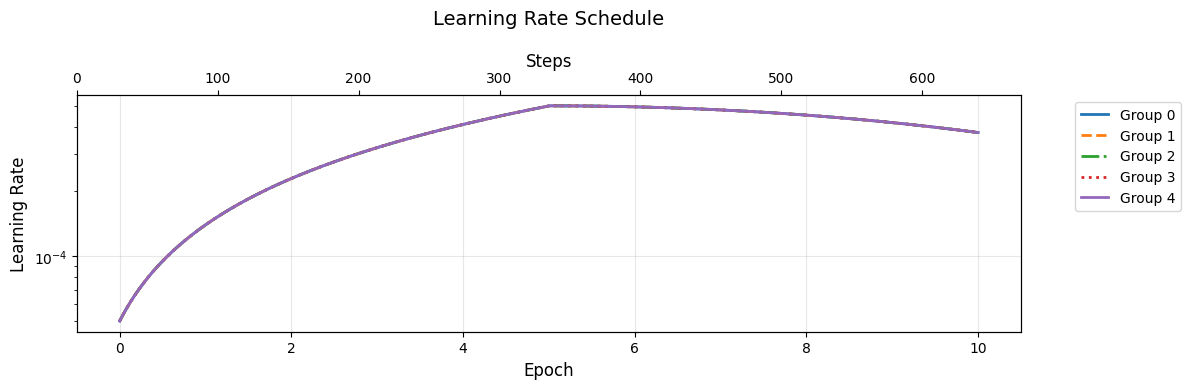

In [24]:
trainer.optimizer = create_optimizer(
    model=model,
    opt_config=config['optimizer']
)

trainer.scheduler = create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

plot_lr_schedule(
    scheduler=trainer.scheduler,
    num_epochs=config['training']['epochs'], 
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

# Initialize WandB
# if trainer.use_wandb:
#     wandb.init(
#         project=trainer.config['training'].get('wandb_project', 'time-series-forecasting'),
#         config=trainer.config,
#         name=trainer.run_name,
#         settings=wandb.Settings(
#         start_method="thread",             # don't spawn multiprocessing process
#         )
#     )


# Step 4: TRAIN!!   

In [25]:
print("here!")
trainer.train(train_loader, val_loader, epochs=50)

here!


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]/jet/home/psamal/hw_envs/idl_hw4/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MeanAbsoluteError was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
Training:   1%| | 1/67 [00:00<00:06,  9.54it/s, batch_accuracy=2.50%, loss=0.0170, mae=nan]

Training:   3%| | 2/67 [00:00<00:06,  9.54it/s, batch_accuracy=1.25%, loss=0.0177, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024743478279560804
abm_loss is 0.005931856110692024
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003955618012696505
abm_loss is 0.005524780135601759
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002377402037382126
abm_loss is 0.00756672490388155
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002635466167703271
abm_loss is 0.009980659000575542


Training:   6%| | 4/67 [00:00<00:03, 20.57it/s, batch_accuracy=5.00%, loss=0.0172, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002204996533691883
abm_loss is 0.008008639328181744
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023075263015925884
abm_loss is 0.003082748269662261


Training:  12%| | 8/67 [00:00<00:02, 24.22it/s, batch_accuracy=1.25%, loss=0.0089, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002186948200687766
abm_loss is 0.0036616430152207613
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019943811930716038
abm_loss is 0.002886539325118065
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015653594164177775
abm_loss is 0.0013262293068692088
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015259350184351206
abm_loss is 0.0015912950038909912


Training:  15%|▏| 10/67 [00:00<00:02, 25.51it/s, batch_accuracy=1.25%, loss=0.0089, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014077693922445178
abm_loss is 0.0024182943161576986
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012459721183404326
abm_loss is 0.0017525766743347049


Training:  21%|▏| 14/67 [00:00<00:01, 26.70it/s, batch_accuracy=5.00%, loss=0.0109, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002113582333549857
abm_loss is 0.004860954359173775
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013368420768529177
abm_loss is 0.005255090072751045
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013006788212805986
abm_loss is 0.005726967938244343
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007491621072404087
abm_loss is 0.004975373391062021


Training:  24%|▏| 16/67 [00:00<00:01, 27.02it/s, batch_accuracy=6.25%, loss=0.0144, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012109980452805758
abm_loss is 0.010877552442252636
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012000951683148742
abm_loss is 0.019659418612718582


Training:  30%|▎| 20/67 [00:00<00:01, 27.38it/s, batch_accuracy=22.50%, loss=0.0253, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009166551753878593
abm_loss is 0.02358613722026348
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010029483819380403
abm_loss is 0.017831506207585335
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014580583665519953
abm_loss is 0.023356830701231956
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024299174547195435
abm_loss is 0.01961103454232216


Training:  33%|▎| 22/67 [00:00<00:01, 27.85it/s, batch_accuracy=8.75%, loss=0.0337, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024063321761786938
abm_loss is 0.02812991850078106
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002559488406404853
abm_loss is 0.0319099985063076


Training:  39%|▍| 26/67 [00:01<00:01, 27.77it/s, batch_accuracy=27.50%, loss=0.0469, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001919868984259665
abm_loss is 0.031156033277511597
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016998701030388474
abm_loss is 0.03353799507021904
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001172487623989582
abm_loss is 0.05327146127820015
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011228194925934076
abm_loss is 0.05978604778647423


Training:  42%|▍| 28/67 [00:01<00:01, 27.97it/s, batch_accuracy=15.00%, loss=0.0852, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014294680440798402
abm_loss is 0.10124611854553223
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001183917629532516
abm_loss is 0.11747381836175919


Training:  48%|▍| 32/67 [00:01<00:01, 28.23it/s, batch_accuracy=6.25%, loss=0.0469, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002230081707239151
abm_loss is 0.05907624959945679
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007087660022079945
abm_loss is 0.014359950087964535
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004527494311332703
abm_loss is 0.03145603463053703
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024360590614378452
abm_loss is 0.062145765870809555


Training:  51%|▌| 34/67 [00:01<00:01, 27.88it/s, batch_accuracy=20.00%, loss=0.0519, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002196551999077201
abm_loss is 0.05309193208813667
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019086225656792521
abm_loss is 0.07162729650735855


Training:  57%|▌| 38/67 [00:01<00:01, 28.11it/s, batch_accuracy=26.25%, loss=0.1936, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012423003790900111
abm_loss is 0.0917522981762886
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013858199818059802
abm_loss is 0.14130182564258575
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002657976932823658
abm_loss is 0.23388360440731049
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006032187025994062
abm_loss is 0.36826473474502563


Training:  60%|▌| 40/67 [00:01<00:00, 28.15it/s, batch_accuracy=16.25%, loss=0.2527, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003665308700874448
abm_loss is 0.3039170205593109
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014241983881220222
abm_loss is 0.22704343497753143


Training:  66%|▋| 44/67 [00:01<00:00, 27.99it/s, batch_accuracy=1.25%, loss=1.0143, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003211729694157839
abm_loss is 0.4167112410068512
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0072692944668233395
abm_loss is 0.67365962266922
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02179264836013317
abm_loss is 1.1740635633468628
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012318020686507225
abm_loss is 1.0624386072158813


Training:  69%|▋| 46/67 [00:01<00:00, 28.20it/s, batch_accuracy=6.25%, loss=0.9940, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011901321820914745
abm_loss is 1.212023377418518
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01645619608461857
abm_loss is 1.5092605352401733


Training:  75%|▋| 50/67 [00:01<00:00, 27.96it/s, batch_accuracy=60.00%, loss=0.9249, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005116363056004047
abm_loss is 1.1733014583587646
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004257953260093927
abm_loss is 1.2618709802627563
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025953873991966248
abm_loss is 1.182848334312439
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032309764064848423
abm_loss is 1.6303566694259644


Training:  78%|▊| 52/67 [00:01<00:00, 28.02it/s, batch_accuracy=68.75%, loss=1.3208, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029845049139112234
abm_loss is 1.6937602758407593
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004166716244071722
abm_loss is 1.5423314571380615


Training:  84%|▊| 56/67 [00:02<00:00, 28.19it/s, batch_accuracy=45.00%, loss=1.5772, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0048032281920313835
abm_loss is 2.270263433456421
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037952715065330267
abm_loss is 2.2892558574676514
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009642750956118107
abm_loss is 1.9830909967422485
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019591934978961945
abm_loss is 1.763689398765564


Training:  87%|▊| 58/67 [00:02<00:00, 27.96it/s, batch_accuracy=0.00%, loss=1.1191, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05809051916003227
abm_loss is 1.0743521451950073
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.042710792273283005
abm_loss is 1.547428011894226


Training:  93%|▉| 62/67 [00:02<00:00, 28.05it/s, batch_accuracy=0.00%, loss=1.2391, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.057988639920949936
abm_loss is 1.4105479717254639
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08518717437982559
abm_loss is 1.083817958831787
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09898102283477783
abm_loss is 0.9644575119018555
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09046965092420578
abm_loss is 1.1204651594161987


Training:  96%|▉| 64/67 [00:02<00:00, 27.97it/s, batch_accuracy=3.75%, loss=1.4043, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.058979786932468414
abm_loss is 1.4384512901306152
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.034044962376356125
abm_loss is 1.9093586206436157


Training: 100%|█| 67/67 [00:02<00:00, 26.97it/s, batch_accuracy=24.00%, loss=1.9175, mae=na


shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.02026382088661194
abm_loss is 2.355532169342041

📈 Epoch 0 Metrics:
  TRAIN      | train_loss: 0.4873 | train_mae: nan | train_accuracy: 16.8480


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0451493114233017
abm_loss is 0.030141258612275124


Training:   6%| | 4/67 [00:00<00:03, 20.88it/s, batch_accuracy=0.00%, loss=0.1010, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04445447400212288
abm_loss is 0.02417321875691414
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.035691019147634506
abm_loss is 0.018362168222665787
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02939428947865963
abm_loss is 0.014076218008995056
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01867780275642872
abm_loss is 0.009712105616927147
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008725197985768318
abm_loss is 0.004380666185170412


Training:   7%| | 5/67 [00:00<00:02, 20.88it/s, batch_accuracy=1.25%, loss=0.0471, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004049459006637335
abm_loss is 0.004050564952194691


Training:  15%|▏| 10/67 [00:00<00:02, 25.48it/s, batch_accuracy=0.00%, loss=0.0298, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003984217997640371
abm_loss is 0.00532527407631278
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030427833553403616
abm_loss is 0.0033785197883844376
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005776143167167902
abm_loss is 0.009961149655282497
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004872614983469248
abm_loss is 0.007068268489092588
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00678277900442481
abm_loss is 0.008656865917146206


Training:  16%|▏| 11/67 [00:00<00:02, 25.48it/s, batch_accuracy=0.00%, loss=0.0406, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006575682200491428
abm_loss is 0.010935613885521889


Training:  24%|▏| 16/67 [00:00<00:01, 27.18it/s, batch_accuracy=7.50%, loss=0.0261, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004481697455048561
abm_loss is 0.011416004039347172
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004393118899315596
abm_loss is 0.010683692060410976
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002953489078208804
abm_loss is 0.009786169044673443
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003083382034674287
abm_loss is 0.013880801387131214
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003215837525203824
abm_loss is 0.01566024124622345


Training:  25%|▎| 17/67 [00:00<00:01, 27.18it/s, batch_accuracy=6.25%, loss=0.0282, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023285457864403725
abm_loss is 0.01854822412133217


Training:  33%|▎| 22/67 [00:00<00:01, 27.72it/s, batch_accuracy=6.25%, loss=0.0638, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006772387772798538
abm_loss is 0.013399384915828705
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006443581078201532
abm_loss is 0.022057585418224335
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010156876407563686
abm_loss is 0.015194805338978767
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008714351803064346
abm_loss is 0.02617057040333748
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007879997603595257
abm_loss is 0.024450933560729027


Training:  34%|▎| 23/67 [00:00<00:01, 27.72it/s, batch_accuracy=6.25%, loss=0.0583, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008776436559855938
abm_loss is 0.022284353151917458


Training:  42%|▍| 28/67 [00:01<00:01, 27.85it/s, batch_accuracy=21.25%, loss=0.0854, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007168120238929987
abm_loss is 0.02673826925456524
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005038021598011255
abm_loss is 0.04362175986170769
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005881768651306629
abm_loss is 0.04669266939163208
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032032188028097153
abm_loss is 0.08994822949171066
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023752839770168066
abm_loss is 0.11288261413574219


Training:  43%|▍| 29/67 [00:01<00:01, 27.85it/s, batch_accuracy=22.50%, loss=0.0989, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00492298137396574
abm_loss is 0.05788251385092735


Training:  51%|▌| 34/67 [00:01<00:01, 27.87it/s, batch_accuracy=12.50%, loss=0.0733, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008261702954769135
abm_loss is 0.015425634570419788
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0033454892691224813
abm_loss is 0.03946371003985405
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032942034304142
abm_loss is 0.06626550108194351
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004204528871923685
abm_loss is 0.06772811710834503
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003819650737568736
abm_loss is 0.08314253389835358


Training:  52%|▌| 35/67 [00:01<00:01, 27.87it/s, batch_accuracy=13.75%, loss=0.0832, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037642568349838257
abm_loss is 0.09542044997215271


Training:  60%|▌| 40/67 [00:01<00:00, 27.92it/s, batch_accuracy=18.75%, loss=0.2619, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031612503807991743
abm_loss is 0.14100715517997742
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004370951093733311
abm_loss is 0.23442097008228302
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0060897995717823505
abm_loss is 0.35728079080581665
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006449714303016663
abm_loss is 0.29787933826446533
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0060914987698197365
abm_loss is 0.19731847941875458


Training:  61%|▌| 41/67 [00:01<00:00, 27.92it/s, batch_accuracy=17.50%, loss=0.1826, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005175306927412748
abm_loss is 0.35293376445770264


Training:  69%|▋| 46/67 [00:01<00:00, 28.23it/s, batch_accuracy=36.25%, loss=0.7775, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00408124690875411
abm_loss is 0.5900751948356628
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0076159099116921425
abm_loss is 1.0061066150665283
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0060537732206285
abm_loss is 0.9065868258476257
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004394593182951212
abm_loss is 0.979942262172699
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006821615155786276
abm_loss is 1.2140920162200928


Training:  70%|▋| 47/67 [00:01<00:00, 28.23it/s, batch_accuracy=36.25%, loss=0.9702, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023050721734762192
abm_loss is 0.8729621767997742


Training:  78%|▊| 52/67 [00:01<00:00, 28.14it/s, batch_accuracy=10.00%, loss=1.2009, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020754186436533928
abm_loss is 0.9938066601753235
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03356444090604782
abm_loss is 0.9017967581748962
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020231714472174644
abm_loss is 1.349732756614685
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02416445128619671
abm_loss is 1.4007503986358643
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03207520768046379
abm_loss is 1.3326889276504517


Training:  79%|▊| 53/67 [00:01<00:00, 28.14it/s, batch_accuracy=10.00%, loss=1.1880, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011491936631500721
abm_loss is 2.011593818664551


Training:  87%|▊| 58/67 [00:02<00:00, 27.98it/s, batch_accuracy=0.00%, loss=1.1316, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01229881402105093
abm_loss is 2.1444435119628906
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019545728340744972
abm_loss is 1.8827850818634033
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030154753476381302
abm_loss is 1.7180465459823608
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0631464347243309
abm_loss is 1.0576856136322021
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.035910286009311676
abm_loss is 1.6053072214126587


Training:  88%|▉| 59/67 [00:02<00:00, 27.98it/s, batch_accuracy=6.25%, loss=1.4174, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0399276502430439
abm_loss is 1.488566517829895


Training:  96%|▉| 64/67 [00:02<00:00, 28.08it/s, batch_accuracy=7.50%, loss=1.3540, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05510662868618965
abm_loss is 1.1736124753952026
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06431334465742111
abm_loss is 1.0243183374404907
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.050264205783605576
abm_loss is 1.2185269594192505
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028876835480332375
abm_loss is 1.5687007904052734
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011646534316241741
abm_loss is 2.108003616333008


Training:  97%|▉| 65/67 [00:02<00:00, 28.08it/s, batch_accuracy=33.75%, loss=1.6835, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.004689059220254421
abm_loss is 2.630720853805542


Training: 100%|█| 67/67 [00:02<00:00, 26.96it/s, batch_accuracy=72.00%, loss=2.0516, mae=na



📈 Epoch 1 Metrics:
  TRAIN      | train_loss: 0.4773 | train_mae: nan | train_accuracy: 11.9325


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025640254840254784
abm_loss is 0.04283349588513374


Training:   1%| | 1/67 [00:00<00:06,  9.93it/s, batch_accuracy=0.00%, loss=0.1407, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02118500880897045
abm_loss is 0.044920530170202255
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:   6%| | 4/67 [00:00<00:02, 21.10it/s, batch_accuracy=0.00%, loss=0.0254, mae=nan]

mse_loss is 0.015076510608196259
abm_loss is 0.03752727806568146
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007965273223817348
abm_loss is 0.02568717673420906
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00320322229526937
abm_loss is 0.012102965265512466
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001257811556570232
abm_loss is 0.0026146378368139267


Training:   7%| | 5/67 [00:00<00:02, 21.10it/s, batch_accuracy=8.75%, loss=0.0083, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032352262642234564
abm_loss is 0.0024454344529658556


Training:  10%| | 7/67 [00:00<00:02, 24.54it/s, batch_accuracy=1.25%, loss=0.0181, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007083205971866846
abm_loss is 0.0038429945707321167


Training:  15%|▏| 10/67 [00:00<00:02, 25.69it/s, batch_accuracy=0.00%, loss=0.1319, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014376248233020306
abm_loss is 0.012351338751614094
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024035895243287086
abm_loss is 0.017106764018535614
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02337808720767498
abm_loss is 0.01928042247891426
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028953546658158302
abm_loss is 0.024925807490944862


Training:  16%|▏| 11/67 [00:00<00:02, 25.69it/s, batch_accuracy=0.00%, loss=0.1642, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027563197538256645
abm_loss is 0.019306272268295288


Training:  19%|▏| 13/67 [00:00<00:02, 26.81it/s, batch_accuracy=0.00%, loss=0.1529, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022095734253525734
abm_loss is 0.01237914152443409


Training:  24%|▏| 16/67 [00:00<00:01, 27.37it/s, batch_accuracy=1.25%, loss=0.0417, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015367153100669384
abm_loss is 0.007836426608264446
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015244784764945507
abm_loss is 0.007179807405918837
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0076267956756055355
abm_loss is 0.004592854529619217
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0051981559954583645
abm_loss is 0.007731593679636717


Training:  25%|▎| 17/67 [00:00<00:01, 27.37it/s, batch_accuracy=1.25%, loss=0.0320, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031523355282843113
abm_loss is 0.015696803107857704


Training:  28%|▎| 19/67 [00:00<00:01, 27.44it/s, batch_accuracy=11.25%, loss=0.0279, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015595881268382072
abm_loss is 0.0188773013651371


Training:  33%|▎| 22/67 [00:00<00:01, 27.93it/s, batch_accuracy=11.25%, loss=0.0438, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014741483610123396
abm_loss is 0.02609401009976864
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001376004540361464
abm_loss is 0.0338231585919857
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001558272517286241
abm_loss is 0.04675409942865372
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022591117303818464
abm_loss is 0.0558667853474617


Training:  34%|▎| 23/67 [00:00<00:01, 27.93it/s, batch_accuracy=12.50%, loss=0.0544, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001827683881856501
abm_loss is 0.0506763756275177


Training:  37%|▎| 25/67 [00:00<00:01, 27.76it/s, batch_accuracy=10.00%, loss=0.0482, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023632424417883158
abm_loss is 0.055463600903749466


Training:  42%|▍| 28/67 [00:01<00:01, 27.95it/s, batch_accuracy=26.25%, loss=0.0852, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016727776965126395
abm_loss is 0.06626392155885696
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001987603260204196
abm_loss is 0.06875302642583847
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002080286853015423
abm_loss is 0.09695114940404892
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017837645718827844
abm_loss is 0.11129086464643478


Training:  43%|▍| 29/67 [00:01<00:01, 27.95it/s, batch_accuracy=22.50%, loss=0.0947, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007154287304729223
abm_loss is 0.051583677530288696


Training:  46%|▍| 31/67 [00:01<00:01, 28.08it/s, batch_accuracy=8.75%, loss=0.0756, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01095519121736288
abm_loss is 0.012597369961440563


Training:  51%|▌| 34/67 [00:01<00:01, 27.80it/s, batch_accuracy=5.00%, loss=0.0984, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013364133425056934
abm_loss is 0.023307986557483673
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015031871385872364
abm_loss is 0.04305574670433998
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014043532311916351
abm_loss is 0.036394089460372925
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012539115734398365
abm_loss is 0.050201166421175


Training:  52%|▌| 35/67 [00:01<00:01, 27.80it/s, batch_accuracy=2.50%, loss=0.1015, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00837541464716196
abm_loss is 0.06322666257619858


Training:  55%|▌| 37/67 [00:01<00:01, 28.07it/s, batch_accuracy=8.75%, loss=0.0907, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0048166378401219845
abm_loss is 0.10273702442646027


Training:  60%|▌| 40/67 [00:01<00:00, 27.90it/s, batch_accuracy=38.75%, loss=0.2280, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022147861309349537
abm_loss is 0.20798766613006592
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003312734654173255
abm_loss is 0.3333464562892914
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002240663394331932
abm_loss is 0.2812187373638153
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003423628630116582
abm_loss is 0.20691119134426117


Training:  61%|▌| 41/67 [00:01<00:00, 27.90it/s, batch_accuracy=31.25%, loss=0.1767, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025247035082429647
abm_loss is 0.3949214220046997


Training:  64%|▋| 43/67 [00:01<00:00, 28.14it/s, batch_accuracy=33.75%, loss=0.3171, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004848894663155079
abm_loss is 0.6285449266433716


Training:  69%|▋| 46/67 [00:01<00:00, 28.31it/s, batch_accuracy=37.50%, loss=0.8453, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009273006580770016
abm_loss is 1.0739761590957642
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007841444574296474
abm_loss is 1.0191218852996826
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003921213559806347
abm_loss is 1.0709556341171265
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004004474263638258
abm_loss is 1.2546662092208862


Training:  70%|▋| 47/67 [00:01<00:00, 28.31it/s, batch_accuracy=55.00%, loss=0.9873, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013474928215146065
abm_loss is 0.9364951252937317


Training:  73%|▋| 49/67 [00:01<00:00, 28.03it/s, batch_accuracy=23.75%, loss=0.7895, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023171400651335716
abm_loss is 0.9707043766975403


Training:  78%|▊| 52/67 [00:01<00:00, 28.21it/s, batch_accuracy=11.25%, loss=1.1970, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03268244490027428
abm_loss is 0.895042896270752
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023992562666535378
abm_loss is 1.3185228109359741
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022159123793244362
abm_loss is 1.4087419509887695
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026744557544589043
abm_loss is 1.3301727771759033


Training:  79%|▊| 53/67 [00:01<00:00, 28.21it/s, batch_accuracy=6.25%, loss=1.1594, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011494981124997139
abm_loss is 2.0501928329467773


Training:  82%|▊| 55/67 [00:02<00:00, 28.31it/s, batch_accuracy=37.50%, loss=1.6382, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008936766535043716
abm_loss is 2.1639888286590576


Training:  87%|▊| 58/67 [00:02<00:00, 27.97it/s, batch_accuracy=1.25%, loss=1.1103, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016517937183380127
abm_loss is 1.905909776687622
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022822808474302292
abm_loss is 1.7440872192382812
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.052685823291540146
abm_loss is 1.0979795455932617
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028839314356446266
abm_loss is 1.644747018814087


Training:  88%|▉| 59/67 [00:02<00:00, 27.97it/s, batch_accuracy=11.25%, loss=1.4124, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03719336539506912
abm_loss is 1.5234100818634033


Training:  91%|▉| 61/67 [00:02<00:00, 28.15it/s, batch_accuracy=5.00%, loss=1.3607, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05464515835046768
abm_loss is 1.1515635251998901


Training:  96%|▉| 64/67 [00:02<00:00, 28.43it/s, batch_accuracy=8.75%, loss=1.3677, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06288062781095505
abm_loss is 1.0442850589752197
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05013592913746834
abm_loss is 1.1949584484100342
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025124013423919678
abm_loss is 1.6108967065811157
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011065884493291378
abm_loss is 2.1056721210479736


Training:  97%|▉| 65/67 [00:02<00:00, 28.43it/s, batch_accuracy=33.75%, loss=1.6788, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.004980920813977718
abm_loss is 2.6600637435913086


Training: 100%|█| 67/67 [00:02<00:00, 27.13it/s, batch_accuracy=70.00%, loss=2.0757, mae=na



📈 Epoch 2 Metrics:
  TRAIN      | train_loss: 0.4829 | train_mae: nan | train_accuracy: 13.2270


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02709016762673855
abm_loss is 0.04417644813656807


Training:   1%| | 1/67 [00:00<00:06,  9.61it/s, batch_accuracy=0.00%, loss=0.1655, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02505699172616005
abm_loss is 0.0519084595143795


Training:   6%| | 4/67 [00:00<00:03, 20.43it/s, batch_accuracy=0.00%, loss=0.0623, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020984364673495293
abm_loss is 0.04673842340707779
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015744080767035484
abm_loss is 0.03877699747681618
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00891523715108633
abm_loss is 0.022858869284391403
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005060234107077122
abm_loss is 0.012596896849572659


Training:   7%| | 5/67 [00:00<00:03, 20.43it/s, batch_accuracy=0.00%, loss=0.0350, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022980261128395796
abm_loss is 0.009986426681280136


Training:  10%| | 7/67 [00:00<00:02, 24.02it/s, batch_accuracy=2.50%, loss=0.0192, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009785654256120324
abm_loss is 0.004244404379278421


Training:  15%|▏| 10/67 [00:00<00:02, 25.46it/s, batch_accuracy=0.00%, loss=0.0286, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011962448479607701
abm_loss is 0.001106956391595304
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003076916793361306
abm_loss is 0.0018873034277930856
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005113830324262381
abm_loss is 0.003916008863598108
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008009995333850384
abm_loss is 0.006152687128633261


Training:  16%|▏| 11/67 [00:00<00:02, 25.46it/s, batch_accuracy=0.00%, loss=0.0448, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010900573804974556
abm_loss is 0.006501199211925268


Training:  19%|▏| 13/67 [00:00<00:02, 26.49it/s, batch_accuracy=0.00%, loss=0.0596, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010140076279640198
abm_loss is 0.005108661483973265


Training:  24%|▏| 16/67 [00:00<00:01, 27.22it/s, batch_accuracy=0.00%, loss=0.0828, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01461020577698946
abm_loss is 0.007419017609208822
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017532212659716606
abm_loss is 0.008154361508786678
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015592582523822784
abm_loss is 0.006097238510847092
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012237899005413055
abm_loss is 0.006255113985389471


Training:  25%|▎| 17/67 [00:00<00:01, 27.22it/s, batch_accuracy=0.00%, loss=0.0661, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011118486523628235
abm_loss is 0.00839215237647295


Training:  28%|▎| 19/67 [00:00<00:01, 27.20it/s, batch_accuracy=0.00%, loss=0.0621, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01109869685024023
abm_loss is 0.00827267486602068


Training:  33%|▎| 22/67 [00:00<00:01, 27.64it/s, batch_accuracy=5.00%, loss=0.0427, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008662908338010311
abm_loss is 0.01325216330587864
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006407456938177347
abm_loss is 0.014583108015358448
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004980630706995726
abm_loss is 0.022985609248280525
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0038672953378409147
abm_loss is 0.028443247079849243


Training:  34%|▎| 23/67 [00:00<00:01, 27.64it/s, batch_accuracy=8.75%, loss=0.0413, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032749369274824858
abm_loss is 0.02907004952430725


Training:  37%|▎| 25/67 [00:00<00:01, 27.98it/s, batch_accuracy=11.25%, loss=0.0388, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00231453706510365
abm_loss is 0.03294139727950096


Training:  42%|▍| 28/67 [00:01<00:01, 27.54it/s, batch_accuracy=25.00%, loss=0.0828, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027383165434002876
abm_loss is 0.04310470446944237
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016238962998613715
abm_loss is 0.055514682084321976
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016183805419132113
abm_loss is 0.09692724049091339
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001825800514779985
abm_loss is 0.11890991032123566


Training:  43%|▍| 29/67 [00:01<00:01, 27.54it/s, batch_accuracy=17.50%, loss=0.1008, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028760030400007963
abm_loss is 0.05725184828042984


Training:  46%|▍| 31/67 [00:01<00:01, 27.87it/s, batch_accuracy=21.25%, loss=0.0585, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007680874317884445
abm_loss is 0.014833572320640087


Training:  51%|▌| 34/67 [00:01<00:01, 28.01it/s, batch_accuracy=8.75%, loss=0.0744, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007453759200870991
abm_loss is 0.027005864307284355
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009236718527972698
abm_loss is 0.049594830721616745
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008272930048406124
abm_loss is 0.04279158636927605
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005415468942373991
abm_loss is 0.061801690608263016


Training:  52%|▌| 35/67 [00:01<00:01, 28.01it/s, batch_accuracy=8.75%, loss=0.0748, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002672886708751321
abm_loss is 0.08546261489391327


Training:  55%|▌| 37/67 [00:01<00:01, 27.85it/s, batch_accuracy=20.00%, loss=0.0793, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0035000869538635015
abm_loss is 0.12298732995986938


Training:  60%|▌| 40/67 [00:01<00:00, 28.12it/s, batch_accuracy=25.00%, loss=0.2280, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002394329058006406
abm_loss is 0.19962427020072937
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003105047857388854
abm_loss is 0.30946311354637146
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031615158077329397
abm_loss is 0.27524882555007935
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007711642887443304
abm_loss is 0.18007250130176544


Training:  61%|▌| 41/67 [00:01<00:00, 28.12it/s, batch_accuracy=21.25%, loss=0.1774, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005726538132876158
abm_loss is 0.32986196875572205


Training:  64%|▋| 43/67 [00:01<00:00, 27.99it/s, batch_accuracy=22.50%, loss=0.2830, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003746693953871727
abm_loss is 0.5761312246322632


Training:  69%|▋| 46/67 [00:01<00:00, 28.00it/s, batch_accuracy=11.25%, loss=0.7507, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005063608754426241
abm_loss is 0.9224569201469421
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006969243288040161
abm_loss is 0.8059477806091309
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01586281508207321
abm_loss is 0.870759129524231
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010859454050660133
abm_loss is 1.1435706615447998


Training:  70%|▋| 47/67 [00:01<00:00, 28.00it/s, batch_accuracy=28.75%, loss=0.9360, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024539269506931305
abm_loss is 0.8521744012832642


Training:  73%|▋| 49/67 [00:01<00:00, 28.27it/s, batch_accuracy=7.50%, loss=0.7799, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03532776981592178
abm_loss is 0.902606189250946


Training:  78%|▊| 52/67 [00:01<00:00, 27.93it/s, batch_accuracy=23.75%, loss=1.1941, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04062263295054436
abm_loss is 0.8635234236717224
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021294275298714638
abm_loss is 1.3313008546829224
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01795615814626217
abm_loss is 1.4322408437728882
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01787344552576542
abm_loss is 1.3887020349502563


Training:  79%|▊| 53/67 [00:01<00:00, 27.93it/s, batch_accuracy=12.50%, loss=1.1601, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008250176906585693
abm_loss is 2.1225593090057373


Training:  82%|▊| 55/67 [00:02<00:00, 28.20it/s, batch_accuracy=48.75%, loss=1.6777, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0064551555551588535
abm_loss is 2.254892110824585


Training:  87%|▊| 58/67 [00:02<00:00, 28.10it/s, batch_accuracy=0.00%, loss=1.0936, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009074007160961628
abm_loss is 1.988012671470642
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015665328130126
abm_loss is 1.8188663721084595
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05120733007788658
abm_loss is 1.0858862400054932
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023047298192977905
abm_loss is 1.6809959411621094


Training:  88%|▉| 59/67 [00:02<00:00, 28.10it/s, batch_accuracy=17.50%, loss=1.4114, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02378004603087902
abm_loss is 1.584571123123169


Training:  91%|▉| 61/67 [00:02<00:00, 27.90it/s, batch_accuracy=8.75%, loss=1.3407, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04624355584383011
abm_loss is 1.227634072303772


Training:  96%|▉| 64/67 [00:02<00:00, 28.26it/s, batch_accuracy=12.50%, loss=1.3592, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0500822439789772
abm_loss is 1.072945237159729
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.047951456159353256
abm_loss is 1.2130969762802124
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029658004641532898
abm_loss is 1.570421576499939
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012826263904571533
abm_loss is 2.075752019882202


Training:  97%|▉| 65/67 [00:02<00:00, 28.26it/s, batch_accuracy=35.00%, loss=1.6645, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.00680302269756794
abm_loss is 2.639270067214966


Training: 100%|█| 67/67 [00:02<00:00, 26.92it/s, batch_accuracy=60.00%, loss=2.0688, mae=na



📈 Epoch 3 Metrics:
  TRAIN      | train_loss: 0.4692 | train_mae: nan | train_accuracy: 12.5891


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014759602025151253
abm_loss is 0.02842016890645027


Training:   3%| | 2/67 [00:00<00:04, 15.66it/s, batch_accuracy=0.00%, loss=0.1029, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014977638609707355
abm_loss is 0.036177147179841995
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014314495027065277
abm_loss is 0.0363919660449028


Training:   7%| | 5/67 [00:00<00:02, 22.27it/s, batch_accuracy=0.00%, loss=0.0637, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012371087446808815
abm_loss is 0.033978421241045
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00908093061298132
abm_loss is 0.02359067276120186
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005692728795111179
abm_loss is 0.013376042246818542


Training:   7%| | 5/67 [00:00<00:02, 22.27it/s, batch_accuracy=0.00%, loss=0.0388, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005248171277344227
abm_loss is 0.014749680645763874


Training:  12%| | 8/67 [00:00<00:02, 24.91it/s, batch_accuracy=0.00%, loss=0.0179, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023531217593699694
abm_loss is 0.007950054481625557
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009570979746058583
abm_loss is 0.0015887859044596553


Training:  16%|▏| 11/67 [00:00<00:02, 26.12it/s, batch_accuracy=2.50%, loss=0.0035, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000825700000859797
abm_loss is 0.0031635724008083344
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005217783036641777
abm_loss is 0.0011341170175001025
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007508228882215917
abm_loss is 0.0006250847363844514


Training:  16%|▏| 11/67 [00:00<00:02, 26.12it/s, batch_accuracy=3.75%, loss=0.0042, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007081031799316406
abm_loss is 0.0017748099053278565


Training:  21%|▏| 14/67 [00:00<00:01, 26.56it/s, batch_accuracy=6.25%, loss=0.0066, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000917944882530719
abm_loss is 0.002570509444922209
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012880417052656412
abm_loss is 0.0026527501177042723


Training:  25%|▎| 17/67 [00:00<00:01, 27.26it/s, batch_accuracy=6.25%, loss=0.0106, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011813336750492454
abm_loss is 0.0024620001204311848
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000779553025495261
abm_loss is 0.008657938800752163
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008658954757265747
abm_loss is 0.014833874069154263


Training:  25%|▎| 17/67 [00:00<00:01, 27.26it/s, batch_accuracy=18.75%, loss=0.0158, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005832943134009838
abm_loss is 0.021532243117690086


Training:  30%|▎| 20/67 [00:00<00:01, 27.55it/s, batch_accuracy=13.75%, loss=0.0167, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000772073573898524
abm_loss is 0.01659388281404972
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005149211501702666
abm_loss is 0.027680469676852226


Training:  34%|▎| 23/67 [00:00<00:01, 27.47it/s, batch_accuracy=27.50%, loss=0.0308, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006977122975513339
abm_loss is 0.024217626079916954
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006058504222892225
abm_loss is 0.03605082258582115
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007415452273562551
abm_loss is 0.039432693272829056


Training:  34%|▎| 23/67 [00:00<00:01, 27.47it/s, batch_accuracy=16.25%, loss=0.0341, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012218126794323325
abm_loss is 0.03222394734621048


Training:  39%|▍| 26/67 [00:00<00:01, 27.83it/s, batch_accuracy=15.00%, loss=0.0341, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015391159104183316
abm_loss is 0.03418559953570366
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018086873460561037
abm_loss is 0.04323938861489296


Training:  43%|▍| 29/67 [00:01<00:01, 27.78it/s, batch_accuracy=5.00%, loss=0.0757, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002727293176576495
abm_loss is 0.044999655336141586
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004299938213080168
abm_loss is 0.07020514458417892
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004059342201799154
abm_loss is 0.08364520967006683


Training:  43%|▍| 29/67 [00:01<00:01, 27.78it/s, batch_accuracy=7.50%, loss=0.0848, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010394609533250332
abm_loss is 0.04082229360938072


Training:  48%|▍| 32/67 [00:01<00:01, 27.86it/s, batch_accuracy=0.00%, loss=0.1063, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01950922980904579
abm_loss is 0.011244270950555801
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02178807370364666
abm_loss is 0.01958155632019043


Training:  52%|▌| 35/67 [00:01<00:01, 28.12it/s, batch_accuracy=0.00%, loss=0.0942, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015146826393902302
abm_loss is 0.038901519030332565
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013155710883438587
abm_loss is 0.03671986237168312
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010909723117947578
abm_loss is 0.052032988518476486


Training:  52%|▌| 35/67 [00:01<00:01, 28.12it/s, batch_accuracy=2.50%, loss=0.0947, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004758043214678764
abm_loss is 0.07380422204732895


Training:  57%|▌| 38/67 [00:01<00:01, 27.85it/s, batch_accuracy=21.25%, loss=0.0986, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025657862424850464
abm_loss is 0.11119883507490158
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019269924378022552
abm_loss is 0.22128629684448242


Training:  61%|▌| 41/67 [00:01<00:00, 27.96it/s, batch_accuracy=27.50%, loss=0.2552, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003743315115571022
abm_loss is 0.3389164209365845
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003331325249746442
abm_loss is 0.30943211913108826
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001137650921009481
abm_loss is 0.21237388253211975


Training:  61%|▌| 41/67 [00:01<00:00, 27.96it/s, batch_accuracy=42.50%, loss=0.1694, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002699757693335414
abm_loss is 0.39971962571144104


Training:  66%|▋| 44/67 [00:01<00:00, 27.90it/s, batch_accuracy=35.00%, loss=0.4749, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031503152567893267
abm_loss is 0.5955821871757507
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004896026570349932
abm_loss is 1.0013048648834229


Training:  70%|▋| 47/67 [00:01<00:00, 27.96it/s, batch_accuracy=10.00%, loss=0.7434, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0051246872171759605
abm_loss is 0.8489384055137634
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01929405704140663
abm_loss is 0.8389984369277954
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024390272796154022
abm_loss is 1.0258944034576416


Training:  70%|▋| 47/67 [00:01<00:00, 27.96it/s, batch_accuracy=10.00%, loss=0.9130, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.043435271829366684
abm_loss is 0.7764293551445007


Training:  75%|▋| 50/67 [00:01<00:00, 28.18it/s, batch_accuracy=1.25%, loss=0.9138, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04963070526719093
abm_loss is 0.862935483455658
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04995771870017052
abm_loss is 0.8247085809707642


Training:  79%|▊| 53/67 [00:01<00:00, 27.95it/s, batch_accuracy=8.75%, loss=1.1856, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03156682103872299
abm_loss is 1.2476319074630737
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021594468504190445
abm_loss is 1.3975321054458618
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024838028475642204
abm_loss is 1.3177413940429688


Training:  79%|▊| 53/67 [00:01<00:00, 27.95it/s, batch_accuracy=7.50%, loss=1.1403, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009571472182869911
abm_loss is 2.075904130935669


Training:  84%|▊| 56/67 [00:02<00:00, 28.14it/s, batch_accuracy=57.50%, loss=1.7544, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005331528838723898
abm_loss is 2.2409491539001465
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007703221868723631
abm_loss is 2.015084981918335


Training:  88%|▉| 59/67 [00:02<00:00, 28.38it/s, batch_accuracy=1.25%, loss=1.0830, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014041024260222912
abm_loss is 1.82024347782135
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03722976893186569
abm_loss is 1.1629523038864136
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023896820843219757
abm_loss is 1.6886234283447266


Training:  88%|▉| 59/67 [00:02<00:00, 28.38it/s, batch_accuracy=16.25%, loss=1.4215, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023445889353752136
abm_loss is 1.5717471837997437


Training:  93%|▉| 62/67 [00:02<00:00, 28.06it/s, batch_accuracy=2.50%, loss=1.1734, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03723154589533806
abm_loss is 1.2802132368087769
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04425632953643799
abm_loss is 1.1268815994262695


Training:  97%|▉| 65/67 [00:02<00:00, 28.45it/s, batch_accuracy=10.00%, loss=1.3778, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04240947961807251
abm_loss is 1.2340046167373657
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026912078261375427
abm_loss is 1.612403154373169
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010958024300634861
abm_loss is 2.1080691814422607


Training:  97%|▉| 65/67 [00:02<00:00, 28.45it/s, batch_accuracy=40.00%, loss=1.6801, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.007294156588613987
abm_loss is 2.532470703125


Training: 100%|█| 67/67 [00:02<00:00, 27.15it/s, batch_accuracy=44.00%, loss=1.9889, mae=na



📈 Epoch 4 Metrics:
  TRAIN      | train_loss: 0.4619 | train_mae: nan | train_accuracy: 13.5835


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003161616623401642
abm_loss is 0.0019788204226642847


Training:   3%| | 2/67 [00:00<00:04, 14.83it/s, batch_accuracy=5.00%, loss=0.0163, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002727827522903681
abm_loss is 0.0034678098745644093
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:   7%| | 5/67 [00:00<00:02, 21.65it/s, batch_accuracy=1.25%, loss=0.0157, mae=nan]

mse_loss is 0.0019357887795194983
abm_loss is 0.003491768380627036
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001661199377849698
abm_loss is 0.004213040694594383
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026583410799503326
abm_loss is 0.003049576422199607
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027075421530753374
abm_loss is 0.0012059879954904318


Training:   7%| | 5/67 [00:00<00:02, 21.65it/s, batch_accuracy=1.25%, loss=0.0145, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016475942684337497
abm_loss is 0.0018194022122770548


Training:   9%| | 6/67 [00:00<00:02, 21.65it/s, batch_accuracy=1.25%, loss=0.0097, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001903746509924531
abm_loss is 0.0014043668052181602


Training:  16%|▏| 11/67 [00:00<00:02, 26.06it/s, batch_accuracy=0.00%, loss=0.0082, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025745860766619444
abm_loss is 0.0018319495720788836
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012230384163558483
abm_loss is 0.001095708692446351
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014550993219017982
abm_loss is 0.0012060588924214244
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014023634139448404
abm_loss is 0.00099111907184124


Training:  16%|▏| 11/67 [00:00<00:02, 26.06it/s, batch_accuracy=1.25%, loss=0.0078, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006088544032536447
abm_loss is 0.0013252826174721122


Training:  18%|▏| 12/67 [00:00<00:02, 26.06it/s, batch_accuracy=5.00%, loss=0.0041, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005673036212101579
abm_loss is 0.003495238721370697


Training:  25%|▎| 17/67 [00:00<00:01, 27.20it/s, batch_accuracy=8.75%, loss=0.0173, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004942181403748691
abm_loss is 0.0035296373534947634
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004910912830382586
abm_loss is 0.004939371719956398
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011138366535305977
abm_loss is 0.01515856571495533
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013239739928394556
abm_loss is 0.022901808843016624


Training:  25%|▎| 17/67 [00:00<00:01, 27.20it/s, batch_accuracy=8.75%, loss=0.0243, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020800663623958826
abm_loss is 0.034251753240823746


Training:  27%|▎| 18/67 [00:00<00:01, 27.20it/s, batch_accuracy=2.50%, loss=0.0368, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012979296734556556
abm_loss is 0.028002528473734856


Training:  34%|▎| 23/67 [00:00<00:01, 27.54it/s, batch_accuracy=11.25%, loss=0.0428, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00207174732349813
abm_loss is 0.040462326258420944
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014621032169088721
abm_loss is 0.03615158423781395
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011416387278586626
abm_loss is 0.04810513183474541
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011136068496853113
abm_loss is 0.052301835268735886


Training:  34%|▎| 23/67 [00:00<00:01, 27.54it/s, batch_accuracy=15.00%, loss=0.0459, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00066807382972911
abm_loss is 0.04399140179157257


Training:  36%|▎| 24/67 [00:00<00:01, 27.54it/s, batch_accuracy=27.50%, loss=0.0373, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006680085207335651
abm_loss is 0.041887979954481125


Training:  43%|▍| 29/67 [00:01<00:01, 27.66it/s, batch_accuracy=17.50%, loss=0.0736, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00108755799010396
abm_loss is 0.05086029693484306
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010767456842586398
abm_loss is 0.05203482136130333
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002322329208254814
abm_loss is 0.08041276037693024
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032544005662202835
abm_loss is 0.08479773998260498


Training:  43%|▍| 29/67 [00:01<00:01, 27.66it/s, batch_accuracy=18.75%, loss=0.0817, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006259657442569733
abm_loss is 0.04396114870905876


Training:  45%|▍| 30/67 [00:01<00:01, 27.66it/s, batch_accuracy=1.25%, loss=0.0652, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019216641783714294
abm_loss is 0.01128522027283907


Training:  52%|▌| 35/67 [00:01<00:01, 27.74it/s, batch_accuracy=0.00%, loss=0.1270, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021608559414744377
abm_loss is 0.01835089735686779
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02229471318423748
abm_loss is 0.03262468799948692
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020488228648900986
abm_loss is 0.031667377799749374
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01577802561223507
abm_loss is 0.04283808171749115


Training:  52%|▌| 35/67 [00:01<00:01, 27.74it/s, batch_accuracy=0.00%, loss=0.1120, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012172370217740536
abm_loss is 0.05649731308221817


Training:  54%|▌| 36/67 [00:01<00:01, 27.74it/s, batch_accuracy=1.25%, loss=0.1045, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00648632412776351
abm_loss is 0.09616095572710037


Training:  61%|▌| 41/67 [00:01<00:00, 28.16it/s, batch_accuracy=27.50%, loss=0.2464, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002525509102270007
abm_loss is 0.1781609058380127
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024817672092467546
abm_loss is 0.3311760425567627
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027668096590787172
abm_loss is 0.30166444182395935
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011750751873478293
abm_loss is 0.22696185111999512


Training:  61%|▌| 41/67 [00:01<00:00, 28.16it/s, batch_accuracy=40.00%, loss=0.1809, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002294467529281974
abm_loss is 0.40769287943840027


Training:  63%|▋| 42/67 [00:01<00:00, 28.16it/s, batch_accuracy=32.50%, loss=0.3258, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005027309060096741
abm_loss is 0.638072669506073


Training:  70%|▋| 47/67 [00:01<00:00, 28.14it/s, batch_accuracy=25.00%, loss=0.7405, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008433740586042404
abm_loss is 1.0397275686264038
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004410866182297468
abm_loss is 0.886734664440155
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008832140825688839
abm_loss is 0.9031076431274414
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018417520448565483
abm_loss is 1.0765984058380127


Training:  70%|▋| 47/67 [00:01<00:00, 28.14it/s, batch_accuracy=17.50%, loss=0.9222, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03052913025021553
abm_loss is 0.8385893106460571


Training:  72%|▋| 48/67 [00:01<00:00, 28.14it/s, batch_accuracy=5.00%, loss=0.7994, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.057245757430791855
abm_loss is 0.8572457432746887


Training:  79%|▊| 53/67 [00:01<00:00, 28.07it/s, batch_accuracy=3.75%, loss=1.2102, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0658300444483757
abm_loss is 0.7960257530212402
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04356251284480095
abm_loss is 1.2115601301193237
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0351523756980896
abm_loss is 1.341430425643921
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03434009104967117
abm_loss is 1.271783709526062


Training:  79%|▊| 53/67 [00:01<00:00, 28.07it/s, batch_accuracy=3.75%, loss=1.1524, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015132513828575611
abm_loss is 1.993204116821289


Training:  81%|▊| 54/67 [00:02<00:00, 28.07it/s, batch_accuracy=30.00%, loss=1.6124, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006660487502813339
abm_loss is 2.2123520374298096


Training:  88%|▉| 59/67 [00:02<00:00, 28.27it/s, batch_accuracy=1.25%, loss=1.0831, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008156712166965008
abm_loss is 1.9950008392333984
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015560022555291653
abm_loss is 1.7994235754013062
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04150024801492691
abm_loss is 1.135318636894226
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02124795690178871
abm_loss is 1.6806480884552002


Training:  88%|▉| 59/67 [00:02<00:00, 28.27it/s, batch_accuracy=16.25%, loss=1.4021, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022172978147864342
abm_loss is 1.6216989755630493


Training:  90%|▉| 60/67 [00:02<00:00, 28.27it/s, batch_accuracy=8.75%, loss=1.3613, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03827545791864395
abm_loss is 1.2532823085784912


Training:  97%|▉| 65/67 [00:02<00:00, 28.62it/s, batch_accuracy=13.75%, loss=1.3499, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.048997584730386734
abm_loss is 1.0828285217285156
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03645448759198189
abm_loss is 1.2440073490142822
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019525161013007164
abm_loss is 1.6240837574005127
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009685295633971691
abm_loss is 2.117753267288208


Training:  97%|▉| 65/67 [00:02<00:00, 28.62it/s, batch_accuracy=48.75%, loss=1.6812, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.004611022304743528
abm_loss is 2.592416286468506


Training: 100%|█| 67/67 [00:02<00:00, 26.99it/s, batch_accuracy=66.00%, loss=2.0217, mae=na



📈 Epoch 5 Metrics:
  TRAIN      | train_loss: 0.4601 | train_mae: nan | train_accuracy: 13.0019


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005182341556064785
abm_loss is 0.0033817291259765625


Training:   3%| | 2/67 [00:00<00:04, 14.97it/s, batch_accuracy=10.00%, loss=0.0077, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00043658437789417803
abm_loss is 0.007164608221501112
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004476707545109093
abm_loss is 0.006445709150284529


Training:   7%| | 5/67 [00:00<00:02, 21.61it/s, batch_accuracy=6.25%, loss=0.0071, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004954705946147442
abm_loss is 0.007192177232354879
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000776447297539562
abm_loss is 0.004144574515521526
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008167175692506135
abm_loss is 0.0016042914940044284


Training:   7%| | 5/67 [00:00<00:02, 21.61it/s, batch_accuracy=3.75%, loss=0.0053, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009662727243267
abm_loss is 0.0022661094553768635


Training:  12%| | 8/67 [00:00<00:02, 24.53it/s, batch_accuracy=5.00%, loss=0.0065, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001032415428198874
abm_loss is 0.001698841922916472
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017892386531457305
abm_loss is 0.0011752719292417169


Training:  16%|▏| 11/67 [00:00<00:02, 25.67it/s, batch_accuracy=0.00%, loss=0.0095, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013181165559217334
abm_loss is 0.0011793079320341349
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017037000507116318
abm_loss is 0.0012753800256177783
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016189388697966933
abm_loss is 0.0010418709134683013


Training:  16%|▏| 11/67 [00:00<00:02, 25.67it/s, batch_accuracy=0.00%, loss=0.0089, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009731915197335184
abm_loss is 0.0011130020720884204


Training:  21%|▏| 14/67 [00:00<00:02, 26.45it/s, batch_accuracy=11.25%, loss=0.0050, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007380266324616969
abm_loss is 0.0016998987412080169
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006327436421997845
abm_loss is 0.0021347065921872854


Training:  25%|▎| 17/67 [00:00<00:01, 27.18it/s, batch_accuracy=15.00%, loss=0.0112, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005396318156272173
abm_loss is 0.0030390601605176926
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005376372719183564
abm_loss is 0.011039559729397297
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00043430333607830107
abm_loss is 0.018044352531433105


Training:  25%|▎| 17/67 [00:00<00:01, 27.18it/s, batch_accuracy=17.50%, loss=0.0161, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006392113864421844
abm_loss is 0.026731261983513832


Training:  30%|▎| 20/67 [00:00<00:01, 27.15it/s, batch_accuracy=17.50%, loss=0.0197, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005256772856228054
abm_loss is 0.022105706855654716
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005491272895596921
abm_loss is 0.03288235515356064


Training:  34%|▎| 23/67 [00:00<00:01, 27.61it/s, batch_accuracy=26.25%, loss=0.0390, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005055339424870908
abm_loss is 0.030456749722361565
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007835673168301582
abm_loss is 0.045489758253097534
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004488159902393818
abm_loss is 0.04726141691207886


Training:  34%|▎| 23/67 [00:00<00:01, 27.61it/s, batch_accuracy=42.50%, loss=0.0387, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00041178567335009575
abm_loss is 0.04144035279750824


Training:  39%|▍| 26/67 [00:00<00:01, 27.87it/s, batch_accuracy=28.75%, loss=0.0334, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000592170690651983
abm_loss is 0.03949965164065361
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006231229635886848
abm_loss is 0.051618751138448715


Training:  43%|▍| 29/67 [00:01<00:01, 27.58it/s, batch_accuracy=22.50%, loss=0.0721, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007503108936361969
abm_loss is 0.05596180632710457
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001321699470281601
abm_loss is 0.08487627655267715
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016750633949413896
abm_loss is 0.09482716768980026


Training:  43%|▍| 29/67 [00:01<00:01, 27.58it/s, batch_accuracy=18.75%, loss=0.0815, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004641811829060316
abm_loss is 0.04802635312080383


Training:  48%|▍| 32/67 [00:01<00:01, 27.91it/s, batch_accuracy=0.00%, loss=0.0681, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011686205863952637
abm_loss is 0.012399793602526188
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01771186664700508
abm_loss is 0.018101299181580544


Training:  52%|▌| 35/67 [00:01<00:01, 27.83it/s, batch_accuracy=0.00%, loss=0.1009, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014824630692601204
abm_loss is 0.03652850538492203
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01532988902181387
abm_loss is 0.03137289360165596
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01672045700252056
abm_loss is 0.04090878739953041


Training:  52%|▌| 35/67 [00:01<00:01, 27.83it/s, batch_accuracy=0.00%, loss=0.1153, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013927667401731014
abm_loss is 0.0518084354698658


Training:  57%|▌| 38/67 [00:01<00:01, 27.88it/s, batch_accuracy=0.00%, loss=0.1355, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014660385437309742
abm_loss is 0.08051241934299469
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005627595353871584
abm_loss is 0.15768340229988098


Training:  61%|▌| 41/67 [00:01<00:00, 28.14it/s, batch_accuracy=35.00%, loss=0.2059, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016803210601210594
abm_loss is 0.2892199456691742
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023080899845808744
abm_loss is 0.2520390450954437
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022351094521582127
abm_loss is 0.1934991180896759


Training:  61%|▌| 41/67 [00:01<00:00, 28.14it/s, batch_accuracy=31.25%, loss=0.1604, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017750965198501945
abm_loss is 0.35581323504447937


Training:  66%|▋| 44/67 [00:01<00:00, 27.84it/s, batch_accuracy=40.00%, loss=0.4924, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003164647612720728
abm_loss is 0.6181444525718689
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00627521425485611
abm_loss is 1.0366179943084717


Training:  70%|▋| 47/67 [00:01<00:00, 28.02it/s, batch_accuracy=25.00%, loss=0.7531, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004392221570014954
abm_loss is 0.921813428401947
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00837900023907423
abm_loss is 0.9224069714546204
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013330976478755474
abm_loss is 1.1114658117294312


Training:  70%|▋| 47/67 [00:01<00:00, 28.02it/s, batch_accuracy=20.00%, loss=0.9236, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023491574451327324
abm_loss is 0.8675628900527954


Training:  75%|▋| 50/67 [00:01<00:00, 28.00it/s, batch_accuracy=2.50%, loss=0.9167, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0477503202855587
abm_loss is 0.8789331316947937
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05240793898701668
abm_loss is 0.8338571786880493


Training:  79%|▊| 53/67 [00:01<00:00, 27.83it/s, batch_accuracy=3.75%, loss=1.1792, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.034903641790151596
abm_loss is 1.236257791519165
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028019530698657036
abm_loss is 1.347603440284729
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03085956536233425
abm_loss is 1.2873035669326782


Training:  79%|▊| 53/67 [00:01<00:00, 27.83it/s, batch_accuracy=5.00%, loss=1.1470, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011221210472285748
abm_loss is 1.9762613773345947


Training:  84%|▊| 56/67 [00:02<00:00, 28.00it/s, batch_accuracy=47.50%, loss=1.7237, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00753712747246027
abm_loss is 2.1868131160736084
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016200903803110123
abm_loss is 1.8874742984771729


Training:  88%|▉| 59/67 [00:02<00:00, 27.91it/s, batch_accuracy=0.00%, loss=1.0855, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02096429280936718
abm_loss is 1.7427600622177124
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04380550608038902
abm_loss is 1.1235088109970093
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024904301390051842
abm_loss is 1.6726105213165283


Training:  88%|▉| 59/67 [00:02<00:00, 27.91it/s, batch_accuracy=10.00%, loss=1.4142, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.031694043427705765
abm_loss is 1.507979154586792


Training:  93%|▉| 62/67 [00:02<00:00, 28.08it/s, batch_accuracy=0.00%, loss=1.1752, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04771372303366661
abm_loss is 1.2145417928695679
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05869288370013237
abm_loss is 1.0663245916366577


Training:  97%|▉| 65/67 [00:02<00:00, 28.44it/s, batch_accuracy=11.25%, loss=1.3566, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04641152173280716
abm_loss is 1.207025408744812
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02365906909108162
abm_loss is 1.6060024499893188
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008942658081650734
abm_loss is 2.1094136238098145


Training:  97%|▉| 65/67 [00:02<00:00, 28.44it/s, batch_accuracy=37.50%, loss=1.6710, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.003756908467039466
abm_loss is 2.596189260482788


Training: 100%|█| 67/67 [00:02<00:00, 26.99it/s, batch_accuracy=72.00%, loss=2.0204, mae=na



📈 Epoch 6 Metrics:
  TRAIN      | train_loss: 0.4517 | train_mae: nan | train_accuracy: 15.2533


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008221559110097587
abm_loss is 0.005838366225361824


Training:   3%| | 2/67 [00:00<00:04, 15.57it/s, batch_accuracy=2.50%, loss=0.0132, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009671194711700082
abm_loss is 0.01077810674905777
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007868767133913934
abm_loss is 0.010775293223559856


Training:   7%| | 5/67 [00:00<00:02, 22.11it/s, batch_accuracy=8.75%, loss=0.0079, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001077829278074205
abm_loss is 0.010870002210140228
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005454824422486126
abm_loss is 0.006767881568521261
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004530305159278214
abm_loss is 0.002316073514521122


Training:   7%| | 5/67 [00:00<00:02, 22.11it/s, batch_accuracy=5.00%, loss=0.0041, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00042335400939919055
abm_loss is 0.0035397436004132032


Training:  12%| | 8/67 [00:00<00:02, 24.85it/s, batch_accuracy=2.50%, loss=0.0036, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00046043406473472714
abm_loss is 0.0017002506647258997
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011255515273660421
abm_loss is 0.0007244732696563005


Training:  16%|▏| 11/67 [00:00<00:02, 26.22it/s, batch_accuracy=1.25%, loss=0.0078, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008642833563499153
abm_loss is 0.0008776957402005792
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013922307407483459
abm_loss is 0.0011026023421436548
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015617519384250045
abm_loss is 0.0009923841571435332


Training:  16%|▏| 11/67 [00:00<00:02, 26.22it/s, batch_accuracy=2.50%, loss=0.0086, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009590286645106971
abm_loss is 0.0009442677837796509


Training:  21%|▏| 14/67 [00:00<00:01, 26.69it/s, batch_accuracy=2.50%, loss=0.0058, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008656293503008783
abm_loss is 0.0019321332219988108
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007140254019759595
abm_loss is 0.0021883805748075247


Training:  25%|▎| 17/67 [00:00<00:01, 27.40it/s, batch_accuracy=15.00%, loss=0.0098, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006904967012815177
abm_loss is 0.0028584280516952276
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003909930237568915
abm_loss is 0.010226166807115078
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00041734473779797554
abm_loss is 0.01746506616473198


Training:  25%|▎| 17/67 [00:00<00:01, 27.40it/s, batch_accuracy=23.75%, loss=0.0156, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005281005287542939
abm_loss is 0.02609187364578247


Training:  30%|▎| 20/67 [00:00<00:01, 27.52it/s, batch_accuracy=18.75%, loss=0.0194, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005203530890867114
abm_loss is 0.02178460918366909
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007955204928293824
abm_loss is 0.033562690019607544


Training:  34%|▎| 23/67 [00:00<00:01, 27.77it/s, batch_accuracy=23.75%, loss=0.0376, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005215248093008995
abm_loss is 0.029939204454421997
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006735784118063748
abm_loss is 0.0443975031375885
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00044021682697348297
abm_loss is 0.048519790172576904


Training:  34%|▎| 23/67 [00:00<00:01, 27.77it/s, batch_accuracy=32.50%, loss=0.0396, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003905312332790345
abm_loss is 0.04142873361706734


Training:  39%|▍| 26/67 [00:00<00:01, 28.00it/s, batch_accuracy=21.25%, loss=0.0344, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00037739583058282733
abm_loss is 0.042137015610933304
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004180990217719227
abm_loss is 0.055311452597379684


Training:  43%|▍| 29/67 [00:01<00:01, 27.79it/s, batch_accuracy=33.75%, loss=0.0736, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006046692724339664
abm_loss is 0.057734258472919464
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005505695007741451
abm_loss is 0.09193647652864456
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007350658415816724
abm_loss is 0.10251157730817795


Training:  43%|▍| 29/67 [00:01<00:01, 27.79it/s, batch_accuracy=33.75%, loss=0.0827, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029618788976222277
abm_loss is 0.05088887736201286


Training:  48%|▍| 32/67 [00:01<00:01, 27.88it/s, batch_accuracy=0.00%, loss=0.0585, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009660649113357067
abm_loss is 0.013117372989654541
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013618329539895058
abm_loss is 0.020578423514962196


Training:  52%|▌| 35/67 [00:01<00:01, 28.20it/s, batch_accuracy=1.25%, loss=0.0855, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012587699107825756
abm_loss is 0.03897148370742798
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011622336693108082
abm_loss is 0.0353844091296196
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01572113297879696
abm_loss is 0.041174862533807755


Training:  52%|▌| 35/67 [00:01<00:01, 28.20it/s, batch_accuracy=0.00%, loss=0.1105, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013970362953841686
abm_loss is 0.049361467361450195


Training:  57%|▌| 38/67 [00:01<00:01, 27.97it/s, batch_accuracy=1.25%, loss=0.1180, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010570699349045753
abm_loss is 0.08436228334903717
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006261856760829687
abm_loss is 0.15431560575962067


Training:  61%|▌| 41/67 [00:01<00:00, 28.19it/s, batch_accuracy=33.75%, loss=0.2068, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003276741597801447
abm_loss is 0.2667960524559021
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002906565321609378
abm_loss is 0.249390110373497
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003862826619297266
abm_loss is 0.17999139428138733


Training:  61%|▌| 41/67 [00:01<00:00, 28.19it/s, batch_accuracy=17.50%, loss=0.1581, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003699446562677622
abm_loss is 0.33477964997291565


Training:  66%|▋| 44/67 [00:01<00:00, 28.15it/s, batch_accuracy=33.75%, loss=0.4522, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031087512616068125
abm_loss is 0.566372275352478
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003346625017002225
abm_loss is 0.9499969482421875


Training:  70%|▋| 47/67 [00:01<00:00, 28.00it/s, batch_accuracy=31.25%, loss=0.7354, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00305175525136292
abm_loss is 0.8882316946983337
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00789005495607853
abm_loss is 0.9026271104812622
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005573286674916744
abm_loss is 1.2111700773239136


Training:  70%|▋| 47/67 [00:01<00:00, 28.00it/s, batch_accuracy=45.00%, loss=0.9617, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01788114383816719
abm_loss is 0.8948544859886169


Training:  75%|▋| 50/67 [00:01<00:00, 28.25it/s, batch_accuracy=0.00%, loss=0.8861, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.035481393337249756
abm_loss is 0.9189149141311646
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03503016382455826
abm_loss is 0.8842726945877075


Training:  79%|▊| 53/67 [00:01<00:00, 28.10it/s, batch_accuracy=7.50%, loss=1.1875, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03162825107574463
abm_loss is 1.2473385334014893
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022786764428019524
abm_loss is 1.3923723697662354
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025051577016711235
abm_loss is 1.3189889192581177


Training:  79%|▊| 53/67 [00:01<00:00, 28.10it/s, batch_accuracy=6.25%, loss=1.1423, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01413874514400959
abm_loss is 2.0178141593933105


Training:  84%|▊| 56/67 [00:02<00:00, 28.08it/s, batch_accuracy=45.00%, loss=1.6968, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006349921226501465
abm_loss is 2.159689426422119
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013996790163218975
abm_loss is 1.9208449125289917


Training:  88%|▉| 59/67 [00:02<00:00, 28.28it/s, batch_accuracy=0.00%, loss=1.0982, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019676825031638145
abm_loss is 1.7531414031982422
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0527411587536335
abm_loss is 1.0819748640060425
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03247788920998573
abm_loss is 1.625562310218811


Training:  88%|▉| 59/67 [00:02<00:00, 28.28it/s, batch_accuracy=6.25%, loss=1.4158, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030135104432702065
abm_loss is 1.54526948928833


Training:  93%|▉| 62/67 [00:02<00:00, 28.08it/s, batch_accuracy=0.00%, loss=1.1649, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0516066737473011
abm_loss is 1.1758002042770386
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06011427193880081
abm_loss is 1.0356119871139526


Training:  97%|▉| 65/67 [00:02<00:00, 28.39it/s, batch_accuracy=5.00%, loss=1.3541, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05310559272766113
abm_loss is 1.2147605419158936
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025058960542082787
abm_loss is 1.593667984008789
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011224818415939808
abm_loss is 2.0758779048919678


Training:  97%|▉| 65/67 [00:02<00:00, 28.39it/s, batch_accuracy=37.50%, loss=1.6566, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.004336764570325613
abm_loss is 2.645599365234375


Training: 100%|█| 67/67 [00:02<00:00, 27.23it/s, batch_accuracy=70.00%, loss=2.0614, mae=na



📈 Epoch 7 Metrics:
  TRAIN      | train_loss: 0.4485 | train_mae: nan | train_accuracy: 14.8218


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00044872876605950296
abm_loss is 0.0036830019671469927


Training:   3%| | 2/67 [00:00<00:04, 15.08it/s, batch_accuracy=11.25%, loss=0.0090, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006342316046357155
abm_loss is 0.007576696574687958
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005100658163428307
abm_loss is 0.008506613783538342


Training:   7%| | 5/67 [00:00<00:02, 22.41it/s, batch_accuracy=3.75%, loss=0.0054, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00036665445077233016
abm_loss is 0.007741543930023909
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004540373047348112
abm_loss is 0.004090806003659964
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006870537181384861
abm_loss is 0.0017262109322473407


Training:   7%| | 5/67 [00:00<00:02, 22.41it/s, batch_accuracy=3.75%, loss=0.0048, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006003046873956919
abm_loss is 0.003090725978836417


Training:  12%| | 8/67 [00:00<00:02, 24.56it/s, batch_accuracy=1.25%, loss=0.0064, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009970266837626696
abm_loss is 0.0017935741925612092
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001660735928453505
abm_loss is 0.0011364822275936604


Training:  16%|▏| 11/67 [00:00<00:02, 26.11it/s, batch_accuracy=2.50%, loss=0.0096, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012569493846967816
abm_loss is 0.0011061497498303652
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001739921630360186
abm_loss is 0.0011991262435913086
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014191461959853768
abm_loss is 0.0008976768585853279


Training:  16%|▏| 11/67 [00:00<00:02, 26.11it/s, batch_accuracy=0.00%, loss=0.0078, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007611628388985991
abm_loss is 0.001011749031022191


Training:  21%|▏| 14/67 [00:00<00:01, 26.73it/s, batch_accuracy=1.25%, loss=0.0047, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006429681670852005
abm_loss is 0.0019318892154842615
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00044578249799087644
abm_loss is 0.00246465764939785


Training:  25%|▎| 17/67 [00:00<00:01, 27.23it/s, batch_accuracy=18.75%, loss=0.0119, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004010946140624583
abm_loss is 0.0033339224755764008
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005176062695682049
abm_loss is 0.012052799575030804
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005993134691379964
abm_loss is 0.020710555836558342


Training:  25%|▎| 17/67 [00:00<00:01, 27.23it/s, batch_accuracy=12.50%, loss=0.0190, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009459900902584195
abm_loss is 0.029312944039702415


Training:  30%|▎| 20/67 [00:00<00:01, 27.68it/s, batch_accuracy=17.50%, loss=0.0230, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007372669642791152
abm_loss is 0.025066612288355827
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010406862711533904
abm_loss is 0.03574057295918465


Training:  34%|▎| 23/67 [00:00<00:01, 27.55it/s, batch_accuracy=7.50%, loss=0.0439, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007266528555192053
abm_loss is 0.03399954363703728
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001214676769450307
abm_loss is 0.04904009774327278
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009698810172267258
abm_loss is 0.051934074610471725


Training:  34%|▎| 23/67 [00:00<00:01, 27.55it/s, batch_accuracy=11.25%, loss=0.0449, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00044403012725524604
abm_loss is 0.04495956748723984


Training:  39%|▍| 26/67 [00:00<00:01, 27.88it/s, batch_accuracy=31.25%, loss=0.0369, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003857444098684937
abm_loss is 0.04538024589419365
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00033427358721382916
abm_loss is 0.05765607953071594


Training:  43%|▍| 29/67 [00:01<00:01, 27.98it/s, batch_accuracy=35.00%, loss=0.0769, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004419249889906496
abm_loss is 0.062132108956575394
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005283908103592694
abm_loss is 0.09632312506437302
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000556296028662473
abm_loss is 0.10664558410644531


Training:  43%|▍| 29/67 [00:01<00:01, 27.98it/s, batch_accuracy=43.75%, loss=0.0850, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025988740380853415
abm_loss is 0.05223003029823303


Training:  48%|▍| 32/67 [00:01<00:01, 27.83it/s, batch_accuracy=0.00%, loss=0.0607, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010087194852530956
abm_loss is 0.013181879185140133
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011511098593473434
abm_loss is 0.021852076053619385


Training:  52%|▌| 35/67 [00:01<00:01, 28.04it/s, batch_accuracy=0.00%, loss=0.0859, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01286268513649702
abm_loss is 0.0391213558614254
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011942960321903229
abm_loss is 0.03391215205192566
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016296369954943657
abm_loss is 0.04169212654232979


Training:  52%|▌| 35/67 [00:01<00:01, 28.04it/s, batch_accuracy=0.00%, loss=0.1137, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014689070172607899
abm_loss is 0.05123668909072876


Training:  57%|▌| 38/67 [00:01<00:01, 28.16it/s, batch_accuracy=1.25%, loss=0.1136, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009463269263505936
abm_loss is 0.08595818281173706
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008696806617081165
abm_loss is 0.14562515914440155


Training:  61%|▌| 41/67 [00:01<00:00, 28.04it/s, batch_accuracy=45.00%, loss=0.2037, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034130492713302374
abm_loss is 0.2691377103328705
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002225187374278903
abm_loss is 0.2497335970401764
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003693587379530072
abm_loss is 0.18310731649398804


Training:  61%|▌| 41/67 [00:01<00:00, 28.04it/s, batch_accuracy=17.50%, loss=0.1597, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015401702839881182
abm_loss is 0.3596280515193939


Training:  66%|▋| 44/67 [00:01<00:00, 28.25it/s, batch_accuracy=52.50%, loss=0.4473, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019534386228770018
abm_loss is 0.5674911141395569
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034419242292642593
abm_loss is 0.9783384203910828


Training:  70%|▋| 47/67 [00:01<00:00, 28.09it/s, batch_accuracy=25.00%, loss=0.7459, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004109592642635107
abm_loss is 0.8257521986961365
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008623035624623299
abm_loss is 0.9115226864814758
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013465058989822865
abm_loss is 1.103322982788086


Training:  70%|▋| 47/67 [00:01<00:00, 28.09it/s, batch_accuracy=8.75%, loss=0.9180, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021522900089621544
abm_loss is 0.8667012453079224


Training:  75%|▋| 50/67 [00:01<00:00, 28.16it/s, batch_accuracy=0.00%, loss=0.8711, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03415876626968384
abm_loss is 0.9080895781517029
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0389091931283474
abm_loss is 0.8493703007698059


Training:  79%|▊| 53/67 [00:01<00:00, 28.37it/s, batch_accuracy=7.50%, loss=1.1850, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02431539259850979
abm_loss is 1.2924258708953857
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020119741559028625
abm_loss is 1.4064176082611084
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024880414828658104
abm_loss is 1.309224009513855


Training:  79%|▊| 53/67 [00:01<00:00, 28.37it/s, batch_accuracy=1.25%, loss=1.1339, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008962870575487614
abm_loss is 2.063917875289917


Training:  84%|▊| 56/67 [00:02<00:00, 27.94it/s, batch_accuracy=53.75%, loss=1.7105, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006551947444677353
abm_loss is 2.176177978515625
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009545788168907166
abm_loss is 1.9861536026000977


Training:  88%|▉| 59/67 [00:02<00:00, 28.17it/s, batch_accuracy=2.50%, loss=1.1058, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0151387182995677
abm_loss is 1.771685242652893
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04392893612384796
abm_loss is 1.1490949392318726
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026030510663986206
abm_loss is 1.6561510562896729


Training:  88%|▉| 59/67 [00:02<00:00, 28.17it/s, batch_accuracy=7.50%, loss=1.4071, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026928720995783806
abm_loss is 1.5418500900268555


Training:  93%|▉| 62/67 [00:02<00:00, 27.94it/s, batch_accuracy=0.00%, loss=1.1609, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05195602402091026
abm_loss is 1.1683470010757446
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.057540472596883774
abm_loss is 1.0682690143585205


Training:  97%|▉| 65/67 [00:02<00:00, 28.20it/s, batch_accuracy=11.25%, loss=1.3471, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.056447532027959824
abm_loss is 1.2037650346755981
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02569400705397129
abm_loss is 1.580504298210144
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012994888238608837
abm_loss is 2.0640885829925537


Training:  97%|▉| 65/67 [00:02<00:00, 28.20it/s, batch_accuracy=25.00%, loss=1.6564, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0054183825850486755
abm_loss is 2.6259167194366455


Training: 100%|█| 67/67 [00:02<00:00, 27.18it/s, batch_accuracy=66.00%, loss=2.0516, mae=na



📈 Epoch 8 Metrics:
  TRAIN      | train_loss: 0.4481 | train_mae: nan | train_accuracy: 15.6285


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009443943272344768
abm_loss is 0.002589064883068204


Training:   1%| | 1/67 [00:00<00:07,  9.39it/s, batch_accuracy=13.75%, loss=0.0074, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005230751703493297
abm_loss is 0.00618726247921586


Training:   6%| | 4/67 [00:00<00:03, 20.67it/s, batch_accuracy=10.00%, loss=0.0061, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005396752967499197
abm_loss is 0.006822897586971521
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000568893039599061
abm_loss is 0.006402578204870224
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006814704393036664
abm_loss is 0.0035136842634528875
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009634339367039502
abm_loss is 0.0014243843033909798


Training:   7%| | 5/67 [00:00<00:03, 20.67it/s, batch_accuracy=3.75%, loss=0.0059, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008436089265160263
abm_loss is 0.0025720656849443913


Training:  10%| | 7/67 [00:00<00:02, 24.03it/s, batch_accuracy=2.50%, loss=0.0062, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012103880289942026
abm_loss is 0.0015353545313701034


Training:  15%|▏| 10/67 [00:00<00:02, 25.59it/s, batch_accuracy=0.00%, loss=0.0085, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016815330600365996
abm_loss is 0.0011300314217805862
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013896719319745898
abm_loss is 0.0008004806004464626
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015263392124325037
abm_loss is 0.0011586950859054923
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00136389525141567
abm_loss is 0.0009546686778776348


Training:  16%|▏| 11/67 [00:00<00:02, 25.59it/s, batch_accuracy=0.00%, loss=0.0076, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007442549103870988
abm_loss is 0.0011122726136818528


Training:  19%|▏| 13/67 [00:00<00:02, 26.70it/s, batch_accuracy=3.75%, loss=0.0046, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00047071525477804244
abm_loss is 0.002233189297839999


Training:  24%|▏| 16/67 [00:00<00:01, 26.94it/s, batch_accuracy=12.50%, loss=0.0125, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00043832967639900744
abm_loss is 0.003166148904711008
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003362041898071766
abm_loss is 0.003962561953812838
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005463687120936811
abm_loss is 0.012705479748547077
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009683296084403992
abm_loss is 0.021765688434243202


Training:  25%|▎| 17/67 [00:00<00:01, 26.94it/s, batch_accuracy=6.25%, loss=0.0216, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001291383639909327
abm_loss is 0.030676230788230896


Training:  28%|▎| 19/67 [00:00<00:01, 27.52it/s, batch_accuracy=7.50%, loss=0.0301, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010156502248719335
abm_loss is 0.02667643129825592


Training:  33%|▎| 22/67 [00:00<00:01, 27.90it/s, batch_accuracy=12.50%, loss=0.0433, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001282517216168344
abm_loss is 0.03728141263127327
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011057471856474876
abm_loss is 0.03632384166121483
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00121954211499542
abm_loss is 0.048219580203294754
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010636084480211139
abm_loss is 0.05357406288385391


Training:  34%|▎| 23/67 [00:00<00:01, 27.90it/s, batch_accuracy=17.50%, loss=0.0466, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005207270733080804
abm_loss is 0.04441491514444351


Training:  37%|▎| 25/67 [00:00<00:01, 27.65it/s, batch_accuracy=31.25%, loss=0.0368, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00037673584301956
abm_loss is 0.04472939297556877


Training:  42%|▍| 28/67 [00:01<00:01, 27.93it/s, batch_accuracy=30.00%, loss=0.0844, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007442906498908997
abm_loss is 0.06208084896206856
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00032705787452869117
abm_loss is 0.0619654543697834
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006882721791043878
abm_loss is 0.10498010367155075
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005473624914884567
abm_loss is 0.11578588932752609


Training:  43%|▍| 29/67 [00:01<00:01, 27.93it/s, batch_accuracy=37.50%, loss=0.0920, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001729930634610355
abm_loss is 0.05816449597477913


Training:  46%|▍| 31/67 [00:01<00:01, 28.07it/s, batch_accuracy=17.50%, loss=0.0535, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006402767729014158
abm_loss is 0.014248996041715145


Training:  51%|▌| 34/67 [00:01<00:01, 27.82it/s, batch_accuracy=0.00%, loss=0.0698, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0075743901543319225
abm_loss is 0.025054678320884705
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006480866577476263
abm_loss is 0.04885074123740196
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00826712604612112
abm_loss is 0.03686949610710144
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00996748823672533
abm_loss is 0.05017002299427986


Training:  52%|▌| 35/67 [00:01<00:01, 27.82it/s, batch_accuracy=0.00%, loss=0.0886, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00766976410523057
abm_loss is 0.05980125069618225


Training:  55%|▌| 37/67 [00:01<00:01, 28.15it/s, batch_accuracy=0.00%, loss=0.0845, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009999561123549938
abm_loss is 0.08577439188957214


Training:  60%|▌| 40/67 [00:01<00:00, 28.12it/s, batch_accuracy=7.50%, loss=0.1933, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007379517890512943
abm_loss is 0.15177331864833832
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010027626529335976
abm_loss is 0.2311689406633377
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005730376113206148
abm_loss is 0.21348467469215393
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009728615172207355
abm_loss is 0.16359494626522064


Training:  61%|▌| 41/67 [00:01<00:00, 28.12it/s, batch_accuracy=6.25%, loss=0.1748, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006793583277612925
abm_loss is 0.3064720332622528


Training:  64%|▋| 43/67 [00:01<00:00, 28.15it/s, batch_accuracy=10.00%, loss=0.2703, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006093144882470369
abm_loss is 0.5251912474632263


Training:  69%|▋| 46/67 [00:01<00:00, 28.37it/s, batch_accuracy=32.50%, loss=0.7428, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005163565278053284
abm_loss is 0.8733396530151367
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007530577480792999
abm_loss is 0.7948796153068542
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007930251769721508
abm_loss is 0.9119951128959656
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010579816997051239
abm_loss is 1.1127902269363403


Training:  70%|▋| 47/67 [00:01<00:00, 28.37it/s, batch_accuracy=25.00%, loss=0.9109, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01677519641816616
abm_loss is 0.8867160677909851


Training:  73%|▋| 49/67 [00:01<00:00, 28.12it/s, batch_accuracy=10.00%, loss=0.7676, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024591518566012383
abm_loss is 0.957856297492981


Training:  78%|▊| 52/67 [00:01<00:00, 28.14it/s, batch_accuracy=10.00%, loss=1.1896, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03235981985926628
abm_loss is 0.8936643600463867
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02087787538766861
abm_loss is 1.31716787815094
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018687289208173752
abm_loss is 1.4216259717941284
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024252189323306084
abm_loss is 1.334260106086731


Training:  79%|▊| 53/67 [00:01<00:00, 28.14it/s, batch_accuracy=5.00%, loss=1.1501, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01081025693565607
abm_loss is 2.0048201084136963


Training:  82%|▊| 55/67 [00:02<00:00, 28.29it/s, batch_accuracy=32.50%, loss=1.5998, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009344932623207569
abm_loss is 2.158182144165039


Training:  87%|▊| 58/67 [00:02<00:00, 27.99it/s, batch_accuracy=0.00%, loss=1.1262, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011524285189807415
abm_loss is 1.9535950422286987
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01675996743142605
abm_loss is 1.7605291604995728
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05221756175160408
abm_loss is 1.121622085571289
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03155681490898132
abm_loss is 1.6225286722183228


Training:  88%|▉| 59/67 [00:02<00:00, 27.99it/s, batch_accuracy=7.50%, loss=1.4089, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029779715463519096
abm_loss is 1.545633316040039


Training:  91%|▉| 61/67 [00:02<00:00, 28.03it/s, batch_accuracy=5.00%, loss=1.3407, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.052292730659246445
abm_loss is 1.2295407056808472


Training:  96%|▉| 64/67 [00:02<00:00, 28.33it/s, batch_accuracy=6.25%, loss=1.3567, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06624680012464523
abm_loss is 1.0374794006347656
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05436810478568077
abm_loss is 1.1800158023834229
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03169841319322586
abm_loss is 1.553847074508667
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012235145084559917
abm_loss is 2.094910144805908


Training:  97%|▉| 65/67 [00:02<00:00, 28.33it/s, batch_accuracy=38.75%, loss=1.6763, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.003848012536764145
abm_loss is 2.6299211978912354


Training: 100%|█| 67/67 [00:02<00:00, 27.06it/s, batch_accuracy=70.00%, loss=2.0468, mae=na



📈 Epoch 9 Metrics:
  TRAIN      | train_loss: 0.4460 | train_mae: nan | train_accuracy: 12.9831


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014697965234518051
abm_loss is 0.0021090577356517315


Training:   3%| | 2/67 [00:00<00:04, 15.14it/s, batch_accuracy=6.25%, loss=0.0073, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007767687784507871
abm_loss is 0.00436435267329216
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000802204420324415
abm_loss is 0.0049306354485452175


Training:   7%| | 5/67 [00:00<00:02, 22.11it/s, batch_accuracy=2.50%, loss=0.0085, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006577284657396376
abm_loss is 0.005346880294382572
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011701284674927592
abm_loss is 0.0033722296357154846
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014455191558226943
abm_loss is 0.0013841193867847323


Training:   7%| | 5/67 [00:00<00:02, 22.11it/s, batch_accuracy=3.75%, loss=0.0083, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001080868998542428
abm_loss is 0.0021716977935284376


Training:  12%| | 8/67 [00:00<00:02, 24.88it/s, batch_accuracy=5.00%, loss=0.0076, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001267203246243298
abm_loss is 0.0016165230190381408
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016904001822695136
abm_loss is 0.0010419996688142419


Training:  16%|▏| 11/67 [00:00<00:02, 25.89it/s, batch_accuracy=0.00%, loss=0.0073, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012013110099360347
abm_loss is 0.0009220453212037683
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001279301242902875
abm_loss is 0.0011426479322835803
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011013796320185065
abm_loss is 0.0006554634310305119


Training:  16%|▏| 11/67 [00:00<00:02, 25.89it/s, batch_accuracy=1.25%, loss=0.0060, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005963155999779701
abm_loss is 0.001260331249795854


Training:  21%|▏| 14/67 [00:00<00:01, 26.55it/s, batch_accuracy=7.50%, loss=0.0041, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00040412740781903267
abm_loss is 0.0026856635231524706
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002825432165991515
abm_loss is 0.0030389304738491774


Training:  25%|▎| 17/67 [00:00<00:01, 27.31it/s, batch_accuracy=11.25%, loss=0.0136, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00043082196498289704
abm_loss is 0.004814555868506432
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007264567539095879
abm_loss is 0.012984896078705788
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014235287671908736
abm_loss is 0.02399439737200737


Training:  25%|▎| 17/67 [00:00<00:01, 27.31it/s, batch_accuracy=5.00%, loss=0.0256, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001672397251240909
abm_loss is 0.032081812620162964


Training:  30%|▎| 20/67 [00:00<00:01, 27.38it/s, batch_accuracy=3.75%, loss=0.0282, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012920147273689508
abm_loss is 0.028247354552149773
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018729650182649493
abm_loss is 0.04052000865340233


Training:  34%|▎| 23/67 [00:00<00:01, 27.69it/s, batch_accuracy=1.25%, loss=0.0501, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013877165038138628
abm_loss is 0.037377920001745224
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018687046831473708
abm_loss is 0.05290016159415245
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013878908939659595
abm_loss is 0.05595621094107628


Training:  34%|▎| 23/67 [00:00<00:01, 27.69it/s, batch_accuracy=1.25%, loss=0.0501, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008479635580442846
abm_loss is 0.048462893813848495


Training:  39%|▍| 26/67 [00:00<00:01, 27.97it/s, batch_accuracy=31.25%, loss=0.0396, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005438755033537745
abm_loss is 0.04787999391555786
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006463592289946973
abm_loss is 0.06267391890287399


Training:  43%|▍| 29/67 [00:01<00:01, 27.80it/s, batch_accuracy=10.00%, loss=0.0928, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004866000672336668
abm_loss is 0.06754251569509506
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013963672099635005
abm_loss is 0.11135270446538925
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001162539585493505
abm_loss is 0.1251985877752304


Training:  43%|▍| 29/67 [00:01<00:01, 27.80it/s, batch_accuracy=17.50%, loss=0.1023, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008708671666681767
abm_loss is 0.06362701207399368


Training:  48%|▍| 32/67 [00:01<00:01, 28.02it/s, batch_accuracy=0.00%, loss=0.0348, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0045265997759997845
abm_loss is 0.015680765733122826
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031432881951332092
abm_loss is 0.029827982187271118


Training:  52%|▌| 35/67 [00:01<00:01, 28.05it/s, batch_accuracy=1.25%, loss=0.0518, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020389307755976915
abm_loss is 0.06037217378616333
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026967001613229513
abm_loss is 0.04964606091380119
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024706898257136345
abm_loss is 0.06680994480848312


Training:  52%|▌| 35/67 [00:01<00:01, 28.05it/s, batch_accuracy=5.00%, loss=0.0639, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028020930476486683
abm_loss is 0.07155848294496536


Training:  57%|▌| 38/67 [00:01<00:01, 28.02it/s, batch_accuracy=18.75%, loss=0.0975, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015275616897270083
abm_loss is 0.11654341220855713
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011128325713798404
abm_loss is 0.18728415668010712


Training:  61%|▌| 41/67 [00:01<00:00, 28.22it/s, batch_accuracy=3.75%, loss=0.1966, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018756950739771128
abm_loss is 0.2838450074195862
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006414137315005064
abm_loss is 0.21330304443836212
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010093982331454754
abm_loss is 0.15351653099060059


Training:  61%|▌| 41/67 [00:01<00:00, 28.22it/s, batch_accuracy=3.75%, loss=0.1689, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015779700130224228
abm_loss is 0.26221367716789246


Training:  66%|▋| 44/67 [00:01<00:00, 27.89it/s, batch_accuracy=17.50%, loss=0.4199, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010331964120268822
abm_loss is 0.4775110185146332
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007551062852144241
abm_loss is 0.8200592994689941


Training:  70%|▋| 47/67 [00:01<00:00, 28.11it/s, batch_accuracy=10.00%, loss=0.7327, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007793514523655176
abm_loss is 0.783754289150238
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017765918746590614
abm_loss is 0.8350673913955688
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015010247938334942
abm_loss is 1.1123393774032593


Training:  70%|▋| 47/67 [00:01<00:00, 28.11it/s, batch_accuracy=12.50%, loss=0.9327, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020066751167178154
abm_loss is 0.8955482840538025


Training:  75%|▋| 50/67 [00:01<00:00, 28.27it/s, batch_accuracy=5.00%, loss=0.8515, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021650688722729683
abm_loss is 0.9638506174087524
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026222987100481987
abm_loss is 0.933020293712616


Training:  79%|▊| 53/67 [00:01<00:00, 27.99it/s, batch_accuracy=17.50%, loss=1.1798, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015383340418338776
abm_loss is 1.358695387840271
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01198447123169899
abm_loss is 1.4525156021118164
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012644046917557716
abm_loss is 1.4210644960403442


Training:  79%|▊| 53/67 [00:01<00:00, 27.99it/s, batch_accuracy=17.50%, loss=1.1589, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00606239028275013
abm_loss is 2.0825698375701904


Training:  84%|▊| 56/67 [00:02<00:00, 28.17it/s, batch_accuracy=61.25%, loss=1.7496, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003864447819069028
abm_loss is 2.244300603866577
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00887718703597784
abm_loss is 2.012500524520874


Training:  88%|▉| 59/67 [00:02<00:00, 28.22it/s, batch_accuracy=0.00%, loss=1.0993, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019479310140013695
abm_loss is 1.7528694868087769
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05263933166861534
abm_loss is 1.0840513706207275
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03204798325896263
abm_loss is 1.6304835081100464


Training:  88%|▉| 59/67 [00:02<00:00, 28.22it/s, batch_accuracy=6.25%, loss=1.4175, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03681736811995506
abm_loss is 1.5113872289657593


Training:  93%|▉| 62/67 [00:02<00:00, 28.00it/s, batch_accuracy=0.00%, loss=1.1944, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05955900624394417
abm_loss is 1.162489891052246
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07069476693868637
abm_loss is 1.0014488697052002


Training:  97%|▉| 65/67 [00:02<00:00, 28.41it/s, batch_accuracy=3.75%, loss=1.3615, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.059003472328186035
abm_loss is 1.1823012828826904
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03467276692390442
abm_loss is 1.5408324003219604
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01505957543849945
abm_loss is 2.0502212047576904


Training:  99%|▉| 66/67 [00:02<00:00, 28.41it/s, batch_accuracy=74.00%, loss=2.0056, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0034762942232191563
abm_loss is 2.5788660049438477


Training: 100%|█| 67/67 [00:02<00:00, 27.17it/s, batch_accuracy=74.00%, loss=2.0056, mae=na



📈 Epoch 10 Metrics:
  TRAIN      | train_loss: 0.4459 | train_mae: nan | train_accuracy: 12.7392


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01006701122969389
abm_loss is 0.004865557420998812


Training:   3%| | 2/67 [00:00<00:04, 15.04it/s, batch_accuracy=0.00%, loss=0.0438, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00819358415901661
abm_loss is 0.0036197274457663298
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006825780961662531
abm_loss is 0.002940400270745158


Training:   7%| | 5/67 [00:00<00:02, 21.85it/s, batch_accuracy=0.00%, loss=0.0277, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006000026594847441
abm_loss is 0.003022105200216174
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005187985021620989
abm_loss is 0.0022811158560216427
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005488275084644556
abm_loss is 0.002535040955990553


Training:   7%| | 5/67 [00:00<00:02, 21.85it/s, batch_accuracy=0.00%, loss=0.0294, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003561133984476328
abm_loss is 0.0016984103713184595


Training:  12%| | 8/67 [00:00<00:02, 24.27it/s, batch_accuracy=0.00%, loss=0.0175, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00323505443520844
abm_loss is 0.0016481891507282853
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003605926875025034
abm_loss is 0.0026774785947054625


Training:  16%|▏| 11/67 [00:00<00:02, 25.93it/s, batch_accuracy=1.25%, loss=0.0076, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016016915906220675
abm_loss is 0.0008651820244267583
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013498303014785051
abm_loss is 0.00110831658821553
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007053078152239323
abm_loss is 0.0005686303484253585


Training:  16%|▏| 11/67 [00:00<00:02, 25.93it/s, batch_accuracy=0.00%, loss=0.0040, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00032901152735576034
abm_loss is 0.0015722563257440925


Training:  21%|▏| 14/67 [00:00<00:02, 26.34it/s, batch_accuracy=11.25%, loss=0.0045, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003619326453190297
abm_loss is 0.003525128588080406
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005277059390209615
abm_loss is 0.004916440229862928


Training:  25%|▎| 17/67 [00:00<00:01, 26.82it/s, batch_accuracy=0.00%, loss=0.0227, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009144477662630379
abm_loss is 0.007368446793407202
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017679360462352633
abm_loss is 0.01792028360068798
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002419759053736925
abm_loss is 0.027219189330935478


Training:  25%|▎| 17/67 [00:00<00:01, 26.82it/s, batch_accuracy=0.00%, loss=0.0331, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003135786624625325
abm_loss is 0.03785395249724388


Training:  30%|▎| 20/67 [00:00<00:01, 27.16it/s, batch_accuracy=0.00%, loss=0.0369, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023827042896300554
abm_loss is 0.03237104043364525
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029852502048015594
abm_loss is 0.04415814206004143


Training:  34%|▎| 23/67 [00:00<00:01, 27.47it/s, batch_accuracy=1.25%, loss=0.0533, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021503267344087362
abm_loss is 0.040546055883169174
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022213072516024113
abm_loss is 0.05468994379043579
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015688035637140274
abm_loss is 0.056416478008031845


Training:  34%|▎| 23/67 [00:00<00:01, 27.47it/s, batch_accuracy=3.75%, loss=0.0513, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008804730023257434
abm_loss is 0.04942075535655022


Training:  39%|▍| 26/67 [00:00<00:01, 27.78it/s, batch_accuracy=21.25%, loss=0.0395, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005387859418988228
abm_loss is 0.04776564985513687
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005644200136885047
abm_loss is 0.06191420182585716


Training:  43%|▍| 29/67 [00:01<00:01, 27.55it/s, batch_accuracy=36.25%, loss=0.0819, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005410588346421719
abm_loss is 0.06805720180273056
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006013676756992936
abm_loss is 0.10238076746463776
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006153727881610394
abm_loss is 0.11825001239776611


Training:  43%|▍| 29/67 [00:01<00:01, 27.55it/s, batch_accuracy=42.50%, loss=0.0942, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001408098149113357
abm_loss is 0.05943850427865982


Training:  48%|▍| 32/67 [00:01<00:01, 27.71it/s, batch_accuracy=0.00%, loss=0.0395, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005586580839008093
abm_loss is 0.014927173964679241
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0055068740621209145
abm_loss is 0.027300378307700157


Training:  52%|▌| 35/67 [00:01<00:01, 27.83it/s, batch_accuracy=0.00%, loss=0.0608, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003639301983639598
abm_loss is 0.05301341414451599
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005443614907562733
abm_loss is 0.04348761588335037
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005099322646856308
abm_loss is 0.05760398134589195


Training:  52%|▌| 35/67 [00:01<00:01, 27.83it/s, batch_accuracy=0.00%, loss=0.0699, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0050235590897500515
abm_loss is 0.06473187357187271


Training:  57%|▌| 38/67 [00:01<00:01, 27.78it/s, batch_accuracy=0.00%, loss=0.1007, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00452358229085803
abm_loss is 0.10125547647476196
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003550338326022029
abm_loss is 0.16525626182556152


Training:  61%|▌| 41/67 [00:01<00:00, 28.04it/s, batch_accuracy=18.75%, loss=0.1975, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023215152323246002
abm_loss is 0.27635928988456726
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004904765170067549
abm_loss is 0.22432155907154083
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012747079133987427
abm_loss is 0.15173335373401642


Training:  61%|▌| 41/67 [00:01<00:00, 28.04it/s, batch_accuracy=2.50%, loss=0.1808, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010684534907341003
abm_loss is 0.2891824245452881


Training:  66%|▋| 44/67 [00:01<00:00, 27.88it/s, batch_accuracy=11.25%, loss=0.4132, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00932892132550478
abm_loss is 0.4753234088420868
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010269179940223694
abm_loss is 0.7864969372749329


Training:  70%|▋| 47/67 [00:01<00:00, 28.00it/s, batch_accuracy=8.75%, loss=0.7234, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01376563310623169
abm_loss is 0.7347916960716248
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01434275507926941
abm_loss is 0.8451399803161621
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010377474129199982
abm_loss is 1.1310549974441528


Training:  70%|▋| 47/67 [00:01<00:00, 28.00it/s, batch_accuracy=26.25%, loss=0.9240, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019788818433880806
abm_loss is 0.8720394968986511


Training:  75%|▋| 50/67 [00:01<00:00, 28.17it/s, batch_accuracy=10.00%, loss=0.8519, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017252793535590172
abm_loss is 0.9929453134536743
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019143179059028625
abm_loss is 0.9392151236534119


Training:  79%|▊| 53/67 [00:01<00:00, 27.98it/s, batch_accuracy=20.00%, loss=1.1912, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012422419153153896
abm_loss is 1.3659685850143433
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01360338181257248
abm_loss is 1.456750750541687
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015454118140041828
abm_loss is 1.3915742635726929


Training:  79%|▊| 53/67 [00:01<00:00, 27.98it/s, batch_accuracy=11.25%, loss=1.1502, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008450253866612911
abm_loss is 2.0463664531707764


Training:  84%|▊| 56/67 [00:02<00:00, 28.13it/s, batch_accuracy=51.25%, loss=1.6988, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006568937096744776
abm_loss is 2.1608033180236816
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011542563326656818
abm_loss is 1.9408572912216187


Training:  88%|▉| 59/67 [00:02<00:00, 28.25it/s, batch_accuracy=0.00%, loss=1.1064, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0186516884714365
abm_loss is 1.796854853630066
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05243963003158569
abm_loss is 1.0944942235946655
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03940166160464287
abm_loss is 1.5673496723175049


Training:  88%|▉| 59/67 [00:02<00:00, 28.25it/s, batch_accuracy=2.50%, loss=1.4056, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.039750564843416214
abm_loss is 1.4983786344528198


Training:  93%|▉| 62/67 [00:02<00:00, 27.90it/s, batch_accuracy=0.00%, loss=1.1902, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0572693906724453
abm_loss is 1.1718765497207642
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06475576013326645
abm_loss is 1.0415929555892944


Training:  97%|▉| 65/67 [00:02<00:00, 28.18it/s, batch_accuracy=1.25%, loss=1.3300, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05743887647986412
abm_loss is 1.1825840473175049
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03262502700090408
abm_loss is 1.5132718086242676
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011479862965643406
abm_loss is 2.079928159713745


Training:  97%|▉| 65/67 [00:02<00:00, 28.18it/s, batch_accuracy=26.25%, loss=1.6610, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.003220866434276104
abm_loss is 2.606240749359131


Training: 100%|█| 67/67 [00:02<00:00, 26.96it/s, batch_accuracy=72.00%, loss=2.0254, mae=na



📈 Epoch 11 Metrics:
  TRAIN      | train_loss: 0.4473 | train_mae: nan | train_accuracy: 10.0188


Training:   7%| | 5/67 [00:00<00:02, 22.17it/s, batch_accuracy=3.75%, loss=0.0081, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015621957136318088
abm_loss is 0.00159581215120852
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009086451609618962
abm_loss is 0.004347577691078186
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007833121344447136
abm_loss is 0.004610609263181686
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009799610124900937
abm_loss is 0.005230612587183714
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001284317229874432
abm_loss is 0.0021066232584416866
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016219934914261103
abm_loss is 0.001159087172709405

Training:  16%|▏| 11/67 [00:00<00:02, 26.04it/s, batch_accuracy=0.00%, loss=0.0103, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012012104270979762
abm_loss is 0.0016574807232245803
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00180286995600909
abm_loss is 0.0012991707772016525
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024979119189083576
abm_loss is 0.0016424767673015594
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00161032285541296
abm_loss is 0.0008564693853259087
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001833030954003334
abm_loss is 0.0014470031019300222
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019380375742912292
abm_loss is 0.00114762270823121

Training:  25%|▎| 17/67 [00:00<00:01, 27.21it/s, batch_accuracy=13.75%, loss=0.0107, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008833898464217782
abm_loss is 0.0008231279789470136
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006858983542770147
abm_loss is 0.0019528474658727646
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00046926524373702705
abm_loss is 0.002384983468800783
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00042177989962510765
abm_loss is 0.0032108351588249207
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00041252048686146736
abm_loss is 0.011185617186129093
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000624143227469176
abm_loss is 0.020373782142

Training:  34%|▎| 23/67 [00:00<00:01, 27.75it/s, batch_accuracy=11.25%, loss=0.0448, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000898009748198092
abm_loss is 0.027852127328515053
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006198289338499308
abm_loss is 0.024822870269417763
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010708174668252468
abm_loss is 0.036106038838624954
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000819045293610543
abm_loss is 0.0344490185379982
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012158643221482635
abm_loss is 0.05015769228339195
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000977535150013864
abm_loss is 0.05282622203230858


Training:  43%|▍| 29/67 [00:01<00:01, 27.77it/s, batch_accuracy=25.00%, loss=0.0869, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005055416258983314
abm_loss is 0.045506801456213
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004254929372109473
abm_loss is 0.047052424401044846
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004833820275962353
abm_loss is 0.06357331573963165
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003078326699323952
abm_loss is 0.06574811041355133
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000847704999614507
abm_loss is 0.10716202110052109
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008412940660491586
abm_loss is 0.12040065973997116


Training:  52%|▌| 35/67 [00:01<00:01, 28.08it/s, batch_accuracy=2.50%, loss=0.0531, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008285159128718078
abm_loss is 0.061387814581394196
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004625495057553053
abm_loss is 0.015650374814867973
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003215951845049858
abm_loss is 0.031281109899282455
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020534226205199957
abm_loss is 0.05914483219385147
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003212199779227376
abm_loss is 0.04795033857226372
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029297112487256527
abm_loss is 0.06398545950651169


Training:  61%|▌| 41/67 [00:01<00:00, 28.31it/s, batch_accuracy=27.50%, loss=0.1970, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031267423182725906
abm_loss is 0.07110389322042465
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022840318270027637
abm_loss is 0.11033973842859268
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001086144126020372
abm_loss is 0.18620416522026062
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011779668275266886
abm_loss is 0.29681578278541565
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024490603245794773
abm_loss is 0.23957844078540802
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008567499928176403
abm_loss is 0.15715835988521576


Training:  70%|▋| 47/67 [00:01<00:00, 28.15it/s, batch_accuracy=7.50%, loss=0.7190, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012124755419790745
abm_loss is 0.2873188257217407
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01206288579851389
abm_loss is 0.44269871711730957
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011050732806324959
abm_loss is 0.8005791902542114
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018457425758242607
abm_loss is 0.6977125406265259
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017466120421886444
abm_loss is 0.8191497921943665
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012077589519321918
abm_loss is 1.123672366142273


Training:  79%|▊| 53/67 [00:01<00:00, 28.33it/s, batch_accuracy=26.25%, loss=1.2016, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018312714993953705
abm_loss is 0.8900968432426453
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021852543577551842
abm_loss is 0.9662653207778931
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023522114381194115
abm_loss is 0.9260048866271973
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012027722783386707
abm_loss is 1.3587572574615479
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008682145737111568
abm_loss is 1.502217173576355
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011275742202997208
abm_loss is 1.4109795093536377


Training:  88%|▉| 59/67 [00:02<00:00, 28.28it/s, batch_accuracy=1.25%, loss=1.1082, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00572557607665658
abm_loss is 2.0886154174804688
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005270429886877537
abm_loss is 2.1449167728424072
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009623865596950054
abm_loss is 1.941992163658142
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018557220697402954
abm_loss is 1.742596983909607
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0470006950199604
abm_loss is 1.1321964263916016
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.038002967834472656
abm_loss is 1.5905874967575073


Training:  97%|▉| 65/67 [00:02<00:00, 28.38it/s, batch_accuracy=2.50%, loss=1.3527, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03774815797805786
abm_loss is 1.4964945316314697
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.054322388023138046
abm_loss is 1.164926528930664
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06698556989431381
abm_loss is 0.9944073557853699
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05289391428232193
abm_loss is 1.1958540678024292
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.034519683569669724
abm_loss is 1.5304553508758545
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014099902473390102
abm_loss is 2.0486183166503906


Training: 100%|█| 67/67 [00:02<00:00, 27.18it/s, batch_accuracy=70.00%, loss=2.0144, mae=na


shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0038612133357673883
abm_loss is 2.587813138961792

📈 Epoch 12 Metrics:
  TRAIN      | train_loss: 0.4409 | train_mae: nan | train_accuracy: 13.5272


Training:   7%| | 5/67 [00:00<00:02, 21.71it/s, batch_accuracy=1.25%, loss=0.0085, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016850436804816127
abm_loss is 0.0018938729772344232
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001223629922606051
abm_loss is 0.003982193768024445
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009233802556991577
abm_loss is 0.004031850025057793
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010398346930742264
abm_loss is 0.004251840990036726
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013184709241613746
abm_loss is 0.0024518880527466536
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017280435422435403
abm_loss is 0.0010953659657388

Training:  16%|▏| 11/67 [00:00<00:02, 26.06it/s, batch_accuracy=0.00%, loss=0.0110, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001677800202742219
abm_loss is 0.0017403587698936462
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002244110917672515
abm_loss is 0.0019452311098575592
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002870372496545315
abm_loss is 0.002152650151401758
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00164779182523489
abm_loss is 0.0008241127361543477
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001968159107491374
abm_loss is 0.001451060175895691
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019531443249434233
abm_loss is 0.0011662172619253397


Training:  25%|▎| 17/67 [00:00<00:01, 27.29it/s, batch_accuracy=15.00%, loss=0.0106, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009798792889341712
abm_loss is 0.0008977671968750656
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006343898712657392
abm_loss is 0.0020701715257018805
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006269216537475586
abm_loss is 0.0020394546445459127
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00031329350895248353
abm_loss is 0.0034205082338303328
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00034053550916723907
abm_loss is 0.011540597304701805
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007151743047870696
abm_loss is 0.02034321986

Training:  34%|▎| 23/67 [00:00<00:01, 27.56it/s, batch_accuracy=8.75%, loss=0.0417, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010506765684112906
abm_loss is 0.02904113568365574
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006323677371256053
abm_loss is 0.025097792968153954
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00109263532795012
abm_loss is 0.036898236721754074
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007498892373405397
abm_loss is 0.03441784903407097
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009863268351182342
abm_loss is 0.04763801023364067
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006415668758563697
abm_loss is 0.050051163882017136


Training:  43%|▍| 29/67 [00:01<00:01, 28.15it/s, batch_accuracy=45.00%, loss=0.0785, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006184422527439892
abm_loss is 0.044963669031858444
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00025168529828079045
abm_loss is 0.04438965767621994
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00037865876220166683
abm_loss is 0.06015545129776001
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00031598538043908775
abm_loss is 0.061107296496629715
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000391698646126315
abm_loss is 0.09930555522441864
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004676513490267098
abm_loss is 0.11500970274209976


Training:  52%|▌| 35/67 [00:01<00:01, 28.13it/s, batch_accuracy=1.25%, loss=0.0617, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018147347727790475
abm_loss is 0.05601122975349426
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006776229944080114
abm_loss is 0.013457727618515491
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004722209181636572
abm_loss is 0.028841326013207436
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003509803209453821
abm_loss is 0.05492216348648071
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005718562286347151
abm_loss is 0.04283285140991211
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005018799100071192
abm_loss is 0.05710723623633385


Training:  61%|▌| 41/67 [00:01<00:00, 28.16it/s, batch_accuracy=16.25%, loss=0.1970, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004940394312143326
abm_loss is 0.06628264486789703
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003346811980009079
abm_loss is 0.10530441999435425
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018759744707494974
abm_loss is 0.1761147528886795
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013126268750056624
abm_loss is 0.28233686089515686
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004142226185649633
abm_loss is 0.2286362648010254
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008868950419127941
abm_loss is 0.1553364247083664


Training:  70%|▋| 47/67 [00:01<00:00, 28.04it/s, batch_accuracy=6.25%, loss=0.7325, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006476749666035175
abm_loss is 0.29900285601615906
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010571609251201153
abm_loss is 0.4729629158973694
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0190459992736578
abm_loss is 0.7681289911270142
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01233613770455122
abm_loss is 0.7498449683189392
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021178612485527992
abm_loss is 0.8126439452171326
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016321612522006035
abm_loss is 1.0857218503952026


Training:  79%|▊| 53/67 [00:01<00:00, 28.07it/s, batch_accuracy=31.25%, loss=1.2067, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023106589913368225
abm_loss is 0.8669155240058899
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026131583377718925
abm_loss is 0.9372221231460571
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025649691000580788
abm_loss is 0.909489095211029
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01255673635751009
abm_loss is 1.361918330192566
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008605913259088993
abm_loss is 1.5093475580215454
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009787808172404766
abm_loss is 1.4392882585525513


Training:  88%|▉| 59/67 [00:02<00:00, 28.29it/s, batch_accuracy=1.25%, loss=1.0876, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006068286020308733
abm_loss is 2.07529354095459
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034340806305408478
abm_loss is 2.2086684703826904
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008950906805694103
abm_loss is 1.932098388671875
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016323639079928398
abm_loss is 1.7620900869369507
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05146835371851921
abm_loss is 1.0764710903167725
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03537936881184578
abm_loss is 1.5971789360046387


Training:  97%|▉| 65/67 [00:02<00:00, 28.14it/s, batch_accuracy=2.50%, loss=1.3539, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04039231687784195
abm_loss is 1.4915937185287476
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05961291864514351
abm_loss is 1.1565245389938354
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06736799329519272
abm_loss is 1.0241339206695557
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.058721985667943954
abm_loss is 1.1862871646881104
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03356309235095978
abm_loss is 1.5381625890731812
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014934966340661049
abm_loss is 2.006133794784546


Training: 100%|█| 67/67 [00:02<00:00, 26.98it/s, batch_accuracy=62.00%, loss=2.0326, mae=na


shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.004097173921763897
abm_loss is 2.6098408699035645

📈 Epoch 13 Metrics:
  TRAIN      | train_loss: 0.4427 | train_mae: nan | train_accuracy: 13.7523


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:   6%| | 4/67 [00:00<00:03, 20.83it/s, batch_accuracy=11.25%, loss=0.0052, mae=nan

mse_loss is 0.0004557271604426205
abm_loss is 0.004205734468996525
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004975957563146949
abm_loss is 0.008027007803320885
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004591868200805038
abm_loss is 0.008348243311047554
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003765807196032256
abm_loss is 0.007702206261456013
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00036678198375739157
abm_loss is 0.004333695396780968
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007594214985147119
abm_loss is 0.001349954167380929


Training:  15%|▏| 10/67 [00:00<00:02, 25.18it/s, batch_accuracy=0.00%, loss=0.0115, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004891977878287435
abm_loss is 0.0026849168352782726
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009777575032785535
abm_loss is 0.0013092970475554466
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024017407558858395
abm_loss is 0.0016225904691964388
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016999904764816165
abm_loss is 0.0008319353801198304
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020613083615899086
abm_loss is 0.0014661013847216964
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024201632477343082
abm_loss is 0.001578598865

Training:  24%|▏| 16/67 [00:00<00:01, 26.37it/s, batch_accuracy=21.25%, loss=0.0089, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001326566911302507
abm_loss is 0.0008897185325622559
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011347767431288958
abm_loss is 0.0014878074871376157
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000944931642152369
abm_loss is 0.0015044523170217872
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006757238879799843
abm_loss is 0.002482539974153042
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003623000520747155
abm_loss is 0.009200508706271648
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00026308518135920167
abm_loss is 0.017208153381943

Training:  33%|▎| 22/67 [00:00<00:01, 27.13it/s, batch_accuracy=12.50%, loss=0.0390, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004492728039622307
abm_loss is 0.025378132238984108
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00042904214933514595
abm_loss is 0.022423483431339264
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004616203368641436
abm_loss is 0.0318908616900444
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005332612781785429
abm_loss is 0.03149914741516113
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006597705068998039
abm_loss is 0.04625588282942772
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005721884081140161
abm_loss is 0.049058880656957626


Training:  42%|▍| 28/67 [00:01<00:01, 27.74it/s, batch_accuracy=38.75%, loss=0.0825, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00033439669641666114
abm_loss is 0.04433027654886246
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00024891566135920584
abm_loss is 0.044043123722076416
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002982809382956475
abm_loss is 0.05862722545862198
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002672225527931005
abm_loss is 0.06260299682617188
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006383733125403523
abm_loss is 0.10289760679006577
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003599002375267446
abm_loss is 0.11391947418451309


Training:  51%|▌| 34/67 [00:01<00:01, 28.19it/s, batch_accuracy=1.25%, loss=0.0531, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001042633317410946
abm_loss is 0.058000534772872925
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004352565389126539
abm_loss is 0.015492260456085205
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0038504719268530607
abm_loss is 0.0290067195892334
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024223444052040577
abm_loss is 0.0572696216404438
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003678571432828903
abm_loss is 0.04498855397105217
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031838843133300543
abm_loss is 0.06210607290267944


Training:  60%|▌| 40/67 [00:01<00:00, 28.10it/s, batch_accuracy=32.50%, loss=0.1945, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0036394873168319464
abm_loss is 0.07110463827848434
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023607579059898853
abm_loss is 0.11054277420043945
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011129394406452775
abm_loss is 0.18302088975906372
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00058710080338642
abm_loss is 0.2993297278881073
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002665776526555419
abm_loss is 0.23490972816944122
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0062355645932257175
abm_loss is 0.16302141547203064


Training:  69%|▋| 46/67 [00:01<00:00, 27.93it/s, batch_accuracy=2.50%, loss=0.7218, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009979769587516785
abm_loss is 0.28857868909835815
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011706486344337463
abm_loss is 0.4619412422180176
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012907499447464943
abm_loss is 0.8111600875854492
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012858936563134193
abm_loss is 0.7454020380973816
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020351136103272438
abm_loss is 0.8040909171104431
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014075255952775478
abm_loss is 1.0665740966796875


Training:  78%|▊| 52/67 [00:01<00:00, 28.05it/s, batch_accuracy=20.00%, loss=1.1804, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016748428344726562
abm_loss is 0.889497697353363
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025659864768385887
abm_loss is 0.9348075985908508
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02124553918838501
abm_loss is 0.9445581436157227
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01387751568108797
abm_loss is 1.359049916267395
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010855807922780514
abm_loss is 1.4605845212936401
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011534414254128933
abm_loss is 1.3964065313339233


Training:  87%|▊| 58/67 [00:02<00:00, 28.04it/s, batch_accuracy=0.00%, loss=1.0787, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004756381269544363
abm_loss is 2.0802407264709473
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005028023850172758
abm_loss is 2.165173292160034
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009730152785778046
abm_loss is 1.9524182081222534
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01741012930870056
abm_loss is 1.7547407150268555
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04869071766734123
abm_loss is 1.082981824874878
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.036998387426137924
abm_loss is 1.5986469984054565


Training:  96%|▉| 64/67 [00:02<00:00, 27.98it/s, batch_accuracy=1.25%, loss=1.3337, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03837588056921959
abm_loss is 1.4929814338684082
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06042782589793205
abm_loss is 1.1724662780761719
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06672155112028122
abm_loss is 1.0116658210754395
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05518655106425285
abm_loss is 1.1821880340576172
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030649764463305473
abm_loss is 1.5309377908706665
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014043753035366535
abm_loss is 2.032227039337158


Training: 100%|█| 67/67 [00:02<00:00, 26.64it/s, batch_accuracy=72.00%, loss=2.0249, mae=na


shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0033646845258772373
abm_loss is 2.6045618057250977

📈 Epoch 14 Metrics:
  TRAIN      | train_loss: 0.4394 | train_mae: nan | train_accuracy: 15.5535


Training:   6%| | 4/67 [00:00<00:03, 17.42it/s, batch_accuracy=5.00%, loss=0.0062, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005879814852960408
abm_loss is 0.002854590304195881
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00036796589847654104
abm_loss is 0.005865706596523523
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004353514814283699
abm_loss is 0.005316674243658781
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005484440480358899
abm_loss is 0.00519537040963769
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006821340648457408
abm_loss is 0.00355485244654119
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001157865161076188
abm_loss is 0.0013279247796162963

Training:  15%|▏| 10/67 [00:00<00:02, 24.42it/s, batch_accuracy=0.00%, loss=0.0098, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010058999760076404
abm_loss is 0.001918450347147882
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015340185491368175
abm_loss is 0.0012836090754717588
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024067237973213196
abm_loss is 0.0017286194488406181
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017060224199667573
abm_loss is 0.0008594098617322743
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017490902682766318
abm_loss is 0.0013165409909561276
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020653223618865013
abm_loss is 0.0012651277938

Training:  24%|▏| 16/67 [00:00<00:01, 26.46it/s, batch_accuracy=12.50%, loss=0.0103, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001401907647959888
abm_loss is 0.0008215346606448293
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009590644622221589
abm_loss is 0.0016495113959535956
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006086630164645612
abm_loss is 0.002128112828359008
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004667483735829592
abm_loss is 0.002908902708441019
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00039254227885976434
abm_loss is 0.010845224373042583
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00038880560896359384
abm_loss is 0.01817905344069

Training:  33%|▎| 22/67 [00:00<00:01, 27.15it/s, batch_accuracy=13.75%, loss=0.0387, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008368350681848824
abm_loss is 0.028355000540614128
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005896342918276787
abm_loss is 0.0243665874004364
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007269831257872283
abm_loss is 0.033137768507003784
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000525392300914973
abm_loss is 0.03184043988585472
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006510832463391125
abm_loss is 0.04597556218504906
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005567249609157443
abm_loss is 0.04923674836754799


Training:  42%|▍| 28/67 [00:01<00:01, 27.68it/s, batch_accuracy=48.75%, loss=0.0783, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00031220444361679256
abm_loss is 0.042190928012132645
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003094476123806089
abm_loss is 0.04190048947930336
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003700100933201611
abm_loss is 0.05763944610953331
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00046547967940568924
abm_loss is 0.05776679515838623
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00039812905015423894
abm_loss is 0.0989382341504097
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003943614719901234
abm_loss is 0.11255019158124924


Training:  51%|▌| 34/67 [00:01<00:01, 28.14it/s, batch_accuracy=0.00%, loss=0.0602, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001444303779862821
abm_loss is 0.05475581809878349
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00594686483964324
abm_loss is 0.014576314948499203
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0043448228389024734
abm_loss is 0.028813648968935013
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003182938788086176
abm_loss is 0.054220329970121384
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005552475806325674
abm_loss is 0.04204760119318962
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004084599670022726
abm_loss is 0.060916732996702194


Training:  60%|▌| 40/67 [00:01<00:00, 28.07it/s, batch_accuracy=32.50%, loss=0.2108, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003970269113779068
abm_loss is 0.06803344190120697
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002728058723732829
abm_loss is 0.10727231949567795
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012726200511679053
abm_loss is 0.18456551432609558
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006605501403100789
abm_loss is 0.29381832480430603
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002171479631215334
abm_loss is 0.2592819333076477
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0051238383166491985
abm_loss is 0.17593728005886078


Training:  69%|▋| 46/67 [00:01<00:00, 27.94it/s, batch_accuracy=2.50%, loss=0.7380, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004975792020559311
abm_loss is 0.3155181109905243
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005993783473968506
abm_loss is 0.5015022158622742
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010865856893360615
abm_loss is 0.7879349589347839
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01784648932516575
abm_loss is 0.7118013501167297
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023694731295108795
abm_loss is 0.8033857345581055
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02498006820678711
abm_loss is 1.0211068391799927


Training:  78%|▊| 52/67 [00:01<00:00, 28.12it/s, batch_accuracy=21.25%, loss=1.1968, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02705065906047821
abm_loss is 0.8395671844482422
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026603365316987038
abm_loss is 0.9309350848197937
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02478385716676712
abm_loss is 0.9145280718803406
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012733486481010914
abm_loss is 1.3514922857284546
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008445806801319122
abm_loss is 1.4974607229232788
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00957419816404581
abm_loss is 1.4405783414840698


Training:  87%|▊| 58/67 [00:02<00:00, 28.38it/s, batch_accuracy=0.00%, loss=1.0974, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031759992707520723
abm_loss is 2.1472747325897217
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037477624136954546
abm_loss is 2.1900172233581543
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007040166296064854
abm_loss is 1.9812278747558594
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016780300065875053
abm_loss is 1.7550970315933228
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0487796925008297
abm_loss is 1.1066607236862183
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03857098147273064
abm_loss is 1.5855134725570679


Training:  96%|▉| 64/67 [00:02<00:00, 28.32it/s, batch_accuracy=2.50%, loss=1.3687, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.037605948746204376
abm_loss is 1.4799976348876953
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05767593905329704
abm_loss is 1.177300214767456
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06240824609994888
abm_loss is 1.0500223636627197
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05856848880648613
abm_loss is 1.148932695388794
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03304305672645569
abm_loss is 1.560727834701538
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014240415766835213
abm_loss is 2.0285537242889404


Training: 100%|█| 67/67 [00:02<00:00, 26.54it/s, batch_accuracy=56.00%, loss=2.0016, mae=na


shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0066382382065057755
abm_loss is 2.553096294403076

📈 Epoch 15 Metrics:
  TRAIN      | train_loss: 0.4417 | train_mae: nan | train_accuracy: 15.2720


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004480937495827675
abm_loss is 0.003745208028703928


Training:   7%| | 5/67 [00:00<00:02, 22.00it/s, batch_accuracy=11.25%, loss=0.0064, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00045535402023233473
abm_loss is 0.00754314661026001
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00042540879803709686
abm_loss is 0.00820147804915905
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00034880972816608846
abm_loss is 0.007254078984260559
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000544356822501868
abm_loss is 0.0047771199606359005
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008381123770959675
abm_loss is 0.00125619035679847


Training:   7%| | 5/67 [00:00<00:02, 22.00it/s, batch_accuracy=3.75%, loss=0.0052, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008510906482115388
abm_loss is 0.0022483381908386946


Training:  16%|▏| 11/67 [00:00<00:02, 26.45it/s, batch_accuracy=3.75%, loss=0.0118, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001206955872476101
abm_loss is 0.0015075408155098557
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002405458828434348
abm_loss is 0.00164838507771492
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016885556979104877
abm_loss is 0.0009184543159790337
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021272364538162947
abm_loss is 0.0014421776868402958
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023256384301930666
abm_loss is 0.0015299911610782146


Training:  16%|▏| 11/67 [00:00<00:02, 26.45it/s, batch_accuracy=1.25%, loss=0.0128, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017453435575589538
abm_loss is 0.0010030020494014025


Training:  25%|▎| 17/67 [00:00<00:01, 27.04it/s, batch_accuracy=13.75%, loss=0.0088, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010296710534021258
abm_loss is 0.0014921337133273482
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008834092295728624
abm_loss is 0.0018032178049907088
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007323871832340956
abm_loss is 0.0024974707048386335
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003159691987093538
abm_loss is 0.009406136348843575
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00027522919117473066
abm_loss is 0.016714762896299362


Training:  25%|▎| 17/67 [00:00<00:01, 27.04it/s, batch_accuracy=21.25%, loss=0.0143, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00046643661335110664
abm_loss is 0.025079375132918358


Training:  34%|▎| 23/67 [00:00<00:01, 27.59it/s, batch_accuracy=23.75%, loss=0.0360, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005807906272821128
abm_loss is 0.02299569360911846
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00040411678492091596
abm_loss is 0.03178328648209572
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005114796222187579
abm_loss is 0.03121594525873661
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004629114700946957
abm_loss is 0.04364132508635521
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00031160609796643257
abm_loss is 0.047715310007333755


Training:  34%|▎| 23/67 [00:00<00:01, 27.59it/s, batch_accuracy=28.75%, loss=0.0383, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003384040028322488
abm_loss is 0.040622469037771225


Training:  43%|▍| 29/67 [00:01<00:01, 27.71it/s, batch_accuracy=56.25%, loss=0.0756, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000343976920703426
abm_loss is 0.04160655662417412
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00033318213536404073
abm_loss is 0.05703459307551384
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00039277688483707607
abm_loss is 0.059128131717443466
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00028164428658783436
abm_loss is 0.0962153896689415
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00026163490838371217
abm_loss is 0.10824733972549438


Training:  43%|▍| 29/67 [00:01<00:01, 27.71it/s, batch_accuracy=55.00%, loss=0.0848, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017550404882058501
abm_loss is 0.05551676079630852


Training:  52%|▌| 35/67 [00:01<00:01, 28.29it/s, batch_accuracy=0.00%, loss=0.0561, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006437394767999649
abm_loss is 0.013480682857334614
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006311447359621525
abm_loss is 0.025568783283233643
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004933708347380161
abm_loss is 0.05062094330787659
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004647786729037762
abm_loss is 0.04259244352579117
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00466223293915391
abm_loss is 0.058856118470430374


Training:  52%|▌| 35/67 [00:01<00:01, 28.29it/s, batch_accuracy=1.25%, loss=0.0687, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004576245788484812
abm_loss is 0.06557505577802658


Training:  61%|▌| 41/67 [00:01<00:00, 28.40it/s, batch_accuracy=32.50%, loss=0.1999, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0041075157932937145
abm_loss is 0.0984850823879242
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011498559033498168
abm_loss is 0.1844135969877243
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006242244853638113
abm_loss is 0.2960740029811859
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016126271802932024
abm_loss is 0.24885967373847961
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004227549768984318
abm_loss is 0.17872917652130127


Training:  61%|▌| 41/67 [00:01<00:00, 28.40it/s, batch_accuracy=10.00%, loss=0.1590, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004526145756244659
abm_loss is 0.30865561962127686


Training:  70%|▋| 47/67 [00:01<00:00, 28.11it/s, batch_accuracy=2.50%, loss=0.7216, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00567076588049531
abm_loss is 0.4983370304107666
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009418817237019539
abm_loss is 0.8187362551689148
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017809463664889336
abm_loss is 0.7124587893486023
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026140565052628517
abm_loss is 0.7661551833152771
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023264553397893906
abm_loss is 1.0387457609176636


Training:  70%|▋| 47/67 [00:01<00:00, 28.11it/s, batch_accuracy=6.25%, loss=0.9173, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020960310474038124
abm_loss is 0.8813323974609375


Training:  79%|▊| 53/67 [00:01<00:00, 28.23it/s, batch_accuracy=25.00%, loss=1.2039, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026875725015997887
abm_loss is 0.9318628311157227
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022592496126890182
abm_loss is 0.9227725267410278
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01311843004077673
abm_loss is 1.357825517654419
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010059375315904617
abm_loss is 1.4962347745895386
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013106104917824268
abm_loss is 1.397356629371643


Training:  79%|▊| 53/67 [00:01<00:00, 28.23it/s, batch_accuracy=12.50%, loss=1.1429, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004771980922669172
abm_loss is 2.114452838897705


Training:  88%|▉| 59/67 [00:02<00:00, 28.40it/s, batch_accuracy=0.00%, loss=1.0820, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003880803007632494
abm_loss is 2.225984811782837
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007755389902740717
abm_loss is 1.9723694324493408
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015087321400642395
abm_loss is 1.7836687564849854
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.048459794372320175
abm_loss is 1.0887303352355957
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03346525505185127
abm_loss is 1.58701753616333


Training:  88%|▉| 59/67 [00:02<00:00, 28.40it/s, batch_accuracy=3.75%, loss=1.3911, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03775456175208092
abm_loss is 1.4810738563537598


Training:  97%|▉| 65/67 [00:02<00:00, 28.48it/s, batch_accuracy=2.50%, loss=1.3438, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06007855013012886
abm_loss is 1.1369775533676147
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07018937915563583
abm_loss is 1.0100488662719727
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05752766132354736
abm_loss is 1.1751288175582886
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03530062362551689
abm_loss is 1.5137485265731812
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015010448172688484
abm_loss is 2.0226190090179443


Training:  97%|▉| 65/67 [00:02<00:00, 28.48it/s, batch_accuracy=15.00%, loss=1.6345, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0031758109107613564
abm_loss is 2.60290789604187


Training: 100%|█| 67/67 [00:02<00:00, 27.24it/s, batch_accuracy=70.00%, loss=2.0226, mae=na



📈 Epoch 16 Metrics:
  TRAIN      | train_loss: 0.4410 | train_mae: nan | train_accuracy: 16.2289


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000963339232839644
abm_loss is 0.00623746681958437


Training:   3%| | 2/67 [00:00<00:04, 15.67it/s, batch_accuracy=7.50%, loss=0.0163, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014670809032395482
abm_loss is 0.011626609601080418
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008859390509314835
abm_loss is 0.010299165733158588


Training:   7%| | 5/67 [00:00<00:02, 22.79it/s, batch_accuracy=6.25%, loss=0.0065, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006337514496408403
abm_loss is 0.008779608644545078
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004229270853102207
abm_loss is 0.005625965539366007
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006855183164589107
abm_loss is 0.0014342782087624073


Training:   7%| | 5/67 [00:00<00:02, 22.79it/s, batch_accuracy=3.75%, loss=0.0045, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005743418005295098
abm_loss is 0.0026074342895299196


Training:  12%| | 8/67 [00:00<00:02, 24.94it/s, batch_accuracy=2.50%, loss=0.0067, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011392156593501568
abm_loss is 0.0012728074798360467
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024590962566435337
abm_loss is 0.001613160828128457


Training:  16%|▏| 11/67 [00:00<00:02, 26.44it/s, batch_accuracy=0.00%, loss=0.0161, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019925949163734913
abm_loss is 0.0009883567690849304
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002911180956289172
abm_loss is 0.0020159899722784758
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003114549210295081
abm_loss is 0.002083205385133624


Training:  16%|▏| 11/67 [00:00<00:02, 26.44it/s, batch_accuracy=0.00%, loss=0.0172, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002235629130154848
abm_loss is 0.0012514818226918578


Training:  21%|▏| 14/67 [00:00<00:01, 27.26it/s, batch_accuracy=0.00%, loss=0.0089, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015820369590073824
abm_loss is 0.0012498385040089488
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014247822109609842
abm_loss is 0.0015455911634489894


Training:  25%|▎| 17/67 [00:00<00:01, 27.34it/s, batch_accuracy=16.25%, loss=0.0086, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011942879064008594
abm_loss is 0.001747164293192327
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005851596943102777
abm_loss is 0.007387692574411631
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000270539108896628
abm_loss is 0.015542471781373024


Training:  25%|▎| 17/67 [00:00<00:01, 27.34it/s, batch_accuracy=22.50%, loss=0.0133, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00026555336080491543
abm_loss is 0.023263845592737198


Training:  30%|▎| 20/67 [00:00<00:01, 27.86it/s, batch_accuracy=23.75%, loss=0.0169, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00032740316237322986
abm_loss is 0.019821370020508766
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003752460179384798
abm_loss is 0.03141431510448456


Training:  34%|▎| 23/67 [00:00<00:01, 27.80it/s, batch_accuracy=27.50%, loss=0.0352, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00024013077199924737
abm_loss is 0.029175078496336937
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00044039031490683556
abm_loss is 0.042785968631505966
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003966073563788086
abm_loss is 0.047080088406801224


Training:  34%|▎| 23/67 [00:00<00:01, 27.80it/s, batch_accuracy=42.50%, loss=0.0383, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003469278453849256
abm_loss is 0.04148158058524132


Training:  39%|▍| 26/67 [00:00<00:01, 28.00it/s, batch_accuracy=37.50%, loss=0.0331, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003080858732573688
abm_loss is 0.040933843702077866
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002300186170032248
abm_loss is 0.05637700483202934


Training:  43%|▍| 29/67 [00:01<00:01, 28.23it/s, batch_accuracy=58.75%, loss=0.0763, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003601062053348869
abm_loss is 0.06152663379907608
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00029694565455429256
abm_loss is 0.09703045338392258
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003317038936074823
abm_loss is 0.11481375992298126


Training:  43%|▍| 29/67 [00:01<00:01, 28.23it/s, batch_accuracy=65.00%, loss=0.0902, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001631427207030356
abm_loss is 0.05550840124487877


Training:  48%|▍| 32/67 [00:01<00:01, 27.91it/s, batch_accuracy=0.00%, loss=0.0407, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005845055915415287
abm_loss is 0.014886441640555859
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005174445454031229
abm_loss is 0.0269845612347126


Training:  52%|▌| 35/67 [00:01<00:01, 28.10it/s, batch_accuracy=0.00%, loss=0.0592, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034967605024576187
abm_loss is 0.05497727543115616
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005137293133884668
abm_loss is 0.04340559244155884
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004690160509198904
abm_loss is 0.05675869062542915


Training:  52%|▌| 35/67 [00:01<00:01, 28.10it/s, batch_accuracy=0.00%, loss=0.0672, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004672303330153227
abm_loss is 0.06450483947992325


Training:  57%|▌| 38/67 [00:01<00:01, 28.19it/s, batch_accuracy=3.75%, loss=0.0953, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00334423640742898
abm_loss is 0.10188267379999161
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001852571265771985
abm_loss is 0.17436504364013672


Training:  61%|▌| 41/67 [00:01<00:00, 27.84it/s, batch_accuracy=31.25%, loss=0.1920, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007319762371480465
abm_loss is 0.2909025251865387
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021611626725643873
abm_loss is 0.23502564430236816
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005757301580160856
abm_loss is 0.17133794724941254


Training:  61%|▌| 41/67 [00:01<00:00, 27.84it/s, batch_accuracy=3.75%, loss=0.1609, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006152837071567774
abm_loss is 0.3039139211177826


Training:  66%|▋| 44/67 [00:01<00:00, 28.10it/s, batch_accuracy=22.50%, loss=0.4147, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005974509287625551
abm_loss is 0.4991389214992523
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008276594802737236
abm_loss is 0.8169664740562439


Training:  70%|▋| 47/67 [00:01<00:00, 28.35it/s, batch_accuracy=0.00%, loss=0.7320, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013169276528060436
abm_loss is 0.7200675010681152
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02559756115078926
abm_loss is 0.7832062244415283
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020922865718603134
abm_loss is 1.027387261390686


Training:  70%|▋| 47/67 [00:01<00:00, 28.35it/s, batch_accuracy=2.50%, loss=0.8968, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0254396703094244
abm_loss is 0.8331555724143982


Training:  75%|▋| 50/67 [00:01<00:00, 27.99it/s, batch_accuracy=2.50%, loss=0.8511, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02786877192556858
abm_loss is 0.9230247735977173
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022964883595705032
abm_loss is 0.9170183539390564


Training:  79%|▊| 53/67 [00:01<00:00, 28.28it/s, batch_accuracy=20.00%, loss=1.1789, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01407536305487156
abm_loss is 1.3272600173950195
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010278492234647274
abm_loss is 1.462424397468567
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012294837273657322
abm_loss is 1.4104564189910889


Training:  79%|▊| 53/67 [00:01<00:00, 28.28it/s, batch_accuracy=8.75%, loss=1.1490, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003637953195720911
abm_loss is 2.1233270168304443


Training:  84%|▊| 56/67 [00:02<00:00, 28.09it/s, batch_accuracy=72.50%, loss=1.7511, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002913460601121187
abm_loss is 2.252455234527588
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00631332490593195
abm_loss is 2.023895025253296


Training:  88%|▉| 59/67 [00:02<00:00, 28.21it/s, batch_accuracy=0.00%, loss=1.0966, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014983072876930237
abm_loss is 1.7756521701812744
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04669547080993652
abm_loss is 1.1191892623901367
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0376206710934639
abm_loss is 1.6029999256134033


Training:  88%|▉| 59/67 [00:02<00:00, 28.21it/s, batch_accuracy=6.25%, loss=1.4242, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0356796458363533
abm_loss is 1.514101266860962


Training:  93%|▉| 62/67 [00:02<00:00, 28.41it/s, batch_accuracy=0.00%, loss=1.1770, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06185648962855339
abm_loss is 1.1249529123306274
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06421855092048645
abm_loss is 1.0151777267456055


Training:  97%|▉| 65/67 [00:02<00:00, 28.33it/s, batch_accuracy=1.25%, loss=1.3525, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.059284012764692307
abm_loss is 1.1545432806015015
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.033087052404880524
abm_loss is 1.5394576787948608
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014738596975803375
abm_loss is 2.0260913372039795


Training:  97%|▉| 65/67 [00:02<00:00, 28.33it/s, batch_accuracy=12.50%, loss=1.6358, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.005151138175278902
abm_loss is 2.574526309967041


Training: 100%|█| 67/67 [00:02<00:00, 27.12it/s, batch_accuracy=64.00%, loss=2.0106, mae=na



📈 Epoch 17 Metrics:
  TRAIN      | train_loss: 0.4410 | train_mae: nan | train_accuracy: 15.7786


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:   1%| | 1/67 [00:00<00:06,  9.92it/s, batch_accuracy=2.50%, loss=0.0204, mae=nan]

mse_loss is 0.0015758256195113063
abm_loss is 0.007916978560388088
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002014132682234049
abm_loss is 0.01337598916143179
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:   6%| | 4/67 [00:00<00:03, 20.63it/s, batch_accuracy=11.25%, loss=0.0060, mae=nan

mse_loss is 0.0014160844730213284
abm_loss is 0.012298986315727234
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009900190634652972
abm_loss is 0.011290641501545906
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003307204460725188
abm_loss is 0.005582492332905531
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002714320726227015
abm_loss is 0.0023688331712037325


Training:  10%| | 7/67 [00:00<00:02, 24.37it/s, batch_accuracy=1.25%, loss=0.0052, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003986302763223648
abm_loss is 0.002807048847898841
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008328076801262796
abm_loss is 0.0013216406805440784


Training:  15%|▏| 10/67 [00:00<00:02, 25.78it/s, batch_accuracy=0.00%, loss=0.0135, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020733398851007223
abm_loss is 0.001498110475949943
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018044824246317148
abm_loss is 0.0010846921941265464
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002443742472678423
abm_loss is 0.001651467988267541
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002916577970609069
abm_loss is 0.0019263926660642028


Training:  19%|▏| 13/67 [00:00<00:02, 26.54it/s, batch_accuracy=0.00%, loss=0.0145, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027020808774977922
abm_loss is 0.001303967903368175
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015375801594927907
abm_loss is 0.0010332883102819324


Training:  24%|▏| 16/67 [00:00<00:01, 27.34it/s, batch_accuracy=5.00%, loss=0.0091, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015024830354377627
abm_loss is 0.0011821057414636016
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011853361502289772
abm_loss is 0.00207558274269104
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005992508376948535
abm_loss is 0.007965728640556335
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00022413581609725952
abm_loss is 0.014927255921065807


Training:  28%|▎| 19/67 [00:00<00:01, 27.51it/s, batch_accuracy=28.75%, loss=0.0187, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00021115415438544005
abm_loss is 0.02293851599097252
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003583938523661345
abm_loss is 0.02092624641954899


Training:  33%|▎| 22/67 [00:00<00:01, 27.72it/s, batch_accuracy=28.75%, loss=0.0355, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00025808808277361095
abm_loss is 0.02918263152241707
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00030568885267712176
abm_loss is 0.030726958066225052
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00044098272337578237
abm_loss is 0.04322860762476921
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003467790374998003
abm_loss is 0.045093219727277756


Training:  37%|▎| 25/67 [00:00<00:01, 28.01it/s, batch_accuracy=37.50%, loss=0.0318, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00022152336896397173
abm_loss is 0.03983320668339729
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00022034536232240498
abm_loss is 0.04222654178738594


Training:  42%|▍| 28/67 [00:01<00:01, 27.82it/s, batch_accuracy=45.00%, loss=0.0801, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00025259421090595424
abm_loss is 0.05798230692744255
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00031548182596452534
abm_loss is 0.06145361810922623
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003595415037125349
abm_loss is 0.10159184038639069
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00040540797635912895
abm_loss is 0.11719279736280441


Training:  46%|▍| 31/67 [00:01<00:01, 28.11it/s, batch_accuracy=25.00%, loss=0.0498, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013369147200137377
abm_loss is 0.055887557566165924
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0051856376230716705
abm_loss is 0.01401224173605442


Training:  51%|▌| 34/67 [00:01<00:01, 28.24it/s, batch_accuracy=1.25%, loss=0.0586, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0052255140617489815
abm_loss is 0.025241035968065262
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034385814797133207
abm_loss is 0.05476163700222969
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005145918112248182
abm_loss is 0.0426417775452137
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004687361419200897
abm_loss is 0.057735323905944824


Training:  55%|▌| 37/67 [00:01<00:01, 28.14it/s, batch_accuracy=1.25%, loss=0.0731, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004068359732627869
abm_loss is 0.068357452750206
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003676601452752948
abm_loss is 0.1047595888376236


Training:  60%|▌| 40/67 [00:01<00:00, 28.38it/s, batch_accuracy=25.00%, loss=0.1907, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002358105732128024
abm_loss is 0.16929268836975098
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001283769030123949
abm_loss is 0.281960129737854
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025509002152830362
abm_loss is 0.23082542419433594
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006271162070333958
abm_loss is 0.16343660652637482


Training:  64%|▋| 43/67 [00:01<00:00, 28.14it/s, batch_accuracy=10.00%, loss=0.2664, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006004110909998417
abm_loss is 0.3065795600414276
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009779858402907848
abm_loss is 0.46460381150245667


Training:  69%|▋| 46/67 [00:01<00:00, 28.32it/s, batch_accuracy=3.75%, loss=0.7157, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0093300249427557
abm_loss is 0.8193544745445251
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012862659990787506
abm_loss is 0.7235017418861389
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018206821754574776
abm_loss is 0.810147225856781
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02051728405058384
abm_loss is 1.0565849542617798


Training:  73%|▋| 49/67 [00:01<00:00, 28.38it/s, batch_accuracy=7.50%, loss=0.7787, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02303757704794407
abm_loss is 0.8603933453559875
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02632095292210579
abm_loss is 0.9363943338394165


Training:  78%|▊| 52/67 [00:01<00:00, 28.05it/s, batch_accuracy=12.50%, loss=1.2019, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022480955347418785
abm_loss is 0.9149450659751892
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013102886267006397
abm_loss is 1.3470845222473145
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01097551453858614
abm_loss is 1.4876863956451416
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012551307678222656
abm_loss is 1.4123426675796509


Training:  82%|▊| 55/67 [00:02<00:00, 28.31it/s, batch_accuracy=58.75%, loss=1.6331, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005753432400524616
abm_loss is 2.080868721008301
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027791389729827642
abm_loss is 2.2322964668273926


Training:  87%|▊| 58/67 [00:02<00:00, 28.13it/s, batch_accuracy=0.00%, loss=1.0846, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007874405942857265
abm_loss is 1.942508578300476
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015418194234371185
abm_loss is 1.7717876434326172
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04781368002295494
abm_loss is 1.0963741540908813
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03368159383535385
abm_loss is 1.6045598983764648


Training:  91%|▉| 61/67 [00:02<00:00, 28.28it/s, batch_accuracy=1.25%, loss=1.3416, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03457976505160332
abm_loss is 1.5156731605529785
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.056149985641241074
abm_loss is 1.1679729223251343


Training:  96%|▉| 64/67 [00:02<00:00, 28.36it/s, batch_accuracy=1.25%, loss=1.3377, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07143809646368027
abm_loss is 0.9860550165176392
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.060574885457754135
abm_loss is 1.1558656692504883
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03572630509734154
abm_loss is 1.5030951499938965
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013103003613650799
abm_loss is 2.065725803375244


Training: 100%|█| 67/67 [00:02<00:00, 28.31it/s, batch_accuracy=70.00%, loss=2.0182, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.004391845315694809
abm_loss is 2.5892961025238037


Training: 100%|█| 67/67 [00:02<00:00, 26.93it/s, batch_accuracy=70.00%, loss=2.0182, mae=na



📈 Epoch 18 Metrics:
  TRAIN      | train_loss: 0.4403 | train_mae: nan | train_accuracy: 15.9850


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:   3%| | 2/67 [00:00<00:04, 15.17it/s, batch_accuracy=5.00%, loss=0.0135, mae=nan]

mse_loss is 0.0006765021244063973
abm_loss is 0.005530639551579952
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010054763406515121
abm_loss is 0.010928535833954811
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000833319325465709
abm_loss is 0.010606621392071247


Training:   7%| | 5/67 [00:00<00:02, 22.47it/s, batch_accuracy=16.25%, loss=0.0053, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005875056376680732
abm_loss is 0.009569953195750713
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00032248799107037485
abm_loss is 0.0048350803554058075
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003391234786249697
abm_loss is 0.0020885730627924204


Training:  12%| | 8/67 [00:00<00:02, 25.22it/s, batch_accuracy=6.25%, loss=0.0052, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004079111386090517
abm_loss is 0.0026094347704201937
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007777185528539121
abm_loss is 0.0017451945459470153
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001959294080734253
abm_loss is 0.0013281174469739199


Training:  16%|▏| 11/67 [00:00<00:02, 26.05it/s, batch_accuracy=0.00%, loss=0.0107, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014931291807442904
abm_loss is 0.0009305942803621292
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019382660975679755
abm_loss is 0.0012527907965704799
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002310890005901456
abm_loss is 0.0014889382291585207


Training:  21%|▏| 14/67 [00:00<00:01, 27.00it/s, batch_accuracy=0.00%, loss=0.0075, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016508911503478885
abm_loss is 0.0009364550933241844
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012814132496714592
abm_loss is 0.0014600394060835242
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008677164441905916
abm_loss is 0.0014477504882961512


Training:  25%|▎| 17/67 [00:00<00:01, 27.20it/s, batch_accuracy=15.00%, loss=0.0084, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009145869989879429
abm_loss is 0.002211005659773946
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00045557948760688305
abm_loss is 0.007975156418979168
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00019787000201176852
abm_loss is 0.01609601080417633


Training:  30%|▎| 20/67 [00:00<00:01, 27.54it/s, batch_accuracy=21.25%, loss=0.0184, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00033560360316187143
abm_loss is 0.025086788460612297
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003107288503088057
abm_loss is 0.02182008884847164
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003379039990250021
abm_loss is 0.031487949192523956


Training:  34%|▎| 23/67 [00:00<00:01, 27.89it/s, batch_accuracy=31.25%, loss=0.0361, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003145373775623739
abm_loss is 0.029650414362549782
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004588708688970655
abm_loss is 0.04379500076174736
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004495923931244761
abm_loss is 0.04811079427599907


Training:  39%|▍| 26/67 [00:00<00:01, 27.71it/s, batch_accuracy=46.25%, loss=0.0338, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002682951162569225
abm_loss is 0.04198748990893364
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00017313101852778345
abm_loss is 0.042722392827272415
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003925997007172555
abm_loss is 0.05933642014861107


Training:  43%|▍| 29/67 [00:01<00:01, 28.00it/s, batch_accuracy=36.25%, loss=0.0807, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002993099333252758
abm_loss is 0.06163226440548897
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004753281536977738
abm_loss is 0.10163906961679459
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004429010150488466
abm_loss is 0.11546309292316437


Training:  48%|▍| 32/67 [00:01<00:01, 28.17it/s, batch_accuracy=0.00%, loss=0.0387, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012009115889668465
abm_loss is 0.05952136591076851
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005425448063760996
abm_loss is 0.014993562363088131
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004497337620705366
abm_loss is 0.028446679934859276


Training:  52%|▌| 35/67 [00:01<00:01, 27.96it/s, batch_accuracy=0.00%, loss=0.0562, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031828079372644424
abm_loss is 0.055502962321043015
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004594356752932072
abm_loss is 0.04309975355863571
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004820764996111393
abm_loss is 0.056396931409835815


Training:  57%|▌| 38/67 [00:01<00:01, 28.19it/s, batch_accuracy=1.25%, loss=0.0963, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005156606435775757
abm_loss is 0.06437566131353378
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003737745573744178
abm_loss is 0.10060878098011017
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014076255029067397
abm_loss is 0.17943881452083588


Training:  61%|▌| 41/67 [00:01<00:00, 28.16it/s, batch_accuracy=41.25%, loss=0.2037, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008548403275199234
abm_loss is 0.28989723324775696
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002497489331290126
abm_loss is 0.24796132743358612
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004898359067738056
abm_loss is 0.168182373046875


Training:  66%|▋| 44/67 [00:01<00:00, 28.16it/s, batch_accuracy=27.50%, loss=0.3966, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006577730178833008
abm_loss is 0.2959655225276947
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00708414614200592
abm_loss is 0.46839436888694763
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009924756363034248
abm_loss is 0.7828089594841003


Training:  70%|▋| 47/67 [00:01<00:00, 28.37it/s, batch_accuracy=6.25%, loss=0.7188, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013987232930958271
abm_loss is 0.7161413431167603
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015766566619277
abm_loss is 0.8300029039382935
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020081067457795143
abm_loss is 1.013788104057312


Training:  75%|▋| 50/67 [00:01<00:00, 28.25it/s, batch_accuracy=0.00%, loss=0.8492, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024873122572898865
abm_loss is 0.8337087035179138
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0285792239010334
abm_loss is 0.915905773639679
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025454416871070862
abm_loss is 0.8894798159599304


Training:  79%|▊| 53/67 [00:01<00:00, 28.23it/s, batch_accuracy=21.25%, loss=1.1843, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015777288004755974
abm_loss is 1.3274015188217163
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009902289137244225
abm_loss is 1.4717916250228882
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009493461810052395
abm_loss is 1.4268162250518799


Training:  84%|▊| 56/67 [00:02<00:00, 28.45it/s, batch_accuracy=62.50%, loss=1.7225, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004947878420352936
abm_loss is 2.0758121013641357
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004082805477082729
abm_loss is 2.207700490951538
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007962328381836414
abm_loss is 1.9639862775802612


Training:  88%|▉| 59/67 [00:02<00:00, 28.04it/s, batch_accuracy=0.00%, loss=1.1059, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018222689628601074
abm_loss is 1.7514914274215698
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05509696155786514
abm_loss is 1.0766352415084839
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.040043313056230545
abm_loss is 1.5607935190200806


Training:  93%|▉| 62/67 [00:02<00:00, 28.18it/s, batch_accuracy=0.00%, loss=1.1762, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03786357119679451
abm_loss is 1.502808690071106
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05713092163205147
abm_loss is 1.1546066999435425
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06063009425997734
abm_loss is 1.0479763746261597


Training:  97%|▉| 65/67 [00:02<00:00, 28.49it/s, batch_accuracy=3.75%, loss=1.3544, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.059184927493333817
abm_loss is 1.1515449285507202
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02838835120201111
abm_loss is 1.5724151134490967
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010415729135274887
abm_loss is 2.078831911087036


Training: 100%|█| 67/67 [00:02<00:00, 27.18it/s, batch_accuracy=70.00%, loss=2.0173, mae=na


shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.003253402654081583
abm_loss is 2.5955452919006348

📈 Epoch 19 Metrics:
  TRAIN      | train_loss: 0.4385 | train_mae: nan | train_accuracy: 15.8724


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003698639920912683
abm_loss is 0.0030922770965844393


Training:   6%| | 4/67 [00:00<00:03, 20.54it/s, batch_accuracy=7.50%, loss=0.0056, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002879263774957508
abm_loss is 0.006791339721530676
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002968818007502705
abm_loss is 0.007043369114398956
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00025959816412068903
abm_loss is 0.006705407984554768
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005114703089930117
abm_loss is 0.003927809186279774
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007432146812789142
abm_loss is 0.0011561644496396184


Training:   7%| | 5/67 [00:00<00:03, 20.54it/s, batch_accuracy=2.50%, loss=0.0046, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00043039556476287544
abm_loss is 0.0021150209940969944


Training:  15%|▏| 10/67 [00:00<00:02, 26.06it/s, batch_accuracy=0.00%, loss=0.0104, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000998269417323172
abm_loss is 0.0012394117657095194
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019688536413013935
abm_loss is 0.0012850685743615031
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018334524938836694
abm_loss is 0.0008586596813984215
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018661465728655457
abm_loss is 0.001309885992668569
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017857792554423213
abm_loss is 0.001106764073483646


Training:  16%|▏| 11/67 [00:00<00:02, 26.06it/s, batch_accuracy=0.00%, loss=0.0098, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001236413954757154
abm_loss is 0.0010019378969445825


Training:  24%|▏| 16/67 [00:00<00:01, 27.20it/s, batch_accuracy=17.50%, loss=0.0091, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007384305936284363
abm_loss is 0.0015322332037612796
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006138670141808689
abm_loss is 0.0016711729113012552
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005373090389184654
abm_loss is 0.0024828349705785513
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000244440627284348
abm_loss is 0.010272497311234474
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003284355625510216
abm_loss is 0.018056726083159447


Training:  25%|▎| 17/67 [00:00<00:01, 27.20it/s, batch_accuracy=18.75%, loss=0.0156, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004410634865052998
abm_loss is 0.026263350620865822


Training:  33%|▎| 22/67 [00:00<00:01, 27.70it/s, batch_accuracy=21.25%, loss=0.0358, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00034478757879696786
abm_loss is 0.022591451182961464
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005112903309054673
abm_loss is 0.03305426612496376
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004990631132386625
abm_loss is 0.03248096629977226
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00046562132774852216
abm_loss is 0.04341631755232811
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005965442978776991
abm_loss is 0.05067998915910721


Training:  34%|▎| 23/67 [00:00<00:01, 27.70it/s, batch_accuracy=20.00%, loss=0.0421, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000314578996039927
abm_loss is 0.0418132059276104


Training:  42%|▍| 28/67 [00:01<00:01, 28.13it/s, batch_accuracy=47.50%, loss=0.0761, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00033189341775141656
abm_loss is 0.04436662420630455
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002232788101537153
abm_loss is 0.05533503368496895
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00030852737836539745
abm_loss is 0.0606485977768898
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00036195258144289255
abm_loss is 0.09640534967184067
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003332630731165409
abm_loss is 0.10961746424436569


Training:  43%|▍| 29/67 [00:01<00:01, 28.13it/s, batch_accuracy=62.50%, loss=0.0862, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012001063441857696
abm_loss is 0.05828976631164551


Training:  51%|▌| 34/67 [00:01<00:01, 28.33it/s, batch_accuracy=0.00%, loss=0.0564, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005294577218592167
abm_loss is 0.015148197300732136
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005462602246552706
abm_loss is 0.0263457540422678
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0042829751037061214
abm_loss is 0.051457952708005905
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004662101622670889
abm_loss is 0.04282011836767197
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004297624807804823
abm_loss is 0.0576002299785614


Training:  52%|▌| 35/67 [00:01<00:01, 28.33it/s, batch_accuracy=0.00%, loss=0.0659, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004697106312960386
abm_loss is 0.06568459421396255


Training:  60%|▌| 40/67 [00:01<00:00, 28.20it/s, batch_accuracy=43.75%, loss=0.1977, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003180426312610507
abm_loss is 0.10324805229902267
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018370654433965683
abm_loss is 0.17384767532348633
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007089240825735033
abm_loss is 0.28850632905960083
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019529160344973207
abm_loss is 0.24380384385585785
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005124728661030531
abm_loss is 0.17224407196044922


Training:  61%|▌| 41/67 [00:01<00:00, 28.20it/s, batch_accuracy=2.50%, loss=0.1585, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005926215555518866
abm_loss is 0.305090993642807


Training:  69%|▋| 46/67 [00:01<00:00, 28.14it/s, batch_accuracy=10.00%, loss=0.7180, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00852977205067873
abm_loss is 0.49654316902160645
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009883317165076733
abm_loss is 0.7780346274375916
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013980219140648842
abm_loss is 0.730883002281189
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01682603731751442
abm_loss is 0.8220640420913696
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017295220866799355
abm_loss is 1.0719152688980103


Training:  70%|▋| 47/67 [00:01<00:00, 28.14it/s, batch_accuracy=13.75%, loss=0.9130, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01831459440290928
abm_loss is 0.8920527696609497


Training:  78%|▊| 52/67 [00:01<00:00, 28.05it/s, batch_accuracy=16.25%, loss=1.1765, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03042316995561123
abm_loss is 0.9216944575309753
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028087953105568886
abm_loss is 0.896398663520813
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019657306373119354
abm_loss is 1.3050453662872314
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010891309939324856
abm_loss is 1.4552711248397827
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014614293351769447
abm_loss is 1.370829463005066


Training:  79%|▊| 53/67 [00:01<00:00, 28.05it/s, batch_accuracy=10.00%, loss=1.1300, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0058606890961527824
abm_loss is 2.0523488521575928


Training:  87%|▊| 58/67 [00:02<00:00, 28.32it/s, batch_accuracy=0.00%, loss=1.0883, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0033988121431320906
abm_loss is 2.187450408935547
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007546065840870142
abm_loss is 1.9491996765136719
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015446076169610023
abm_loss is 1.7701481580734253
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04981587454676628
abm_loss is 1.0881036520004272
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0368623249232769
abm_loss is 1.5793449878692627


Training:  88%|▉| 59/67 [00:02<00:00, 28.32it/s, batch_accuracy=1.25%, loss=1.4022, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03634839877486229
abm_loss is 1.4870750904083252


Training:  96%|▉| 64/67 [00:02<00:00, 28.48it/s, batch_accuracy=1.25%, loss=1.3396, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05387134477496147
abm_loss is 1.1633116006851196
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07044707238674164
abm_loss is 1.0147886276245117
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.055577922612428665
abm_loss is 1.1668099164962769
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03365357592701912
abm_loss is 1.5190186500549316
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014413404278457165
abm_loss is 2.0179367065429688


Training:  97%|▉| 65/67 [00:02<00:00, 28.48it/s, batch_accuracy=20.00%, loss=1.6279, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0031722327694296837
abm_loss is 2.5824053287506104


Training: 100%|█| 67/67 [00:02<00:00, 26.95it/s, batch_accuracy=62.00%, loss=2.0068, mae=na



📈 Epoch 20 Metrics:
  TRAIN      | train_loss: 0.4376 | train_mae: nan | train_accuracy: 15.5535


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:   3%| | 2/67 [00:00<00:04, 15.20it/s, batch_accuracy=15.00%, loss=0.0065, mae=nan

mse_loss is 0.0003718634834513068
abm_loss is 0.003484246088191867
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003006358165293932
abm_loss is 0.006476253271102905
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003252782626077533
abm_loss is 0.007346825208514929


Training:   7%| | 5/67 [00:00<00:02, 21.89it/s, batch_accuracy=8.75%, loss=0.0056, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003397676337044686
abm_loss is 0.006708757486194372
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00046644057147204876
abm_loss is 0.0042253765277564526
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009490822558291256
abm_loss is 0.0012210741406306624


Training:  12%| | 8/67 [00:00<00:02, 24.85it/s, batch_accuracy=2.50%, loss=0.0082, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008415324846282601
abm_loss is 0.0023101256228983402
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014076606603339314
abm_loss is 0.0014303269563242793
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022453144192695618
abm_loss is 0.001521183061413467


Training:  16%|▏| 11/67 [00:00<00:02, 25.89it/s, batch_accuracy=2.50%, loss=0.0116, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002005548682063818
abm_loss is 0.0010395415592938662
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021006478928029537
abm_loss is 0.0014335580635815859
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002204363467171788
abm_loss is 0.0013663452118635178


Training:  21%|▏| 14/67 [00:00<00:01, 26.75it/s, batch_accuracy=1.25%, loss=0.0050, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001431880402378738
abm_loss is 0.0009638505871407688
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007604349520988762
abm_loss is 0.0015885032480582595
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006169434054754674
abm_loss is 0.0021119096782058477


Training:  25%|▎| 17/67 [00:00<00:01, 27.48it/s, batch_accuracy=22.50%, loss=0.0088, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00047895783791318536
abm_loss is 0.002669259672984481
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002890562464017421
abm_loss is 0.009590051136910915
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00047252263175323606
abm_loss is 0.019019750878214836


Training:  30%|▎| 20/67 [00:00<00:01, 27.41it/s, batch_accuracy=13.75%, loss=0.0208, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005401797825470567
abm_loss is 0.02649836242198944
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005222483305260539
abm_loss is 0.023597966879606247
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006161642377264798
abm_loss is 0.03292585164308548


Training:  34%|▎| 23/67 [00:00<00:01, 27.81it/s, batch_accuracy=17.50%, loss=0.0389, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004204385622870177
abm_loss is 0.0322682186961174
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006727862055413425
abm_loss is 0.04610993340611458
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005342733929865062
abm_loss is 0.04902336001396179


Training:  39%|▍| 26/67 [00:00<00:01, 28.10it/s, batch_accuracy=40.00%, loss=0.0330, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000378577591618523
abm_loss is 0.04265492781996727
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00020846538245677948
abm_loss is 0.041507747024297714
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00029871295555494726
abm_loss is 0.05632159858942032


Training:  43%|▍| 29/67 [00:01<00:01, 27.82it/s, batch_accuracy=61.25%, loss=0.0746, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00024174284772016108
abm_loss is 0.059490978717803955
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003461676824372262
abm_loss is 0.0945175290107727
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00029155699303373694
abm_loss is 0.10828226059675217


Training:  48%|▍| 32/67 [00:01<00:01, 28.23it/s, batch_accuracy=0.00%, loss=0.0412, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016710807103663683
abm_loss is 0.05553904175758362
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006041336804628372
abm_loss is 0.014159916900098324
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005864551290869713
abm_loss is 0.026510266587138176


Training:  52%|▌| 35/67 [00:01<00:01, 28.17it/s, batch_accuracy=1.25%, loss=0.0594, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0047989534214138985
abm_loss is 0.050551362335681915
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005217205733060837
abm_loss is 0.043159276247024536
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005103014409542084
abm_loss is 0.05733458325266838


Training:  57%|▌| 38/67 [00:01<00:01, 28.23it/s, batch_accuracy=3.75%, loss=0.0967, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005216668359935284
abm_loss is 0.06496995687484741
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032262937165796757
abm_loss is 0.10451352596282959
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015632513677701354
abm_loss is 0.17776671051979065


Training:  61%|▌| 41/67 [00:01<00:00, 28.48it/s, batch_accuracy=41.25%, loss=0.2046, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006245100521482527
abm_loss is 0.29607105255126953
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014422553358599544
abm_loss is 0.256009578704834
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004062894266098738
abm_loss is 0.17545585334300995


Training:  66%|▋| 44/67 [00:01<00:00, 28.16it/s, batch_accuracy=23.75%, loss=0.4155, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002657198114320636
abm_loss is 0.3295987546443939
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004653051029890776
abm_loss is 0.5086670517921448
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006618507206439972
abm_loss is 0.8235069513320923


Training:  70%|▋| 47/67 [00:01<00:00, 28.29it/s, batch_accuracy=12.50%, loss=0.7184, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008972606621682644
abm_loss is 0.7779139876365662
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0191255621612072
abm_loss is 0.8076626062393188
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021651579067111015
abm_loss is 1.0212125778198242


Training:  75%|▋| 50/67 [00:01<00:00, 28.34it/s, batch_accuracy=0.00%, loss=0.8686, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027159197255969048
abm_loss is 0.8282135128974915
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03282356262207031
abm_loss is 0.9135217666625977
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03335852548480034
abm_loss is 0.8641080856323242


Training:  79%|▊| 53/67 [00:01<00:00, 28.06it/s, batch_accuracy=12.50%, loss=1.1905, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019922560080885887
abm_loss is 1.302092432975769
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012852722778916359
abm_loss is 1.4607317447662354
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013576355762779713
abm_loss is 1.3885000944137573


Training:  84%|▊| 56/67 [00:02<00:00, 28.27it/s, batch_accuracy=81.25%, loss=1.7410, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004967378918081522
abm_loss is 2.0514190196990967
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022433593403548002
abm_loss is 2.2436046600341797
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00567659130319953
abm_loss is 2.0107884407043457


Training:  88%|▉| 59/67 [00:02<00:00, 28.11it/s, batch_accuracy=0.00%, loss=1.0887, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01292605884373188
abm_loss is 1.7772754430770874
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04796755686402321
abm_loss is 1.1006914377212524
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03344070911407471
abm_loss is 1.5950008630752563


Training:  93%|▉| 62/67 [00:02<00:00, 28.11it/s, batch_accuracy=0.00%, loss=1.1548, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0315389446914196
abm_loss is 1.527687668800354
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05683385208249092
abm_loss is 1.128770112991333
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06473246216773987
abm_loss is 1.0262500047683716


Training:  97%|▉| 65/67 [00:02<00:00, 28.59it/s, batch_accuracy=3.75%, loss=1.3397, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.059493985027074814
abm_loss is 1.1639492511749268
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.033695582300424576
abm_loss is 1.5189327001571655
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012452925555408001
abm_loss is 2.05816388130188


Training: 100%|█| 67/67 [00:02<00:00, 27.24it/s, batch_accuracy=80.00%, loss=1.9888, mae=na


shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0027301693335175514
abm_loss is 2.56191086769104

📈 Epoch 21 Metrics:
  TRAIN      | train_loss: 0.4396 | train_mae: nan | train_accuracy: 17.5797


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00017988112813327461
abm_loss is 0.00330056669190526


Training:   7%| | 5/67 [00:00<00:02, 21.82it/s, batch_accuracy=7.50%, loss=0.0051, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003447172057349235
abm_loss is 0.0074270740151405334
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003348933532834053
abm_loss is 0.008025740273296833
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00029419708880595863
abm_loss is 0.007447057403624058
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003773741191253066
abm_loss is 0.0041450015269219875
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000864069617819041
abm_loss is 0.0011004848638549447


Training:   7%| | 5/67 [00:00<00:02, 21.82it/s, batch_accuracy=2.50%, loss=0.0052, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006795820663683116
abm_loss is 0.0020408891141414642


Training:  16%|▏| 11/67 [00:00<00:02, 25.65it/s, batch_accuracy=0.00%, loss=0.0138, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012823875294998288
abm_loss is 0.0012469841167330742
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027489778585731983
abm_loss is 0.0018519103759899735
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021787153091281652
abm_loss is 0.0009804529836401343
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00248511740937829
abm_loss is 0.0017208041390404105
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002564642345532775
abm_loss is 0.001643388532102108


Training:  16%|▏| 11/67 [00:00<00:02, 25.65it/s, batch_accuracy=0.00%, loss=0.0141, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016148887807503343
abm_loss is 0.0007970008882693946


Training:  25%|▎| 17/67 [00:00<00:01, 27.36it/s, batch_accuracy=16.25%, loss=0.0093, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010008979588747025
abm_loss is 0.0014011625899001956
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007516629993915558
abm_loss is 0.001939074951224029
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005420022644102573
abm_loss is 0.0027008550241589546
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003847098851110786
abm_loss is 0.009617931209504604
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003670458681881428
abm_loss is 0.0174352265894413


Training:  25%|▎| 17/67 [00:00<00:01, 27.36it/s, batch_accuracy=20.00%, loss=0.0153, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00045824222615920007
abm_loss is 0.025882724672555923


Training:  34%|▎| 23/67 [00:00<00:01, 27.81it/s, batch_accuracy=35.00%, loss=0.0348, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004533105529844761
abm_loss is 0.0224379301071167
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00034841513843275607
abm_loss is 0.03082340955734253
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005003453115932643
abm_loss is 0.03166632354259491
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00042650700197555125
abm_loss is 0.04231448471546173
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00028560744249261916
abm_loss is 0.04560753330588341


Training:  34%|▎| 23/67 [00:00<00:01, 27.81it/s, batch_accuracy=36.25%, loss=0.0366, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00028862300678156316
abm_loss is 0.039889272302389145


Training:  43%|▍| 29/67 [00:01<00:01, 28.05it/s, batch_accuracy=42.50%, loss=0.0708, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00033569755032658577
abm_loss is 0.04068415239453316
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003920721064787358
abm_loss is 0.052585627883672714
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006130843539722264
abm_loss is 0.054454244673252106
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004989022272638977
abm_loss is 0.08860952407121658
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005031534819863737
abm_loss is 0.10165784507989883


Training:  43%|▍| 29/67 [00:01<00:01, 28.05it/s, batch_accuracy=40.00%, loss=0.0809, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026490017771720886
abm_loss is 0.05239654704928398


Training:  52%|▌| 35/67 [00:01<00:01, 28.08it/s, batch_accuracy=0.00%, loss=0.0666, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008985399268567562
abm_loss is 0.01256996113806963
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009495168924331665
abm_loss is 0.022119684144854546
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008022134192287922
abm_loss is 0.04265932738780975
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0076264068484306335
abm_loss is 0.036894168704748154
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0077745490707457066
abm_loss is 0.04953214153647423


Training:  52%|▌| 35/67 [00:01<00:01, 28.08it/s, batch_accuracy=0.00%, loss=0.0771, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005856530275195837
abm_loss is 0.06208137422800064


Training:  61%|▌| 41/67 [00:01<00:00, 28.30it/s, batch_accuracy=32.50%, loss=0.1993, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004880106542259455
abm_loss is 0.0971808061003685
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001632614410482347
abm_loss is 0.17669980227947235
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010373456170782447
abm_loss is 0.288156658411026
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002074437215924263
abm_loss is 0.24501629173755646
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032577947713434696
abm_loss is 0.17438000440597534


Training:  61%|▌| 41/67 [00:01<00:00, 28.30it/s, batch_accuracy=18.75%, loss=0.1508, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004058090969920158
abm_loss is 0.3141518533229828


Training:  70%|▋| 47/67 [00:01<00:00, 28.37it/s, batch_accuracy=3.75%, loss=0.7201, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006621247623115778
abm_loss is 0.49009695649147034
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008972971700131893
abm_loss is 0.8069255948066711
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013214893639087677
abm_loss is 0.729516863822937
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019985783845186234
abm_loss is 0.8042371869087219
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027078915387392044
abm_loss is 1.0027058124542236


Training:  70%|▋| 47/67 [00:01<00:00, 28.37it/s, batch_accuracy=1.25%, loss=0.9086, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02484673261642456
abm_loss is 0.8346664309501648


Training:  79%|▊| 53/67 [00:01<00:00, 28.14it/s, batch_accuracy=22.50%, loss=1.1947, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03095817007124424
abm_loss is 0.9116613268852234
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025719651952385902
abm_loss is 0.9131774306297302
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016725320369005203
abm_loss is 1.3238468170166016
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008277235552668571
abm_loss is 1.4959286451339722
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01193955633789301
abm_loss is 1.4061052799224854


Training:  79%|▊| 53/67 [00:01<00:00, 28.14it/s, batch_accuracy=26.25%, loss=1.1438, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005191595759242773
abm_loss is 2.081078290939331


Training:  88%|▉| 59/67 [00:02<00:00, 28.17it/s, batch_accuracy=0.00%, loss=1.1074, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030676189344376326
abm_loss is 2.2170603275299072
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007482211571186781
abm_loss is 1.9621998071670532
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015137157402932644
abm_loss is 1.7813037633895874
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.052226271480321884
abm_loss is 1.0972174406051636
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.042320653796195984
abm_loss is 1.5400084257125854


Training:  88%|▉| 59/67 [00:02<00:00, 28.17it/s, batch_accuracy=0.00%, loss=1.3992, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0367933064699173
abm_loss is 1.4875634908676147


Training:  97%|▉| 65/67 [00:02<00:00, 28.27it/s, batch_accuracy=0.00%, loss=1.3528, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05950251966714859
abm_loss is 1.150802731513977
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06514675915241241
abm_loss is 1.0051097869873047
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.055931802839040756
abm_loss is 1.1704096794128418
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03157919645309448
abm_loss is 1.5495961904525757
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013119113631546497
abm_loss is 2.0436463356018066


Training:  97%|▉| 65/67 [00:02<00:00, 28.27it/s, batch_accuracy=20.00%, loss=1.6412, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0029644775204360485
abm_loss is 2.6217257976531982


Training: 100%|█| 67/67 [00:02<00:00, 27.08it/s, batch_accuracy=78.00%, loss=2.0361, mae=na



📈 Epoch 22 Metrics:
  TRAIN      | train_loss: 0.4403 | train_mae: nan | train_accuracy: 16.1163


Training:   0%|         | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.0292, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0038972801994532347
abm_loss is 0.0125427870079875
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004425904247909784
abm_loss is 0.018873972818255424


Training:   7%| | 5/67 [00:00<00:02, 22.53it/s, batch_accuracy=5.00%, loss=0.0113, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003165785688906908
abm_loss is 0.017190737649798393
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020699689630419016
abm_loss is 0.014736944809556007
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009911454981192946
abm_loss is 0.008242365904152393
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00021173768618609756
abm_loss is 0.0025443409103900194


Training:   9%| | 6/67 [00:00<00:02, 22.53it/s, batch_accuracy=15.00%, loss=0.0037, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000274520309176296
abm_loss is 0.002976252930238843
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006641859072260559
abm_loss is 0.001518762088380754


Training:  16%|▏| 11/67 [00:00<00:02, 26.39it/s, batch_accuracy=0.00%, loss=0.0144, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001718036481179297
abm_loss is 0.0011187539203092456
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001641811802983284
abm_loss is 0.0007336814887821674
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026020791847258806
abm_loss is 0.0017736979061737657
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003374869469553232
abm_loss is 0.0022430922836065292


Training:  18%|▏| 12/67 [00:00<00:02, 26.39it/s, batch_accuracy=0.00%, loss=0.0149, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027808533050119877
abm_loss is 0.0012545069912448525
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022132755257189274
abm_loss is 0.0009496037964709103


Training:  25%|▎| 17/67 [00:00<00:01, 27.38it/s, batch_accuracy=6.25%, loss=0.0093, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018731501186266541
abm_loss is 0.0011932005872949958
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018970118835568428
abm_loss is 0.0016200200188905
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008530971826985478
abm_loss is 0.00657652085646987
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000292487588012591
abm_loss is 0.013700363226234913


Training:  27%|▎| 18/67 [00:00<00:01, 27.38it/s, batch_accuracy=23.75%, loss=0.0170, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00022651335166301578
abm_loss is 0.020638927817344666
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00022366731718648225
abm_loss is 0.019174007698893547


Training:  34%|▎| 23/67 [00:00<00:01, 27.72it/s, batch_accuracy=37.50%, loss=0.0323, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0001792689727153629
abm_loss is 0.028825242072343826
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00021225788805168122
abm_loss is 0.028411908075213432
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002793108287733048
abm_loss is 0.04004012420773506
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000293049932224676
abm_loss is 0.04545671120285988


Training:  36%|▎| 24/67 [00:00<00:01, 27.72it/s, batch_accuracy=41.25%, loss=0.0334, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002468165475875139
abm_loss is 0.04167099669575691
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00020835430768784136
abm_loss is 0.04273972660303116


Training:  43%|▍| 29/67 [00:01<00:01, 28.15it/s, batch_accuracy=41.25%, loss=0.0814, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00023695330310147256
abm_loss is 0.05742592364549637
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002362801315030083
abm_loss is 0.06261854618787766
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005491917254403234
abm_loss is 0.10196497291326523
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005569439381361008
abm_loss is 0.11862411350011826


Training:  45%|▍| 30/67 [00:01<00:01, 28.15it/s, batch_accuracy=26.25%, loss=0.0519, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006946836947463453
abm_loss is 0.06286312639713287
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00498880073428154
abm_loss is 0.014879526570439339


Training:  52%|▌| 35/67 [00:01<00:01, 28.23it/s, batch_accuracy=1.25%, loss=0.0562, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004785678815096617
abm_loss is 0.02652972750365734
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003955512773245573
abm_loss is 0.05155310779809952
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00472877686843276
abm_loss is 0.04213681444525719
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00489224074408412
abm_loss is 0.05704088136553764


Training:  54%|▌| 36/67 [00:01<00:01, 28.23it/s, batch_accuracy=0.00%, loss=0.0747, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004982513841241598
abm_loss is 0.064516581594944
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0038596228696405888
abm_loss is 0.10009868443012238


Training:  61%|▌| 41/67 [00:01<00:00, 28.14it/s, batch_accuracy=15.00%, loss=0.1897, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002822557231411338
abm_loss is 0.16637521982192993
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019375752890482545
abm_loss is 0.27272701263427734
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0036053440999239683
abm_loss is 0.22259874641895294
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0070828343741595745
abm_loss is 0.16843466460704803


Training:  63%|▋| 42/67 [00:01<00:00, 28.14it/s, batch_accuracy=10.00%, loss=0.2648, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006928279530256987
abm_loss is 0.2984246611595154
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005195997655391693
abm_loss is 0.5115009546279907


Training:  70%|▋| 47/67 [00:01<00:00, 28.07it/s, batch_accuracy=12.50%, loss=0.7104, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009942515753209591
abm_loss is 0.8031212091445923
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01005829032510519
abm_loss is 0.7479398846626282
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014694792218506336
abm_loss is 0.8259679675102234
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014333799481391907
abm_loss is 1.070987343788147


Training:  72%|▋| 48/67 [00:01<00:00, 28.07it/s, batch_accuracy=3.75%, loss=0.7618, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01685861125588417
abm_loss is 0.8786807060241699
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02438400499522686
abm_loss is 0.9339137077331543


Training:  79%|▊| 53/67 [00:01<00:00, 28.38it/s, batch_accuracy=11.25%, loss=1.1941, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027230683714151382
abm_loss is 0.9030153155326843
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020081255584955215
abm_loss is 1.3035345077514648
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013099304400384426
abm_loss is 1.4637871980667114
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016116855666041374
abm_loss is 1.3751254081726074


Training:  81%|▊| 54/67 [00:02<00:00, 28.38it/s, batch_accuracy=46.25%, loss=1.5894, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00772131746634841
abm_loss is 2.011488437652588
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003822609083727002
abm_loss is 2.20058536529541


Training:  88%|▉| 59/67 [00:02<00:00, 28.34it/s, batch_accuracy=0.00%, loss=1.0856, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008279608562588692
abm_loss is 1.9496281147003174
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01661534421145916
abm_loss is 1.7427978515625
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04722977802157402
abm_loss is 1.1013679504394531
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0358879454433918
abm_loss is 1.5883723497390747


Training:  90%|▉| 60/67 [00:02<00:00, 28.34it/s, batch_accuracy=1.25%, loss=1.3525, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03282863274216652
abm_loss is 1.541056513786316
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05678835138678551
abm_loss is 1.1457096338272095


Training:  97%|▉| 65/67 [00:02<00:00, 28.39it/s, batch_accuracy=0.00%, loss=1.3300, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06274338066577911
abm_loss is 1.0115844011306763
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.058640386909246445
abm_loss is 1.161692500114441
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030920246616005898
abm_loss is 1.5243868827819824
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012500463984906673
abm_loss is 2.0564022064208984


Training:  99%|▉| 66/67 [00:02<00:00, 28.39it/s, batch_accuracy=80.00%, loss=2.0235, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0032133045606315136
abm_loss is 2.603827476501465


Training: 100%|█| 67/67 [00:02<00:00, 27.21it/s, batch_accuracy=80.00%, loss=2.0235, mae=na



📈 Epoch 23 Metrics:
  TRAIN      | train_loss: 0.4387 | train_mae: nan | train_accuracy: 15.4597


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:   1%| | 1/67 [00:00<00:06,  9.60it/s, batch_accuracy=12.50%, loss=0.0066, mae=nan

mse_loss is 0.0002446753205731511
abm_loss is 0.0035828803665935993
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00024649096303619444
abm_loss is 0.00694159884005785
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:   6%| | 4/67 [00:00<00:03, 20.74it/s, batch_accuracy=16.25%, loss=0.0048, mae=nan

mse_loss is 0.0002378076605964452
abm_loss is 0.007935180328786373
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00020587295875884593
abm_loss is 0.007437761873006821
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002868749725166708
abm_loss is 0.004312835168093443
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004820173198822886
abm_loss is 0.0013381351018324494


Training:  10%| | 7/67 [00:00<00:02, 24.18it/s, batch_accuracy=8.75%, loss=0.0042, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005154511891305447
abm_loss is 0.002046596258878708
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000803557806648314
abm_loss is 0.0014021216193214059


Training:  15%|▏| 10/67 [00:00<00:02, 25.64it/s, batch_accuracy=0.00%, loss=0.0100, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017736941808834672
abm_loss is 0.001155366888269782
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012551391264423728
abm_loss is 0.0007119940710254014
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017964767757803202
abm_loss is 0.0013016292359679937
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016380241140723228
abm_loss is 0.0009621100616641343


Training:  19%|▏| 13/67 [00:00<00:02, 26.77it/s, batch_accuracy=0.00%, loss=0.0065, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011894957860931754
abm_loss is 0.0007443612557835877
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006774795474484563
abm_loss is 0.001642669434659183


Training:  24%|▏| 16/67 [00:00<00:01, 27.22it/s, batch_accuracy=22.50%, loss=0.0082, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000603699532803148
abm_loss is 0.0015160220209509134
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005428981967270374
abm_loss is 0.0024301698431372643
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0001903301163110882
abm_loss is 0.009432399645447731
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00028340425342321396
abm_loss is 0.01805160380899906


Training:  28%|▎| 19/67 [00:00<00:01, 27.59it/s, batch_accuracy=20.00%, loss=0.0221, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004475643509067595
abm_loss is 0.025716537609696388
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003848796768579632
abm_loss is 0.022611159831285477


Training:  33%|▎| 22/67 [00:00<00:01, 28.04it/s, batch_accuracy=21.25%, loss=0.0376, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003935914137400687
abm_loss is 0.03244606405496597
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004482628428377211
abm_loss is 0.032140206545591354
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005880972603335977
abm_loss is 0.04494641721248627
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006290759774856269
abm_loss is 0.050807397812604904


Training:  37%|▎| 25/67 [00:00<00:01, 27.81it/s, batch_accuracy=35.00%, loss=0.0337, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002245836949441582
abm_loss is 0.04223894700407982
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002037000231212005
abm_loss is 0.04390699416399002


Training:  42%|▍| 28/67 [00:01<00:01, 28.16it/s, batch_accuracy=47.50%, loss=0.0784, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00019627796427812427
abm_loss is 0.05738621950149536
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002632100076880306
abm_loss is 0.06044277176260948
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003442786110099405
abm_loss is 0.09951383620500565
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00022636142966803163
abm_loss is 0.11041396111249924


Training:  46%|▍| 31/67 [00:01<00:01, 28.29it/s, batch_accuracy=18.75%, loss=0.0511, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016012605046853423
abm_loss is 0.05586059018969536
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006187728606164455
abm_loss is 0.013918203301727772


Training:  51%|▌| 34/67 [00:01<00:01, 28.00it/s, batch_accuracy=0.00%, loss=0.0613, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005938712041825056
abm_loss is 0.024821465834975243
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004075811244547367
abm_loss is 0.0523957684636116
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006302158813923597
abm_loss is 0.03854550048708916
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005981024354696274
abm_loss is 0.052917879074811935


Training:  55%|▌| 37/67 [00:01<00:01, 28.21it/s, batch_accuracy=1.25%, loss=0.0735, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005015652161091566
abm_loss is 0.06279470771551132
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037977085448801517
abm_loss is 0.10277821123600006


Training:  60%|▌| 40/67 [00:01<00:00, 28.05it/s, batch_accuracy=27.50%, loss=0.1973, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016359828878194094
abm_loss is 0.1746000498533249
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003266260027885437
abm_loss is 0.26337045431137085
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037507147062569857
abm_loss is 0.23154710233211517
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004985237028449774
abm_loss is 0.17394350469112396


Training:  64%|▋| 43/67 [00:01<00:00, 28.22it/s, batch_accuracy=12.50%, loss=0.2617, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007320523262023926
abm_loss is 0.2919474244117737
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009160294197499752
abm_loss is 0.4786108434200287


Training:  69%|▋| 46/67 [00:01<00:00, 28.39it/s, batch_accuracy=2.50%, loss=0.7087, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004586316179484129
abm_loss is 0.8369249701499939
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010265707969665527
abm_loss is 0.7714176177978516
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01875518076121807
abm_loss is 0.7974474430084229
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016414210200309753
abm_loss is 1.0546759366989136


Training:  73%|▋| 49/67 [00:01<00:00, 28.11it/s, batch_accuracy=3.75%, loss=0.7735, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024895109236240387
abm_loss is 0.8415771722793579
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029618728905916214
abm_loss is 0.9136633276939392


Training:  78%|▊| 52/67 [00:01<00:00, 28.36it/s, batch_accuracy=23.75%, loss=1.1717, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026341652497649193
abm_loss is 0.8952404856681824
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01658102683722973
abm_loss is 1.2946795225143433
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010303228162229061
abm_loss is 1.452932596206665
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014089901931583881
abm_loss is 1.403105616569519


Training:  82%|▊| 55/67 [00:02<00:00, 28.24it/s, batch_accuracy=45.00%, loss=1.6078, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007695043925195932
abm_loss is 2.0355355739593506
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034324415028095245
abm_loss is 2.2308714389801025


Training:  87%|▊| 58/67 [00:02<00:00, 28.19it/s, batch_accuracy=0.00%, loss=1.1018, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006809932179749012
abm_loss is 1.9693979024887085
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017163431271910667
abm_loss is 1.7388874292373657
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05042882636189461
abm_loss is 1.1015934944152832
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04093930870294571
abm_loss is 1.550441861152649


Training:  91%|▉| 61/67 [00:02<00:00, 28.42it/s, batch_accuracy=0.00%, loss=1.3175, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.034398794174194336
abm_loss is 1.4855358600616455
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06092288717627525
abm_loss is 1.168818473815918


Training:  96%|▉| 64/67 [00:02<00:00, 28.20it/s, batch_accuracy=1.25%, loss=1.3433, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06672105938196182
abm_loss is 1.012713074684143
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0634351596236229
abm_loss is 1.1205387115478516
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03245352581143379
abm_loss is 1.531612753868103
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013515584170818329
abm_loss is 2.0250244140625


Training: 100%|█| 67/67 [00:02<00:00, 28.66it/s, batch_accuracy=66.00%, loss=1.9999, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.004118470940738916
abm_loss is 2.5673232078552246


Training: 100%|█| 67/67 [00:02<00:00, 27.00it/s, batch_accuracy=66.00%, loss=1.9999, mae=na



📈 Epoch 24 Metrics:
  TRAIN      | train_loss: 0.4377 | train_mae: nan | train_accuracy: 16.0600


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003087555232923478
abm_loss is 0.0030116222333163023


Training:   6%| | 4/67 [00:00<00:02, 21.15it/s, batch_accuracy=8.75%, loss=0.0048, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00022738348343409598
abm_loss is 0.006315304432064295
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00026157204410992563
abm_loss is 0.00792384147644043
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00019805021292995661
abm_loss is 0.007052680943161249
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00036340218503028154
abm_loss is 0.0038195145316421986
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006475546397268772
abm_loss is 0.0013806772185489535


Training:   7%| | 5/67 [00:00<00:02, 21.15it/s, batch_accuracy=3.75%, loss=0.0043, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006194368470460176
abm_loss is 0.0022739365231245756


Training:  15%|▏| 10/67 [00:00<00:02, 25.82it/s, batch_accuracy=0.00%, loss=0.0099, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000824553135316819
abm_loss is 0.0010432347189635038
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002043686108663678
abm_loss is 0.0013819938758388162
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013877954334020615
abm_loss is 0.0007212513010017574
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017634559189900756
abm_loss is 0.0013858805177733302
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016766786575317383
abm_loss is 0.001039224211126566


Training:  16%|▏| 11/67 [00:00<00:02, 25.82it/s, batch_accuracy=0.00%, loss=0.0092, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00133064656984061
abm_loss is 0.0008288685348816216


Training:  24%|▏| 16/67 [00:00<00:01, 27.21it/s, batch_accuracy=23.75%, loss=0.0088, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006667724810540676
abm_loss is 0.001477156183682382
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004671525675803423
abm_loss is 0.002012979704886675
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004018424660898745
abm_loss is 0.002808819292113185
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00021861477580387145
abm_loss is 0.009952892549335957
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00028337151161395013
abm_loss is 0.018240148201584816


Training:  25%|▎| 17/67 [00:00<00:01, 27.21it/s, batch_accuracy=30.00%, loss=0.0155, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005917979287914932
abm_loss is 0.027442121878266335


Training:  33%|▎| 22/67 [00:00<00:01, 27.68it/s, batch_accuracy=18.75%, loss=0.0393, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005569856730289757
abm_loss is 0.023861605674028397
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005436181090772152
abm_loss is 0.033491864800453186
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006249817670322955
abm_loss is 0.033065058290958405
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007025858503766358
abm_loss is 0.046379756182432175
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005292583373375237
abm_loss is 0.04924215003848076


Training:  34%|▎| 23/67 [00:00<00:01, 27.68it/s, batch_accuracy=21.25%, loss=0.0406, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002595831756480038
abm_loss is 0.04412000998854637


Training:  42%|▍| 28/67 [00:01<00:01, 28.25it/s, batch_accuracy=35.00%, loss=0.0801, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00031206096173264086
abm_loss is 0.0449427105486393
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00022830406669527292
abm_loss is 0.058106906712055206
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0001569274754729122
abm_loss is 0.06079472228884697
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004713190719485283
abm_loss is 0.10084443539381027
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004036051395814866
abm_loss is 0.11500179767608643


Training:  43%|▍| 29/67 [00:01<00:01, 28.25it/s, batch_accuracy=53.75%, loss=0.0907, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013313260860741138
abm_loss is 0.05609840154647827


Training:  51%|▌| 34/67 [00:01<00:01, 28.18it/s, batch_accuracy=1.25%, loss=0.0586, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006007406394928694
abm_loss is 0.014381538145244122
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006269982550293207
abm_loss is 0.024169661104679108
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004203385207802057
abm_loss is 0.05086100101470947
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00499820476397872
abm_loss is 0.0435023233294487
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004928071051836014
abm_loss is 0.055019229650497437


Training:  52%|▌| 35/67 [00:01<00:01, 28.18it/s, batch_accuracy=0.00%, loss=0.0671, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004616415593773127
abm_loss is 0.06448814272880554


Training:  60%|▌| 40/67 [00:01<00:00, 28.15it/s, batch_accuracy=22.50%, loss=0.1890, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0039044120348989964
abm_loss is 0.09921296685934067
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017325343796983361
abm_loss is 0.1772616058588028
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008747479296289384
abm_loss is 0.285629004240036
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0036805018316954374
abm_loss is 0.22122330963611603
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008663355372846127
abm_loss is 0.15178175270557404


Training:  61%|▌| 41/67 [00:01<00:00, 28.15it/s, batch_accuracy=0.00%, loss=0.1604, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007221810519695282
abm_loss is 0.300308495759964


Training:  69%|▋| 46/67 [00:01<00:00, 28.38it/s, batch_accuracy=1.25%, loss=0.7114, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006774240639060736
abm_loss is 0.49017438292503357
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005275259260088205
abm_loss is 0.8352982401847839
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008223401382565498
abm_loss is 0.7704042792320251
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017617059871554375
abm_loss is 0.808347225189209
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01825045607984066
abm_loss is 1.0321840047836304


Training:  70%|▋| 47/67 [00:01<00:00, 28.38it/s, batch_accuracy=6.25%, loss=0.8871, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019424308091402054
abm_loss is 0.8575239181518555


Training:  78%|▊| 52/67 [00:01<00:00, 28.54it/s, batch_accuracy=22.50%, loss=1.1927, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0244421549141407
abm_loss is 0.9114001393318176
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0241510272026062
abm_loss is 0.9098806381225586
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015393770299851894
abm_loss is 1.334751009941101
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009517199359834194
abm_loss is 1.4851858615875244
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01383764948695898
abm_loss is 1.374653697013855


Training:  79%|▊| 53/67 [00:01<00:00, 28.54it/s, batch_accuracy=13.75%, loss=1.1291, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007639400660991669
abm_loss is 2.0543572902679443


Training:  87%|▊| 58/67 [00:02<00:00, 28.23it/s, batch_accuracy=0.00%, loss=1.0921, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004068862646818161
abm_loss is 2.153860569000244
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007568979170173407
abm_loss is 1.9621845483779907
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017284249886870384
abm_loss is 1.7622501850128174
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.050381071865558624
abm_loss is 1.0894014835357666
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04200251027941704
abm_loss is 1.5443824529647827


Training:  88%|▉| 59/67 [00:02<00:00, 28.23it/s, batch_accuracy=1.25%, loss=1.4009, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03780588507652283
abm_loss is 1.505782961845398


Training:  96%|▉| 64/67 [00:02<00:00, 28.20it/s, batch_accuracy=1.25%, loss=1.3424, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06103634834289551
abm_loss is 1.1582235097885132
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06899791210889816
abm_loss is 1.0287761688232422
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05518578365445137
abm_loss is 1.1474655866622925
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030664069578051567
abm_loss is 1.542040228843689
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011799227446317673
abm_loss is 2.040625810623169


Training:  97%|▉| 65/67 [00:02<00:00, 28.20it/s, batch_accuracy=18.75%, loss=1.6323, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0034583036322146654
abm_loss is 2.562932014465332


Training: 100%|█| 67/67 [00:02<00:00, 27.10it/s, batch_accuracy=74.00%, loss=1.9932, mae=na



📈 Epoch 25 Metrics:
  TRAIN      | train_loss: 0.4373 | train_mae: nan | train_accuracy: 15.6848


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004429393447935581
abm_loss is 0.0024890878703445196


Training:   3%| | 2/67 [00:00<00:04, 15.45it/s, batch_accuracy=16.25%, loss=0.0060, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00021112026297487319
abm_loss is 0.00647210655733943
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00025794244720600545
abm_loss is 0.006546026561409235


Training:   7%| | 5/67 [00:00<00:02, 22.65it/s, batch_accuracy=5.00%, loss=0.0053, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003615920140873641
abm_loss is 0.005660078953951597
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005381189403124154
abm_loss is 0.0033906137105077505
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008589074132032692
abm_loss is 0.0011856695637106895


Training:   7%| | 5/67 [00:00<00:02, 22.65it/s, batch_accuracy=2.50%, loss=0.0052, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007594109629280865
abm_loss is 0.0017121434211730957


Training:  12%| | 8/67 [00:00<00:02, 24.73it/s, batch_accuracy=0.00%, loss=0.0059, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010080666979774833
abm_loss is 0.0011049089953303337
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002084685256704688
abm_loss is 0.0014211186207830906


Training:  16%|▏| 11/67 [00:00<00:02, 26.17it/s, batch_accuracy=2.50%, loss=0.0104, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015685678226873279
abm_loss is 0.0009470366057939827
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018535888521000743
abm_loss is 0.001389013952575624
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014898746740072966
abm_loss is 0.0008539719856344163


Training:  16%|▏| 11/67 [00:00<00:02, 26.17it/s, batch_accuracy=0.00%, loss=0.0081, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011113937944173813
abm_loss is 0.000773074512835592


Training:  21%|▏| 14/67 [00:00<00:01, 27.12it/s, batch_accuracy=1.25%, loss=0.0049, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007467662217095494
abm_loss is 0.001559907104820013
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00048420680104754865
abm_loss is 0.002079283818602562


Training:  25%|▎| 17/67 [00:00<00:01, 27.24it/s, batch_accuracy=13.75%, loss=0.0098, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00031861753086559474
abm_loss is 0.0028177709318697453
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002753139124251902
abm_loss is 0.010896161198616028
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00040386771433986723
abm_loss is 0.018934136256575584


Training:  25%|▎| 17/67 [00:00<00:01, 27.24it/s, batch_accuracy=23.75%, loss=0.0166, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006913309334777296
abm_loss is 0.02766246907413006


Training:  30%|▎| 20/67 [00:00<00:01, 27.73it/s, batch_accuracy=10.00%, loss=0.0216, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005310943233780563
abm_loss is 0.02462063543498516
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007491311407648027
abm_loss is 0.035145100206136703


Training:  34%|▎| 23/67 [00:00<00:01, 27.97it/s, batch_accuracy=16.25%, loss=0.0388, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000579098064918071
abm_loss is 0.03348467871546745
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006684281397610903
abm_loss is 0.04597047343850136
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005277939490042627
abm_loss is 0.04925496131181717


Training:  34%|▎| 23/67 [00:00<00:01, 27.97it/s, batch_accuracy=15.00%, loss=0.0406, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00020191736984997988
abm_loss is 0.041237205266952515


Training:  39%|▍| 26/67 [00:00<00:01, 27.88it/s, batch_accuracy=48.75%, loss=0.0345, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00021218012261670083
abm_loss is 0.043411362916231155
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002585856709629297
abm_loss is 0.05730085447430611


Training:  43%|▍| 29/67 [00:01<00:01, 28.05it/s, batch_accuracy=57.50%, loss=0.0755, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00023797983885742724
abm_loss is 0.05878103896975517
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00028196393395774066
abm_loss is 0.09613940864801407
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00018455265671946108
abm_loss is 0.11032804101705551


Training:  43%|▍| 29/67 [00:01<00:01, 28.05it/s, batch_accuracy=70.00%, loss=0.0860, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018585071666166186
abm_loss is 0.0547625795006752


Training:  48%|▍| 32/67 [00:01<00:01, 27.74it/s, batch_accuracy=0.00%, loss=0.0421, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006318435072898865
abm_loss is 0.013609075918793678
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006596125662326813
abm_loss is 0.02449072152376175


Training:  52%|▌| 35/67 [00:01<00:01, 28.13it/s, batch_accuracy=0.00%, loss=0.0625, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005921907257288694
abm_loss is 0.04739838466048241
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006408262997865677
abm_loss is 0.03951359540224075
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005857963114976883
abm_loss is 0.05321162939071655


Training:  52%|▌| 35/67 [00:01<00:01, 28.13it/s, batch_accuracy=0.00%, loss=0.0704, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004766650032252073
abm_loss is 0.0640169009566307


Training:  57%|▌| 38/67 [00:01<00:01, 28.33it/s, batch_accuracy=1.25%, loss=0.0953, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0038166181184351444
abm_loss is 0.09884020686149597
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020728434901684523
abm_loss is 0.17219936847686768


Training:  61%|▌| 41/67 [00:01<00:00, 28.11it/s, batch_accuracy=27.50%, loss=0.1924, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022242292761802673
abm_loss is 0.26825544238090515
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0038647593464702368
abm_loss is 0.2244712859392166
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0072589716874063015
abm_loss is 0.15621940791606903


Training:  61%|▌| 41/67 [00:01<00:00, 28.11it/s, batch_accuracy=5.00%, loss=0.1568, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0070285312831401825
abm_loss is 0.2996630370616913


Training:  66%|▋| 44/67 [00:01<00:00, 28.34it/s, batch_accuracy=33.75%, loss=0.4178, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005468825343996286
abm_loss is 0.5064064264297485
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008502126671373844
abm_loss is 0.8023505210876465


Training:  70%|▋| 47/67 [00:01<00:00, 28.33it/s, batch_accuracy=6.25%, loss=0.7117, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008862406015396118
abm_loss is 0.7505468726158142
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02004404179751873
abm_loss is 0.7929348945617676
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017511164769530296
abm_loss is 1.033113956451416


Training:  70%|▋| 47/67 [00:01<00:00, 28.33it/s, batch_accuracy=5.00%, loss=0.8842, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02322949282824993
abm_loss is 0.8305214047431946


Training:  75%|▋| 50/67 [00:01<00:00, 28.02it/s, batch_accuracy=1.25%, loss=0.8549, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029328584671020508
abm_loss is 0.9184118509292603
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021246079355478287
abm_loss is 0.9280546307563782


Training:  79%|▊| 53/67 [00:01<00:00, 28.23it/s, batch_accuracy=27.50%, loss=1.1845, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014265297912061214
abm_loss is 1.3420072793960571
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009113773703575134
abm_loss is 1.4771685600280762
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014118011109530926
abm_loss is 1.353136420249939


Training:  79%|▊| 53/67 [00:01<00:00, 28.23it/s, batch_accuracy=8.75%, loss=1.1139, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00754172820597887
abm_loss is 2.0750367641448975


Training:  84%|▊| 56/67 [00:02<00:00, 28.01it/s, batch_accuracy=58.75%, loss=1.7046, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037631348241120577
abm_loss is 2.1866414546966553
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00769884092733264
abm_loss is 1.9532177448272705


Training:  88%|▉| 59/67 [00:02<00:00, 28.27it/s, batch_accuracy=0.00%, loss=1.0820, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01625058241188526
abm_loss is 1.7590433359146118
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.052977513521909714
abm_loss is 1.0594595670700073
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03912937268614769
abm_loss is 1.5615824460983276


Training:  88%|▉| 59/67 [00:02<00:00, 28.27it/s, batch_accuracy=1.25%, loss=1.3998, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.035701531916856766
abm_loss is 1.5076091289520264


Training:  93%|▉| 62/67 [00:02<00:00, 28.36it/s, batch_accuracy=0.00%, loss=1.1926, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05907898023724556
abm_loss is 1.1632417440414429
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06819795817136765
abm_loss is 1.017899513244629


Training:  97%|▉| 65/67 [00:02<00:00, 28.23it/s, batch_accuracy=0.00%, loss=1.3350, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05812058597803116
abm_loss is 1.178407073020935
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028063161298632622
abm_loss is 1.5494266748428345
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015421551652252674
abm_loss is 2.0075669288635254


Training:  97%|▉| 65/67 [00:02<00:00, 28.23it/s, batch_accuracy=12.50%, loss=1.6250, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0036212955601513386
abm_loss is 2.5672826766967773


Training: 100%|█| 67/67 [00:02<00:00, 27.09it/s, batch_accuracy=64.00%, loss=1.9974, mae=na



📈 Epoch 26 Metrics:
  TRAIN      | train_loss: 0.4373 | train_mae: nan | train_accuracy: 15.1782


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:   1%| | 1/67 [00:00<00:06,  9.71it/s, batch_accuracy=12.50%, loss=0.0076, mae=nan

mse_loss is 0.0002624391345307231
abm_loss is 0.0035844710655510426
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003248120774514973
abm_loss is 0.007805282715708017
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:   6%| | 4/67 [00:00<00:03, 20.74it/s, batch_accuracy=12.50%, loss=0.0046, mae=nan

mse_loss is 0.0001945288822753355
abm_loss is 0.00662339199334383
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002613221586216241
abm_loss is 0.007286750711500645
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00035755077260546386
abm_loss is 0.0037091337144374847
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006834051455371082
abm_loss is 0.0014239748707041144


Training:  10%| | 7/67 [00:00<00:02, 24.52it/s, batch_accuracy=0.00%, loss=0.0062, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000593176984693855
abm_loss is 0.0019964517559856176
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001030460582114756
abm_loss is 0.0013623560080304742


Training:  15%|▏| 10/67 [00:00<00:02, 25.63it/s, batch_accuracy=0.00%, loss=0.0098, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017028715228661895
abm_loss is 0.0011113996151834726
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014303703792393208
abm_loss is 0.0006703816470690072
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017609921051189303
abm_loss is 0.0012843218864873052
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020328022073954344
abm_loss is 0.0012562342453747988


Training:  19%|▏| 13/67 [00:00<00:02, 26.73it/s, batch_accuracy=0.00%, loss=0.0076, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013778295833617449
abm_loss is 0.0008608702919445932
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000753148749936372
abm_loss is 0.0013469815021380782


Training:  24%|▏| 16/67 [00:00<00:01, 27.31it/s, batch_accuracy=16.25%, loss=0.0092, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005567768239416182
abm_loss is 0.0018955611158162355
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00046388417831622064
abm_loss is 0.002379153622314334
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00024110118101816624
abm_loss is 0.010391213931143284
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00040423698374070227
abm_loss is 0.018918998539447784


Training:  28%|▎| 19/67 [00:00<00:01, 27.48it/s, batch_accuracy=10.00%, loss=0.0234, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005827348795719445
abm_loss is 0.026611974462866783
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005402743699960411
abm_loss is 0.024731356650590897


Training:  33%|▎| 22/67 [00:00<00:01, 27.96it/s, batch_accuracy=15.00%, loss=0.0374, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006846715114079416
abm_loss is 0.03385738283395767
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00044284798786975443
abm_loss is 0.03173347935080528
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005660795723088086
abm_loss is 0.04481445625424385
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004457740287762135
abm_loss is 0.048951830714941025


Training:  37%|▎| 25/67 [00:00<00:01, 27.68it/s, batch_accuracy=33.75%, loss=0.0346, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003093619307037443
abm_loss is 0.04283323511481285
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00017278322775382549
abm_loss is 0.04384094849228859


Training:  42%|▍| 28/67 [00:01<00:01, 27.98it/s, batch_accuracy=51.25%, loss=0.0769, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002240461326437071
abm_loss is 0.057103779166936874
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00015054040704853833
abm_loss is 0.05958758667111397
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002743468212429434
abm_loss is 0.0980038270354271
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00035107770236209035
abm_loss is 0.11417906731367111


Training:  46%|▍| 31/67 [00:01<00:01, 28.13it/s, batch_accuracy=23.75%, loss=0.0511, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00122949224896729
abm_loss is 0.05825517326593399
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005317130591720343
abm_loss is 0.014266855083405972


Training:  51%|▌| 34/67 [00:01<00:01, 28.01it/s, batch_accuracy=0.00%, loss=0.0568, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005528110079467297
abm_loss is 0.026538938283920288
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0036523097660392523
abm_loss is 0.05434895306825638
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004658893682062626
abm_loss is 0.04340038076043129
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0048393383622169495
abm_loss is 0.05555671453475952


Training:  55%|▌| 37/67 [00:01<00:01, 28.32it/s, batch_accuracy=0.00%, loss=0.0734, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004636204801499844
abm_loss is 0.06506821513175964
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0036921189166605473
abm_loss is 0.1006854996085167


Training:  60%|▌| 40/67 [00:01<00:00, 28.11it/s, batch_accuracy=28.75%, loss=0.1928, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013838768936693668
abm_loss is 0.17786693572998047
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010484050726518035
abm_loss is 0.2785705029964447
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028319216798990965
abm_loss is 0.2317143976688385
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006985029671341181
abm_loss is 0.15947405993938446


Training:  64%|▋| 43/67 [00:01<00:00, 28.14it/s, batch_accuracy=7.50%, loss=0.2584, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007661367300897837
abm_loss is 0.28538402915000916
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007168223150074482
abm_loss is 0.5022914409637451


Training:  69%|▋| 46/67 [00:01<00:00, 28.23it/s, batch_accuracy=6.25%, loss=0.7191, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015221926383674145
abm_loss is 0.75276780128479
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009772120974957943
abm_loss is 0.7449996471405029
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015875965356826782
abm_loss is 0.8296100497245789
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015342256985604763
abm_loss is 1.0558007955551147


Training:  73%|▋| 49/67 [00:01<00:00, 27.99it/s, batch_accuracy=11.25%, loss=0.7489, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015414932742714882
abm_loss is 0.8712654113769531
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020747296512126923
abm_loss is 0.9546659588813782


Training:  78%|▊| 52/67 [00:01<00:00, 28.24it/s, batch_accuracy=20.00%, loss=1.1805, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021452805027365685
abm_loss is 0.9220118522644043
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021088892593979836
abm_loss is 1.289536476135254
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013247880153357983
abm_loss is 1.4451313018798828
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015971459448337555
abm_loss is 1.3488221168518066


Training:  82%|▊| 55/67 [00:02<00:00, 28.11it/s, batch_accuracy=43.75%, loss=1.6040, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007925492711365223
abm_loss is 2.029116630554199
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003764629364013672
abm_loss is 2.1818089485168457


Training:  87%|▊| 58/67 [00:02<00:00, 28.18it/s, batch_accuracy=0.00%, loss=1.0944, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008495357818901539
abm_loss is 1.9456408023834229
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017476286739110947
abm_loss is 1.7249901294708252
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05091821029782295
abm_loss is 1.0888431072235107
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04558521509170532
abm_loss is 1.5383543968200684


Training:  91%|▉| 61/67 [00:02<00:00, 28.40it/s, batch_accuracy=0.00%, loss=1.3224, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03801904246211052
abm_loss is 1.468404769897461
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.061876263469457626
abm_loss is 1.1447416543960571


Training:  96%|▉| 64/67 [00:02<00:00, 28.26it/s, batch_accuracy=2.50%, loss=1.3391, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06422295421361923
abm_loss is 1.0245083570480347
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05471697077155113
abm_loss is 1.1776514053344727
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029131252318620682
abm_loss is 1.5477889776229858
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012065191753208637
abm_loss is 2.060015916824341


Training: 100%|█| 67/67 [00:02<00:00, 28.72it/s, batch_accuracy=78.00%, loss=2.0392, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.002719244221225381
abm_loss is 2.6273772716522217


Training: 100%|█| 67/67 [00:02<00:00, 27.02it/s, batch_accuracy=78.00%, loss=2.0392, mae=na



📈 Epoch 27 Metrics:
  TRAIN      | train_loss: 0.4362 | train_mae: nan | train_accuracy: 15.4597


Training:   1%| | 1/67 [00:00<00:06,  9.48it/s, batch_accuracy=12.50%, loss=0.0070, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003530177054926753
abm_loss is 0.0027194058056920767
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003226052795071155
abm_loss is 0.006955932360142469


Training:   6%| | 4/67 [00:00<00:03, 20.75it/s, batch_accuracy=8.75%, loss=0.0054, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00031778222182765603
abm_loss is 0.006197293289005756
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00026743003400042653
abm_loss is 0.007059780415147543
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005104655283503234
abm_loss is 0.0036532331723719835
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007906826213002205
abm_loss is 0.0011776814935728908


Training:  10%| | 7/67 [00:00<00:02, 23.97it/s, batch_accuracy=3.75%, loss=0.0055, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008276317385025322
abm_loss is 0.0017826840048655868
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012109216768294573
abm_loss is 0.0013117570197209716


Training:  15%|▏| 10/67 [00:00<00:02, 25.85it/s, batch_accuracy=1.25%, loss=0.0112, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020265853963792324
abm_loss is 0.0013453093124553561
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017020058585330844
abm_loss is 0.0007886523380875587
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020223460160195827
abm_loss is 0.0014163295272737741
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001326352241449058
abm_loss is 0.0007651929627172649


Training:  19%|▏| 13/67 [00:00<00:02, 26.81it/s, batch_accuracy=1.25%, loss=0.0058, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010491571156308055
abm_loss is 0.0007380192982964218
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006774301873520017
abm_loss is 0.001880956464447081


Training:  24%|▏| 16/67 [00:00<00:01, 27.09it/s, batch_accuracy=16.25%, loss=0.0084, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004487089463509619
abm_loss is 0.0021054567769169807
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00042433911585249007
abm_loss is 0.0025322919245809317
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00022252272174227983
abm_loss is 0.009505197405815125
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005595118273049593
abm_loss is 0.020078036934137344


Training:  28%|▎| 19/67 [00:00<00:01, 27.65it/s, batch_accuracy=10.00%, loss=0.0252, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007200842374004424
abm_loss is 0.027973979711532593
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007287055486813188
abm_loss is 0.02530435286462307


Training:  33%|▎| 22/67 [00:00<00:01, 27.72it/s, batch_accuracy=8.75%, loss=0.0408, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000686167215462774
abm_loss is 0.03438244387507439
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005946999881416559
abm_loss is 0.03326113894581795
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008643466862849891
abm_loss is 0.04730017110705376
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005739544285461307
abm_loss is 0.05056040361523628


Training:  37%|▎| 25/67 [00:00<00:01, 27.95it/s, batch_accuracy=33.75%, loss=0.0347, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00033736327895894647
abm_loss is 0.042771827429533005
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002660894824657589
abm_loss is 0.04275919124484062


Training:  42%|▍| 28/67 [00:01<00:01, 28.26it/s, batch_accuracy=53.75%, loss=0.0768, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00021265952091198415
abm_loss is 0.05737152323126793
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00021690856374334544
abm_loss is 0.06007911637425423
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002991815563291311
abm_loss is 0.09768678992986679
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00027566077187657356
abm_loss is 0.11161351203918457


Training:  46%|▍| 31/67 [00:01<00:01, 27.81it/s, batch_accuracy=23.75%, loss=0.0503, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014931595651432872
abm_loss is 0.05555793270468712
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0056067644618451595
abm_loss is 0.013695350848138332


Training:  51%|▌| 34/67 [00:01<00:01, 28.11it/s, batch_accuracy=0.00%, loss=0.0584, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005490041337907314
abm_loss is 0.025928283110260963
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004000635351985693
abm_loss is 0.05146129056811333
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005288014654070139
abm_loss is 0.041440002620220184
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004873649217188358
abm_loss is 0.057465292513370514


Training:  55%|▌| 37/67 [00:01<00:01, 28.21it/s, batch_accuracy=0.00%, loss=0.0728, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00420638732612133
abm_loss is 0.0671578198671341
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031585090328007936
abm_loss is 0.1023433730006218


Training:  60%|▌| 40/67 [00:01<00:00, 28.08it/s, batch_accuracy=21.25%, loss=0.1876, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011253427946940064
abm_loss is 0.17910996079444885
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000799694680608809
abm_loss is 0.28197893500328064
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003602285636588931
abm_loss is 0.21996183693408966
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0048643010668456554
abm_loss is 0.17222921550273895


Training:  64%|▋| 43/67 [00:01<00:00, 28.34it/s, batch_accuracy=11.25%, loss=0.2595, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007245379965752363
abm_loss is 0.28958722949028015
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00866326130926609
abm_loss is 0.4581565856933594


Training:  69%|▋| 46/67 [00:01<00:00, 28.17it/s, batch_accuracy=7.50%, loss=0.7146, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009922690689563751
abm_loss is 0.8140489459037781
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011025309562683105
abm_loss is 0.7309693694114685
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015344351530075073
abm_loss is 0.8272043466567993
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016079813241958618
abm_loss is 1.0642718076705933


Training:  73%|▋| 49/67 [00:01<00:00, 28.22it/s, batch_accuracy=3.75%, loss=0.7696, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021898293867707253
abm_loss is 0.8560388684272766
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02535664476454258
abm_loss is 0.9308004379272461


Training:  78%|▊| 52/67 [00:01<00:00, 28.44it/s, batch_accuracy=21.25%, loss=1.1841, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02173522859811783
abm_loss is 0.9154097437858582
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016976147890090942
abm_loss is 1.3087481260299683
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009373834356665611
abm_loss is 1.4750531911849976
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013750739395618439
abm_loss is 1.3759303092956543


Training:  82%|▊| 55/67 [00:02<00:00, 28.09it/s, batch_accuracy=50.00%, loss=1.5787, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007265368010848761
abm_loss is 2.0005409717559814
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005567144602537155
abm_loss is 2.139528751373291


Training:  87%|▊| 58/67 [00:02<00:00, 28.19it/s, batch_accuracy=0.00%, loss=1.0762, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0095676826313138
abm_loss is 1.934543251991272
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019153712317347527
abm_loss is 1.7254667282104492
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04916566237807274
abm_loss is 1.0766135454177856
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04498164728283882
abm_loss is 1.5128034353256226


Training:  91%|▉| 61/67 [00:02<00:00, 28.21it/s, batch_accuracy=1.25%, loss=1.3269, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03994874283671379
abm_loss is 1.4616702795028687
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05985462665557861
abm_loss is 1.1436885595321655


Training:  96%|▉| 64/67 [00:02<00:00, 28.12it/s, batch_accuracy=2.50%, loss=1.3334, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06393307447433472
abm_loss is 1.002152442932129
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.058196622878313065
abm_loss is 1.140640139579773
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026981843635439873
abm_loss is 1.5543264150619507
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01124663557857275
abm_loss is 2.037984848022461


Training: 100%|█| 67/67 [00:02<00:00, 28.59it/s, batch_accuracy=76.00%, loss=1.9993, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0026575857773423195
abm_loss is 2.575985908508301


Training: 100%|█| 67/67 [00:02<00:00, 27.05it/s, batch_accuracy=76.00%, loss=1.9993, mae=na



📈 Epoch 28 Metrics:
  TRAIN      | train_loss: 0.4341 | train_mae: nan | train_accuracy: 15.1032


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:   1%| | 1/67 [00:00<00:06,  9.64it/s, batch_accuracy=13.75%, loss=0.0062, mae=nan

mse_loss is 0.0004449526022654027
abm_loss is 0.002370913978666067
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003442854795139283
abm_loss is 0.005764850415289402
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:   6%| | 4/67 [00:00<00:03, 20.77it/s, batch_accuracy=8.75%, loss=0.0050, mae=nan]

mse_loss is 0.0003044883196707815
abm_loss is 0.005830258596688509
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00036278762854635715
abm_loss is 0.005454578902572393
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004648029862437397
abm_loss is 0.003496215445920825
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009828525362536311
abm_loss is 0.001079586218111217


Training:  10%| | 7/67 [00:00<00:02, 23.89it/s, batch_accuracy=1.25%, loss=0.0068, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001148877083323896
abm_loss is 0.0013796432176604867
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010677289683371782
abm_loss is 0.001295963884331286


Training:  15%|▏| 10/67 [00:00<00:02, 25.60it/s, batch_accuracy=1.25%, loss=0.0088, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019221121910959482
abm_loss is 0.001205276232212782
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018044766038656235
abm_loss is 0.0009360028780065477
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001596385263837874
abm_loss is 0.000989745371043682
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001801102771423757
abm_loss is 0.0010071391006931663


Training:  19%|▏| 13/67 [00:00<00:02, 26.72it/s, batch_accuracy=0.00%, loss=0.0070, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012905435869470239
abm_loss is 0.0007092926534824073
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005229692906141281
abm_loss is 0.0017988644540309906


Training:  24%|▏| 16/67 [00:00<00:01, 27.01it/s, batch_accuracy=17.50%, loss=0.0099, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00023502409749198705
abm_loss is 0.0026487698778510094
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00025175209157168865
abm_loss is 0.003488284070044756
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002647137444000691
abm_loss is 0.011169621720910072
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005752182914875448
abm_loss is 0.019766202196478844


Training:  28%|▎| 19/67 [00:00<00:01, 27.64it/s, batch_accuracy=7.50%, loss=0.0274, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009495075209997594
abm_loss is 0.029398012906312943
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010879839537665248
abm_loss is 0.027498621493577957


Training:  33%|▎| 22/67 [00:00<00:01, 27.71it/s, batch_accuracy=26.25%, loss=0.0358, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007621298427693546
abm_loss is 0.034785863012075424
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005930747138336301
abm_loss is 0.03336988389492035
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004248653713148087
abm_loss is 0.04370167478919029
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00039268043474294245
abm_loss is 0.04692920669913292


Training:  37%|▎| 25/67 [00:00<00:01, 27.90it/s, batch_accuracy=41.25%, loss=0.0331, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00024644751101732254
abm_loss is 0.04136587306857109
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00020308508828748018
abm_loss is 0.04145568236708641


Training:  42%|▍| 28/67 [00:01<00:01, 28.16it/s, batch_accuracy=62.50%, loss=0.0743, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00027954301913268864
abm_loss is 0.05268809199333191
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00037652169703505933
abm_loss is 0.055621612817049026
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00021887790353503078
abm_loss is 0.09490334987640381
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00028555895551107824
abm_loss is 0.10895650833845139


Training:  46%|▍| 31/67 [00:01<00:01, 27.83it/s, batch_accuracy=7.50%, loss=0.0503, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019183953991159797
abm_loss is 0.052756454795598984
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007158270571380854
abm_loss is 0.012706759385764599


Training:  51%|▌| 34/67 [00:01<00:01, 28.10it/s, batch_accuracy=0.00%, loss=0.0593, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006029370240867138
abm_loss is 0.025225400924682617
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005186348222196102
abm_loss is 0.048051249235868454
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005203674081712961
abm_loss is 0.04310254380106926
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005127092357724905
abm_loss is 0.05459139868617058


Training:  55%|▌| 37/67 [00:01<00:01, 28.05it/s, batch_accuracy=2.50%, loss=0.0715, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0041352855041623116
abm_loss is 0.06585872918367386
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002722837496548891
abm_loss is 0.10488884896039963


Training:  60%|▌| 40/67 [00:01<00:00, 27.98it/s, batch_accuracy=30.00%, loss=0.1921, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013566578272730112
abm_loss is 0.17819273471832275
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014012663159519434
abm_loss is 0.2741548418998718
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003751894924789667
abm_loss is 0.22482602298259735
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00559961935505271
abm_loss is 0.16042260825634003


Training:  64%|▋| 43/67 [00:01<00:00, 28.20it/s, batch_accuracy=23.75%, loss=0.2625, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006170335691422224
abm_loss is 0.30046358704566956
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013285866938531399
abm_loss is 0.4369092881679535


Training:  69%|▋| 46/67 [00:01<00:00, 27.91it/s, batch_accuracy=15.00%, loss=0.7052, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010560383088886738
abm_loss is 0.8043884634971619
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00809990894049406
abm_loss is 0.7670398354530334
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019842086359858513
abm_loss is 0.7857933044433594
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013470269739627838
abm_loss is 1.0721065998077393


Training:  73%|▋| 49/67 [00:01<00:00, 28.20it/s, batch_accuracy=16.25%, loss=0.7574, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014230807311832905
abm_loss is 0.8900167346000671
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022957054898142815
abm_loss is 0.9441412091255188


Training:  78%|▊| 52/67 [00:01<00:00, 28.23it/s, batch_accuracy=17.50%, loss=1.1761, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03071913681924343
abm_loss is 0.8866473436355591
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014713222160935402
abm_loss is 1.326341986656189
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013909651897847652
abm_loss is 1.4351698160171509
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017381157726049423
abm_loss is 1.3460458517074585


Training:  82%|▊| 55/67 [00:02<00:00, 28.02it/s, batch_accuracy=32.50%, loss=1.5758, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010547269135713577
abm_loss is 1.975502610206604
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005855880212038755
abm_loss is 2.132584810256958


Training:  87%|▊| 58/67 [00:02<00:00, 28.33it/s, batch_accuracy=0.00%, loss=1.0909, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010663175955414772
abm_loss is 1.932181715965271
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019114671275019646
abm_loss is 1.7467777729034424
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05719659477472305
abm_loss is 1.043553352355957
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04028446227312088
abm_loss is 1.541028618812561


Training:  91%|▉| 61/67 [00:02<00:00, 28.45it/s, batch_accuracy=1.25%, loss=1.3166, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03669832646846771
abm_loss is 1.4694395065307617
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.059609439224004745
abm_loss is 1.153132677078247


Training:  96%|▉| 64/67 [00:02<00:00, 28.26it/s, batch_accuracy=2.50%, loss=1.3434, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05648409202694893
abm_loss is 1.0575135946273804
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05606812983751297
abm_loss is 1.1625590324401855
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028872549533843994
abm_loss is 1.5549553632736206
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011444518342614174
abm_loss is 2.0612716674804688


Training: 100%|█| 67/67 [00:02<00:00, 28.72it/s, batch_accuracy=78.00%, loss=2.0410, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.002758669899776578
abm_loss is 2.629462718963623


Training: 100%|█| 67/67 [00:02<00:00, 27.03it/s, batch_accuracy=78.00%, loss=2.0410, mae=na



📈 Epoch 29 Metrics:
  TRAIN      | train_loss: 0.4353 | train_mae: nan | train_accuracy: 15.0281


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00034237137879244983
abm_loss is 0.0027069412171840668


Training:   3%| | 2/67 [00:00<00:04, 14.93it/s, batch_accuracy=15.00%, loss=0.0058, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00021685367391910404
abm_loss is 0.006105216220021248
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003338296082802117
abm_loss is 0.006178244482725859


Training:   7%| | 5/67 [00:00<00:02, 22.24it/s, batch_accuracy=7.50%, loss=0.0052, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00024418268003501
abm_loss is 0.006272267550230026
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005155341932550073
abm_loss is 0.003366176038980484
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010038086911663413
abm_loss is 0.0010079737985506654


Training:   7%| | 5/67 [00:00<00:02, 22.24it/s, batch_accuracy=2.50%, loss=0.0058, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010258638067170978
abm_loss is 0.001649840734899044


Training:  12%| | 8/67 [00:00<00:02, 24.39it/s, batch_accuracy=3.75%, loss=0.0068, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011926773004233837
abm_loss is 0.0011356788454577327
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024654485750943422
abm_loss is 0.0015810236800462008


Training:  16%|▏| 11/67 [00:00<00:02, 25.99it/s, batch_accuracy=1.25%, loss=0.0118, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002011684700846672
abm_loss is 0.0008256539586000144
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021391380578279495
abm_loss is 0.0014207985950633883
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002049290109425783
abm_loss is 0.001230464200489223


Training:  16%|▏| 11/67 [00:00<00:02, 25.99it/s, batch_accuracy=0.00%, loss=0.0112, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00142427918035537
abm_loss is 0.0009075066191144288


Training:  21%|▏| 14/67 [00:00<00:01, 26.93it/s, batch_accuracy=1.25%, loss=0.0042, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006212778389453888
abm_loss is 0.0013672347413375974
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004659608530346304
abm_loss is 0.001993974205106497


Training:  25%|▎| 17/67 [00:00<00:01, 27.05it/s, batch_accuracy=23.75%, loss=0.0089, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005026195431128144
abm_loss is 0.0029253435786813498
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00019296086975373328
abm_loss is 0.010233940556645393
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005218219012022018
abm_loss is 0.02033107541501522


Training:  25%|▎| 17/67 [00:00<00:01, 27.05it/s, batch_accuracy=12.50%, loss=0.0183, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007169203599914908
abm_loss is 0.02774721197783947


Training:  30%|▎| 20/67 [00:00<00:01, 27.54it/s, batch_accuracy=7.50%, loss=0.0250, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009229762363247573
abm_loss is 0.026478130370378494
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007204554858617485
abm_loss is 0.033854931592941284


Training:  34%|▎| 23/67 [00:00<00:01, 27.73it/s, batch_accuracy=16.25%, loss=0.0385, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000666327599901706
abm_loss is 0.03353402391076088
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006981127080507576
abm_loss is 0.04544110968708992
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00047781094326637685
abm_loss is 0.0494520328938961


Training:  34%|▎| 23/67 [00:00<00:01, 27.73it/s, batch_accuracy=25.00%, loss=0.0405, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002618969010654837
abm_loss is 0.04274813458323479


Training:  39%|▍| 26/67 [00:00<00:01, 27.59it/s, batch_accuracy=37.50%, loss=0.0321, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002292947465321049
abm_loss is 0.04014858603477478
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00023113419592846185
abm_loss is 0.0555393286049366


Training:  43%|▍| 29/67 [00:01<00:01, 28.02it/s, batch_accuracy=53.75%, loss=0.0718, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002450303582008928
abm_loss is 0.05821213126182556
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000261822366155684
abm_loss is 0.0913672149181366
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002448708692099899
abm_loss is 0.10601647198200226


Training:  43%|▍| 29/67 [00:01<00:01, 28.02it/s, batch_accuracy=66.25%, loss=0.0830, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029287587385624647
abm_loss is 0.05115744099020958


Training:  48%|▍| 32/67 [00:01<00:01, 27.89it/s, batch_accuracy=0.00%, loss=0.0510, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00818844698369503
abm_loss is 0.012972068972885609
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007555440999567509
abm_loss is 0.023327643051743507


Training:  52%|▌| 35/67 [00:01<00:01, 28.10it/s, batch_accuracy=0.00%, loss=0.0631, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006277409382164478
abm_loss is 0.046151842921972275
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0068306224420666695
abm_loss is 0.03744634985923767
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005733812227845192
abm_loss is 0.05222577601671219


Training:  52%|▌| 35/67 [00:01<00:01, 28.10it/s, batch_accuracy=1.25%, loss=0.0690, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004959387239068747
abm_loss is 0.06412718445062637


Training:  57%|▌| 38/67 [00:01<00:01, 28.26it/s, batch_accuracy=3.75%, loss=0.0946, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027007912285625935
abm_loss is 0.10522060841321945
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009224641253240407
abm_loss is 0.1855989694595337


Training:  61%|▌| 41/67 [00:01<00:00, 28.00it/s, batch_accuracy=38.75%, loss=0.1927, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00100067094899714
abm_loss is 0.2824867367744446
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002200404880568385
abm_loss is 0.23562009632587433
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006424914579838514
abm_loss is 0.16491453349590302


Training:  61%|▌| 41/67 [00:01<00:00, 28.00it/s, batch_accuracy=3.75%, loss=0.1593, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004680599085986614
abm_loss is 0.3052997589111328


Training:  66%|▋| 44/67 [00:01<00:00, 28.21it/s, batch_accuracy=26.25%, loss=0.4070, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0050348457880318165
abm_loss is 0.4952464699745178
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009243862703442574
abm_loss is 0.7944411635398865


Training:  70%|▋| 47/67 [00:01<00:00, 27.97it/s, batch_accuracy=5.00%, loss=0.7175, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01352047361433506
abm_loss is 0.7306739091873169
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024127541109919548
abm_loss is 0.7739254832267761
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01720498874783516
abm_loss is 1.0443090200424194


Training:  70%|▋| 47/67 [00:01<00:00, 27.97it/s, batch_accuracy=16.25%, loss=0.8913, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023035869002342224
abm_loss is 0.8323132395744324


Training:  75%|▋| 50/67 [00:01<00:00, 28.09it/s, batch_accuracy=5.00%, loss=0.8508, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022788818925619125
abm_loss is 0.9555425643920898
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02102423645555973
abm_loss is 0.9173181653022766


Training:  79%|▊| 53/67 [00:01<00:00, 28.35it/s, batch_accuracy=25.00%, loss=1.1861, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014321023598313332
abm_loss is 1.34201180934906
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011103241704404354
abm_loss is 1.466377854347229
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01583702862262726
abm_loss is 1.3645740747451782


Training:  79%|▊| 53/67 [00:01<00:00, 28.35it/s, batch_accuracy=15.00%, loss=1.1313, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007428477052599192
abm_loss is 2.044314384460449


Training:  84%|▊| 56/67 [00:02<00:00, 27.99it/s, batch_accuracy=55.00%, loss=1.6915, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004980427213013172
abm_loss is 2.161742925643921
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009266352280974388
abm_loss is 1.9419845342636108


Training:  88%|▉| 59/67 [00:02<00:00, 28.17it/s, batch_accuracy=0.00%, loss=1.0945, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020574158057570457
abm_loss is 1.693554162979126
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05762331560254097
abm_loss is 1.0454959869384766
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04537564516067505
abm_loss is 1.5177801847457886


Training:  88%|▉| 59/67 [00:02<00:00, 28.17it/s, batch_accuracy=0.00%, loss=1.3973, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.042984068393707275
abm_loss is 1.4580634832382202


Training:  93%|▉| 62/67 [00:02<00:00, 28.32it/s, batch_accuracy=0.00%, loss=1.1911, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06285060942173004
abm_loss is 1.1368106603622437
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06861952692270279
abm_loss is 0.9880794882774353


Training:  97%|▉| 65/67 [00:02<00:00, 28.19it/s, batch_accuracy=0.00%, loss=1.3242, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.059694137424230576
abm_loss is 1.1367771625518799
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030269503593444824
abm_loss is 1.5210367441177368
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009348876774311066
abm_loss is 2.0413262844085693


Training:  97%|▉| 65/67 [00:02<00:00, 28.19it/s, batch_accuracy=21.25%, loss=1.6206, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0029013161547482014
abm_loss is 2.6156182289123535


Training: 100%|█| 67/67 [00:02<00:00, 26.98it/s, batch_accuracy=78.00%, loss=2.0311, mae=na



📈 Epoch 30 Metrics:
  TRAIN      | train_loss: 0.4364 | train_mae: nan | train_accuracy: 15.4221


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:   3%| | 2/67 [00:00<00:04, 14.85it/s, batch_accuracy=6.25%, loss=0.0121, mae=nan]

mse_loss is 0.0006105606444180012
abm_loss is 0.00560979126021266
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00089220330119133
abm_loss is 0.009844683110713959
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004602862463798374
abm_loss is 0.009177172556519508


Training:   7%| | 5/67 [00:00<00:02, 22.10it/s, batch_accuracy=11.25%, loss=0.0051, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00041115711792372167
abm_loss is 0.008921911008656025
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002859646046999842
abm_loss is 0.0048223803751170635
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00046107295202091336
abm_loss is 0.0014165699249133468


Training:  12%| | 8/67 [00:00<00:02, 24.66it/s, batch_accuracy=1.25%, loss=0.0056, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006082011386752129
abm_loss is 0.002053829375654459
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009352438501082361
abm_loss is 0.0012305915588513017
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021579477470368147
abm_loss is 0.001489768037572503


Training:  16%|▏| 11/67 [00:00<00:02, 25.91it/s, batch_accuracy=1.25%, loss=0.0121, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024153217673301697
abm_loss is 0.0011997310211881995
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002178335329517722
abm_loss is 0.001538095180876553
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002544002840295434
abm_loss is 0.001585335354320705


Training:  21%|▏| 14/67 [00:00<00:01, 26.88it/s, batch_accuracy=0.00%, loss=0.0073, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021025147289037704
abm_loss is 0.0009229965507984161
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012895292602479458
abm_loss is 0.0011114139342680573
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008696436998434365
abm_loss is 0.0016548387939110398


Training:  25%|▎| 17/67 [00:00<00:01, 27.11it/s, batch_accuracy=23.75%, loss=0.0084, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007416388834826648
abm_loss is 0.002015327336266637
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000310279632685706
abm_loss is 0.008890882134437561
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00021056272089481354
abm_loss is 0.016788199543952942


Training:  30%|▎| 20/67 [00:00<00:01, 27.57it/s, batch_accuracy=17.50%, loss=0.0206, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00034295860677957535
abm_loss is 0.025085562840104103
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00042965495958924294
abm_loss is 0.023964574560523033
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003665899857878685
abm_loss is 0.03165337070822716


Training:  34%|▎| 23/67 [00:00<00:01, 27.86it/s, batch_accuracy=18.75%, loss=0.0373, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005909904721193016
abm_loss is 0.03310775384306908
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006026988266967237
abm_loss is 0.0444488488137722
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000551362638361752
abm_loss is 0.04952825605869293


Training:  39%|▍| 26/67 [00:00<00:01, 27.66it/s, batch_accuracy=46.25%, loss=0.0351, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003868697094731033
abm_loss is 0.044816192239522934
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00020065545686520636
abm_loss is 0.04418077692389488
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00020724172645714134
abm_loss is 0.057470228523015976


Training:  43%|▍| 29/67 [00:01<00:01, 28.01it/s, batch_accuracy=47.50%, loss=0.0782, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00018799239478539675
abm_loss is 0.06145026162266731
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00028987048426643014
abm_loss is 0.09956567734479904
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003243371320422739
abm_loss is 0.11278577148914337


Training:  48%|▍| 32/67 [00:01<00:01, 28.31it/s, batch_accuracy=0.00%, loss=0.0369, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011692745611071587
abm_loss is 0.056004345417022705
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005095369648188353
abm_loss is 0.014758612029254436
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006057975348085165
abm_loss is 0.025302482768893242


Training:  52%|▌| 35/67 [00:01<00:01, 28.02it/s, batch_accuracy=0.00%, loss=0.0574, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004709122236818075
abm_loss is 0.04931721091270447
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005163506139069796
abm_loss is 0.04098404198884964
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006103146355599165
abm_loss is 0.05296934396028519


Training:  57%|▌| 38/67 [00:01<00:01, 28.29it/s, batch_accuracy=1.25%, loss=0.0973, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004649759270250797
abm_loss is 0.06403710693120956
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004665331449359655
abm_loss is 0.09588741511106491
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026956007350236177
abm_loss is 0.16561822593212128


Training:  61%|▌| 41/67 [00:01<00:00, 28.08it/s, batch_accuracy=40.00%, loss=0.1964, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002238934626802802
abm_loss is 0.2715327739715576
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00308998953551054
abm_loss is 0.2347206175327301
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006841011345386505
abm_loss is 0.15631866455078125


Training:  66%|▋| 44/67 [00:01<00:00, 28.11it/s, batch_accuracy=23.75%, loss=0.4080, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004714655224233866
abm_loss is 0.3083244264125824
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010256167501211166
abm_loss is 0.4625498354434967
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007305370178073645
abm_loss is 0.8205547332763672


Training:  70%|▋| 47/67 [00:01<00:00, 28.33it/s, batch_accuracy=12.50%, loss=0.7133, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010079427622258663
abm_loss is 0.7339938282966614
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014350143261253834
abm_loss is 0.8320406079292297
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0178033746778965
abm_loss is 1.0386085510253906


Training:  75%|▋| 50/67 [00:01<00:00, 28.14it/s, batch_accuracy=6.25%, loss=0.8459, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015097829513251781
abm_loss is 0.8744627237319946
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019847439602017403
abm_loss is 0.9682702422142029
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024167364463210106
abm_loss is 0.9139828085899353


Training:  79%|▊| 53/67 [00:01<00:00, 28.33it/s, batch_accuracy=12.50%, loss=1.1699, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019907699897885323
abm_loss is 1.2816565036773682
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012144098989665508
abm_loss is 1.4386433362960815
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015515577979385853
abm_loss is 1.3520373106002808


Training:  84%|▊| 56/67 [00:02<00:00, 28.09it/s, batch_accuracy=63.75%, loss=1.7315, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008854073472321033
abm_loss is 2.0047123432159424
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00436756806448102
abm_loss is 2.2174975872039795
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00877445936203003
abm_loss is 1.9310321807861328


Training:  88%|▉| 59/67 [00:02<00:00, 28.17it/s, batch_accuracy=0.00%, loss=1.0792, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018333425745368004
abm_loss is 1.7510336637496948
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05190854147076607
abm_loss is 1.0627622604370117
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04693036898970604
abm_loss is 1.5159721374511719


Training:  93%|▉| 62/67 [00:02<00:00, 28.41it/s, batch_accuracy=0.00%, loss=1.1800, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.040021877735853195
abm_loss is 1.4833972454071045
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0603795163333416
abm_loss is 1.1384172439575195
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06177109479904175
abm_loss is 1.0203239917755127


Training:  97%|▉| 65/67 [00:02<00:00, 28.34it/s, batch_accuracy=2.50%, loss=1.3198, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05574547126889229
abm_loss is 1.1671333312988281
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027362024411559105
abm_loss is 1.5341780185699463
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008731866255402565
abm_loss is 2.052274703979492


Training: 100%|█| 67/67 [00:02<00:00, 27.08it/s, batch_accuracy=82.00%, loss=2.0068, mae=na


shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.002808468881994486
abm_loss is 2.5847551822662354

📈 Epoch 31 Metrics:
  TRAIN      | train_loss: 0.4354 | train_mae: nan | train_accuracy: 15.7974


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002981273864861578
abm_loss is 0.004002734553068876


Training:   7%| | 5/67 [00:00<00:02, 22.41it/s, batch_accuracy=11.25%, loss=0.0045, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00038634843076579273
abm_loss is 0.007930144667625427
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002860170789062977
abm_loss is 0.007750269025564194
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00027813302585855126
abm_loss is 0.0076192463748157024
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00029717633151449263
abm_loss is 0.003964070230722427
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005336873582564294
abm_loss is 0.00113922287710011


Training:   7%| | 5/67 [00:00<00:02, 22.41it/s, batch_accuracy=5.00%, loss=0.0036, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006874852115288377
abm_loss is 0.002135267248377204


Training:  16%|▏| 11/67 [00:00<00:02, 26.07it/s, batch_accuracy=0.00%, loss=0.0128, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012366751907393336
abm_loss is 0.0015824666479602456
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023073924239724874
abm_loss is 0.0015119677409529686
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019071206916123629
abm_loss is 0.000923534797038883
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023140632547438145
abm_loss is 0.0016021145274862647
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002222249284386635
abm_loss is 0.0014034075429663062


Training:  16%|▏| 11/67 [00:00<00:02, 26.07it/s, batch_accuracy=0.00%, loss=0.0122, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018246241379529238
abm_loss is 0.0008960887207649648


Training:  25%|▎| 17/67 [00:00<00:01, 27.38it/s, batch_accuracy=18.75%, loss=0.0090, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010814900742843747
abm_loss is 0.0013795614941045642
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005994823877699673
abm_loss is 0.001787555287592113
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005181219312362373
abm_loss is 0.0025431641843169928
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00031277467496693134
abm_loss is 0.009594807401299477
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003198283666279167
abm_loss is 0.018182069063186646


Training:  25%|▎| 17/67 [00:00<00:01, 27.38it/s, batch_accuracy=17.50%, loss=0.0156, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006516063585877419
abm_loss is 0.02839437685906887


Training:  34%|▎| 23/67 [00:00<00:01, 27.88it/s, batch_accuracy=10.00%, loss=0.0413, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006305381539277732
abm_loss is 0.025449354201555252
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000525954645127058
abm_loss is 0.03234278783202171
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006961192120797932
abm_loss is 0.0338042788207531
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008637469145469368
abm_loss is 0.04801471158862114
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00046241478412412107
abm_loss is 0.04917701706290245


Training:  34%|▎| 23/67 [00:00<00:01, 27.88it/s, batch_accuracy=27.50%, loss=0.0402, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002178183349315077
abm_loss is 0.04141085594892502


Training:  43%|▍| 29/67 [00:01<00:01, 28.05it/s, batch_accuracy=52.50%, loss=0.0751, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00017875251069199294
abm_loss is 0.04264501854777336
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00026388195692561567
abm_loss is 0.05589839816093445
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000204459298402071
abm_loss is 0.05722789093852043
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000346880144206807
abm_loss is 0.09514015913009644
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00023145820887293667
abm_loss is 0.11184704303741455


Training:  43%|▍| 29/67 [00:01<00:01, 28.05it/s, batch_accuracy=58.75%, loss=0.0874, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00232457322999835
abm_loss is 0.05186077579855919


Training:  52%|▌| 35/67 [00:01<00:01, 27.98it/s, batch_accuracy=0.00%, loss=0.0628, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006898508407175541
abm_loss is 0.013069103471934795
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006675546523183584
abm_loss is 0.023828547447919846
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0057956562377512455
abm_loss is 0.04582586511969566
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006731525994837284
abm_loss is 0.037800975143909454
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005552470218390226
abm_loss is 0.0539482943713665


Training:  52%|▌| 35/67 [00:01<00:01, 27.98it/s, batch_accuracy=0.00%, loss=0.0694, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005980982910841703
abm_loss is 0.05986415222287178


Training:  61%|▌| 41/67 [00:01<00:00, 28.12it/s, batch_accuracy=26.25%, loss=0.1911, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003338164184242487
abm_loss is 0.10191037505865097
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001317172427661717
abm_loss is 0.17918609082698822
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001617912552319467
abm_loss is 0.280234158039093
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00415393803268671
abm_loss is 0.22086361050605774
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00671007577329874
abm_loss is 0.15692253410816193


Training:  61%|▌| 41/67 [00:01<00:00, 28.12it/s, batch_accuracy=11.25%, loss=0.1546, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004912345204502344
abm_loss is 0.31215763092041016


Training:  70%|▋| 47/67 [00:01<00:00, 28.38it/s, batch_accuracy=12.50%, loss=0.7202, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008809543214738369
abm_loss is 0.4694187343120575
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010645106434822083
abm_loss is 0.7943559885025024
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014632604084908962
abm_loss is 0.7288020849227905
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022593481466174126
abm_loss is 0.7874817848205566
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019329341128468513
abm_loss is 1.0442602634429932


Training:  70%|▋| 47/67 [00:01<00:00, 28.38it/s, batch_accuracy=21.25%, loss=0.9019, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015704721212387085
abm_loss is 0.8784384727478027


Training:  79%|▊| 53/67 [00:01<00:00, 28.12it/s, batch_accuracy=11.25%, loss=1.1651, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020844198763370514
abm_loss is 0.9514639973640442
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022407187148928642
abm_loss is 0.9105119109153748
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01824595406651497
abm_loss is 1.2955361604690552
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01396119873970747
abm_loss is 1.4205387830734253
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01777869462966919
abm_loss is 1.3262869119644165


Training:  79%|▊| 53/67 [00:01<00:00, 28.12it/s, batch_accuracy=5.00%, loss=1.1115, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008211667649447918
abm_loss is 2.0110936164855957


Training:  88%|▉| 59/67 [00:02<00:00, 28.04it/s, batch_accuracy=0.00%, loss=1.0928, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004735894966870546
abm_loss is 2.1480252742767334
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01100724283605814
abm_loss is 1.917008638381958
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015518411062657833
abm_loss is 1.7604427337646484
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.053043343126773834
abm_loss is 1.0730494260787964
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0445285402238369
abm_loss is 1.5339149236679077


Training:  88%|▉| 59/67 [00:02<00:00, 28.04it/s, batch_accuracy=1.25%, loss=1.4055, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03857084736227989
abm_loss is 1.4434354305267334


Training:  97%|▉| 65/67 [00:02<00:00, 28.21it/s, batch_accuracy=1.25%, loss=1.3223, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06153680011630058
abm_loss is 1.129062533378601
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05768906697630882
abm_loss is 1.0108832120895386
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.053675245493650436
abm_loss is 1.1546741724014282
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0279911607503891
abm_loss is 1.5333364009857178
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011739610694348812
abm_loss is 2.0393800735473633


Training:  97%|▉| 65/67 [00:02<00:00, 28.21it/s, batch_accuracy=27.50%, loss=1.6311, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0022118764463812113
abm_loss is 2.6146109104156494


Training: 100%|█| 67/67 [00:02<00:00, 27.15it/s, batch_accuracy=86.00%, loss=2.0268, mae=na



📈 Epoch 32 Metrics:
  TRAIN      | train_loss: 0.4341 | train_mae: nan | train_accuracy: 15.7974


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004271874204277992
abm_loss is 0.004329578019678593


Training:   3%| | 2/67 [00:00<00:04, 14.99it/s, batch_accuracy=12.50%, loss=0.0102, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006303781410679221
abm_loss is 0.009137406945228577
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00034346748725511134
abm_loss is 0.00830871518701315


Training:   7%| | 5/67 [00:00<00:02, 22.07it/s, batch_accuracy=13.75%, loss=0.0050, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000353417475707829
abm_loss is 0.008567807264626026
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00030954580870456994
abm_loss is 0.00451654801145196
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006386676686815917
abm_loss is 0.0011389246210455894


Training:   7%| | 5/67 [00:00<00:02, 22.07it/s, batch_accuracy=3.75%, loss=0.0041, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006931741954758763
abm_loss is 0.002056337893009186


Training:  12%| | 8/67 [00:00<00:02, 24.85it/s, batch_accuracy=0.00%, loss=0.0069, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001194362179376185
abm_loss is 0.0012341265100985765
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002320705447345972
abm_loss is 0.0014839598443359137


Training:  16%|▏| 11/67 [00:00<00:02, 25.75it/s, batch_accuracy=0.00%, loss=0.0125, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022365839686244726
abm_loss is 0.001083250856027007
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002277017803862691
abm_loss is 0.0014826914994046092
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002250124467536807
abm_loss is 0.0013829161180183291


Training:  16%|▏| 11/67 [00:00<00:02, 25.75it/s, batch_accuracy=0.00%, loss=0.0123, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014937925152480602
abm_loss is 0.0008806132827885449


Training:  21%|▏| 14/67 [00:00<00:01, 26.72it/s, batch_accuracy=0.00%, loss=0.0055, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009142760536633432
abm_loss is 0.0011496301740407944
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005976957618258893
abm_loss is 0.0020493888296186924


Training:  25%|▎| 17/67 [00:00<00:01, 27.32it/s, batch_accuracy=18.75%, loss=0.0091, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00046309252502396703
abm_loss is 0.0023972217459231615
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00023644001339562237
abm_loss is 0.010304572060704231
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00029523976263590157
abm_loss is 0.018525926396250725


Training:  25%|▎| 17/67 [00:00<00:01, 27.32it/s, batch_accuracy=28.75%, loss=0.0158, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005376186454668641
abm_loss is 0.02665194682776928


Training:  30%|▎| 20/67 [00:00<00:01, 27.29it/s, batch_accuracy=15.00%, loss=0.0223, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000629808462690562
abm_loss is 0.024845266714692116
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006328755407594144
abm_loss is 0.033556487411260605


Training:  34%|▎| 23/67 [00:00<00:01, 27.72it/s, batch_accuracy=11.25%, loss=0.0396, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006053679971955717
abm_loss is 0.03288240358233452
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006999364122748375
abm_loss is 0.04676634073257446
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006304683047346771
abm_loss is 0.049403268843889236


Training:  34%|▎| 23/67 [00:00<00:01, 27.72it/s, batch_accuracy=22.50%, loss=0.0412, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004223280702717602
abm_loss is 0.04399147629737854


Training:  39%|▍| 26/67 [00:00<00:01, 27.81it/s, batch_accuracy=36.25%, loss=0.0361, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000289292773231864
abm_loss is 0.044881969690322876
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00017863549874164164
abm_loss is 0.05822489410638809


Training:  43%|▍| 29/67 [00:01<00:01, 27.88it/s, batch_accuracy=55.00%, loss=0.0773, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0001891500287456438
abm_loss is 0.060315489768981934
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003339945978950709
abm_loss is 0.0980444923043251
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00026503638946451247
abm_loss is 0.11554598063230515


Training:  43%|▍| 29/67 [00:01<00:01, 27.88it/s, batch_accuracy=52.50%, loss=0.0904, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008490357431583107
abm_loss is 0.059292882680892944


Training:  48%|▍| 32/67 [00:01<00:01, 28.12it/s, batch_accuracy=0.00%, loss=0.0371, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005355330184102058
abm_loss is 0.01336699165403843
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00493202917277813
abm_loss is 0.02620317041873932


Training:  52%|▌| 35/67 [00:01<00:01, 27.78it/s, batch_accuracy=0.00%, loss=0.0557, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0033638605382293463
abm_loss is 0.053601451218128204
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004291787277907133
abm_loss is 0.044349491596221924
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004831934347748756
abm_loss is 0.05629590153694153


Training:  52%|▌| 35/67 [00:01<00:01, 27.78it/s, batch_accuracy=1.25%, loss=0.0676, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003968141507357359
abm_loss is 0.06776022911071777


Training:  57%|▌| 38/67 [00:01<00:01, 28.01it/s, batch_accuracy=5.00%, loss=0.0942, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029733560513705015
abm_loss is 0.1028650775551796
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001608362072147429
abm_loss is 0.17319230735301971


Training:  61%|▌| 41/67 [00:01<00:00, 28.22it/s, batch_accuracy=23.75%, loss=0.1962, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012155527947470546
abm_loss is 0.2825626730918884
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0042786868289113045
abm_loss is 0.22666600346565247
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007620831485837698
abm_loss is 0.15343406796455383


Training:  61%|▌| 41/67 [00:01<00:00, 28.22it/s, batch_accuracy=0.00%, loss=0.1564, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007623215205967426
abm_loss is 0.2863163948059082


Training:  66%|▋| 44/67 [00:01<00:00, 27.83it/s, batch_accuracy=16.25%, loss=0.3959, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010266666300594807
abm_loss is 0.44679170846939087
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008079475723206997
abm_loss is 0.8063629269599915


Training:  70%|▋| 47/67 [00:01<00:00, 27.97it/s, batch_accuracy=8.75%, loss=0.7016, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010464978404343128
abm_loss is 0.7466616630554199
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019953833892941475
abm_loss is 0.7804473042488098
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019676361232995987
abm_loss is 1.0220197439193726


Training:  70%|▋| 47/67 [00:01<00:00, 27.97it/s, batch_accuracy=21.25%, loss=0.8864, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01272131409496069
abm_loss is 0.8931680917739868


Training:  75%|▋| 50/67 [00:01<00:00, 27.95it/s, batch_accuracy=6.25%, loss=0.8469, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.031094470992684364
abm_loss is 0.8965490460395813
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024016408249735832
abm_loss is 0.9132763743400574


Training:  79%|▊| 53/67 [00:01<00:00, 27.96it/s, batch_accuracy=33.75%, loss=1.1806, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0217149555683136
abm_loss is 1.2595261335372925
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010991513729095459
abm_loss is 1.4600266218185425
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016485026106238365
abm_loss is 1.3513214588165283


Training:  79%|▊| 53/67 [00:01<00:00, 27.96it/s, batch_accuracy=13.75%, loss=1.1243, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007492221891880035
abm_loss is 2.0018107891082764


Training:  84%|▊| 56/67 [00:02<00:00, 28.02it/s, batch_accuracy=65.00%, loss=1.6844, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004679617006331682
abm_loss is 2.1544690132141113
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014561164192855358
abm_loss is 1.862470030784607


Training:  88%|▉| 59/67 [00:02<00:00, 27.81it/s, batch_accuracy=0.00%, loss=1.0839, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020425191149115562
abm_loss is 1.7182925939559937
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05667359381914139
abm_loss is 1.0379043817520142
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04412737116217613
abm_loss is 1.528649926185608


Training:  88%|▉| 59/67 [00:02<00:00, 27.81it/s, batch_accuracy=0.00%, loss=1.3995, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0442165844142437
abm_loss is 1.4483864307403564


Training:  93%|▉| 62/67 [00:02<00:00, 28.03it/s, batch_accuracy=0.00%, loss=1.1707, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06176732853055
abm_loss is 1.1173182725906372
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06538190692663193
abm_loss is 1.0075534582138062


Training:  97%|▉| 65/67 [00:02<00:00, 28.30it/s, batch_accuracy=1.25%, loss=1.3275, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05215902999043465
abm_loss is 1.1647895574569702
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02185770869255066
abm_loss is 1.5799423456192017
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009974761866033077
abm_loss is 2.047492265701294


Training:  97%|▉| 65/67 [00:02<00:00, 28.30it/s, batch_accuracy=27.50%, loss=1.6285, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0019166955025866628
abm_loss is 2.6230485439300537


Training: 100%|█| 67/67 [00:02<00:00, 27.02it/s, batch_accuracy=88.00%, loss=2.0319, mae=na



📈 Epoch 33 Metrics:
  TRAIN      | train_loss: 0.4336 | train_mae: nan | train_accuracy: 15.9662


Training:   1%| | 1/67 [00:00<00:07,  8.56it/s, batch_accuracy=10.00%, loss=0.0067, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009588638204149902
abm_loss is 0.002436342416331172
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00048810659791342914
abm_loss is 0.004371879156678915


Training:   6%| | 4/67 [00:00<00:03, 19.31it/s, batch_accuracy=6.25%, loss=0.0053, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005618555587716401
abm_loss is 0.00500625791028142
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005079763941466808
abm_loss is 0.004974861163645983
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006803494179621339
abm_loss is 0.0024993305560201406
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010965247638523579
abm_loss is 0.0009722879040054977


Training:  10%| | 7/67 [00:00<00:02, 23.48it/s, batch_accuracy=5.00%, loss=0.0067, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001049349084496498
abm_loss is 0.0018869619816541672
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012212478322908282
abm_loss is 0.0010947244009003043


Training:  15%|▏| 10/67 [00:00<00:02, 25.05it/s, batch_accuracy=2.50%, loss=0.0076, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017846610862761736
abm_loss is 0.0011627305066213012
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017261231550946832
abm_loss is 0.0008434687624685466
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013501803623512387
abm_loss is 0.0011035052593797445
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010660475818440318
abm_loss is 0.0005797239136882126


Training:  19%|▏| 13/67 [00:00<00:02, 26.09it/s, batch_accuracy=3.75%, loss=0.0038, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006201729411259294
abm_loss is 0.0009275837219320238
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00033418647944927216
abm_loss is 0.0020274703856557608


Training:  24%|▏| 16/67 [00:00<00:01, 27.00it/s, batch_accuracy=13.75%, loss=0.0126, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002088428445858881
abm_loss is 0.0031075673177838326
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00030796468490734696
abm_loss is 0.004231167957186699
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004995502531528473
abm_loss is 0.013096990063786507
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008988746558316052
abm_loss is 0.022165214642882347


Training:  28%|▎| 19/67 [00:00<00:01, 27.12it/s, batch_accuracy=0.00%, loss=0.0291, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011582894949242473
abm_loss is 0.030218077823519707
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009651556028984487
abm_loss is 0.026301128789782524


Training:  33%|▎| 22/67 [00:00<00:01, 27.58it/s, batch_accuracy=30.00%, loss=0.0352, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006290875608101487
abm_loss is 0.033804889768362045
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005380189977586269
abm_loss is 0.03245408460497856
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00036703707883134484
abm_loss is 0.0432642363011837
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003053958062082529
abm_loss is 0.04638694226741791


Training:  37%|▎| 25/67 [00:00<00:01, 27.84it/s, batch_accuracy=36.25%, loss=0.0312, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002395406918367371
abm_loss is 0.03895990177989006
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002488568134140223
abm_loss is 0.03997817263007164


Training:  42%|▍| 28/67 [00:01<00:01, 27.72it/s, batch_accuracy=55.00%, loss=0.0725, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002658219600562006
abm_loss is 0.05302152782678604
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005082610296085477
abm_loss is 0.05469865724444389
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00023890018928796053
abm_loss is 0.09242595732212067
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002014966739807278
abm_loss is 0.10816540569067001


Training:  46%|▍| 31/67 [00:01<00:01, 28.10it/s, batch_accuracy=10.00%, loss=0.0484, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017280944157391787
abm_loss is 0.05158274248242378
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006343496032059193
abm_loss is 0.013535055331885815


Training:  51%|▌| 34/67 [00:01<00:01, 27.90it/s, batch_accuracy=2.50%, loss=0.0560, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00577171053737402
abm_loss is 0.02570161782205105
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00405026925727725
abm_loss is 0.050697095692157745
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0045486255548894405
abm_loss is 0.043074626475572586
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004480709321796894
abm_loss is 0.05731640383601189


Training:  55%|▌| 37/67 [00:01<00:01, 28.13it/s, batch_accuracy=1.25%, loss=0.0713, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037181281950324774
abm_loss is 0.06837864965200424
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029310451354831457
abm_loss is 0.10419714450836182


Training:  60%|▌| 40/67 [00:01<00:00, 28.23it/s, batch_accuracy=42.50%, loss=0.1958, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009868113556876779
abm_loss is 0.18496601283550262
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010724011808633804
abm_loss is 0.28381332755088806
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002343319123610854
abm_loss is 0.23874293267726898
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0051224566996097565
abm_loss is 0.1686307042837143


Training:  64%|▋| 43/67 [00:01<00:00, 28.02it/s, batch_accuracy=17.50%, loss=0.2612, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005634319502860308
abm_loss is 0.30223676562309265
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007890733890235424
abm_loss is 0.4788877069950104


Training:  69%|▋| 46/67 [00:01<00:00, 28.25it/s, batch_accuracy=8.75%, loss=0.7013, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013371129520237446
abm_loss is 0.7440106272697449
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00948035717010498
abm_loss is 0.7406062483787537
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01773996651172638
abm_loss is 0.7944490313529968
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016831371933221817
abm_loss is 1.07321298122406


Training:  73%|▋| 49/67 [00:01<00:00, 28.33it/s, batch_accuracy=11.25%, loss=0.7428, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02102278545498848
abm_loss is 0.8269285559654236
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03127063438296318
abm_loss is 0.8891298174858093


Training:  78%|▊| 52/67 [00:01<00:00, 28.10it/s, batch_accuracy=22.50%, loss=1.1755, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01833832822740078
abm_loss is 0.9508011937141418
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024427877739071846
abm_loss is 1.2435457706451416
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012871182523667812
abm_loss is 1.441133737564087
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01650732383131981
abm_loss is 1.348126769065857


Training:  82%|▊| 55/67 [00:02<00:00, 28.17it/s, batch_accuracy=43.75%, loss=1.5862, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007919877767562866
abm_loss is 2.006067991256714
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006167368032038212
abm_loss is 2.1387670040130615


Training:  87%|▊| 58/67 [00:02<00:00, 28.02it/s, batch_accuracy=0.00%, loss=1.0739, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00884269829839468
abm_loss is 1.923338770866394
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017138835042715073
abm_loss is 1.7264388799667358
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.054107945412397385
abm_loss is 1.0415440797805786
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.047996122390031815
abm_loss is 1.5080279111862183


Training:  91%|▉| 61/67 [00:02<00:00, 28.11it/s, batch_accuracy=3.75%, loss=1.3072, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03630923852324486
abm_loss is 1.4598101377487183
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06496080756187439
abm_loss is 1.1255425214767456


Training:  96%|▉| 64/67 [00:02<00:00, 28.43it/s, batch_accuracy=0.00%, loss=1.3181, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0677160769701004
abm_loss is 0.9891218543052673
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06047392636537552
abm_loss is 1.1335184574127197
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030797362327575684
abm_loss is 1.5096806287765503
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01111235935240984
abm_loss is 2.0438241958618164


Training: 100%|█| 67/67 [00:02<00:00, 28.29it/s, batch_accuracy=72.00%, loss=1.9797, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0033715437166392803
abm_loss is 2.5459976196289062


Training: 100%|█| 67/67 [00:02<00:00, 26.78it/s, batch_accuracy=72.00%, loss=1.9797, mae=na



📈 Epoch 34 Metrics:
  TRAIN      | train_loss: 0.4325 | train_mae: nan | train_accuracy: 15.8912


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:   1%| | 1/67 [00:00<00:06,  9.96it/s, batch_accuracy=8.75%, loss=0.0063, mae=nan]

mse_loss is 0.0007086132536642253
abm_loss is 0.0019813671242445707
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004953661700710654
abm_loss is 0.004990351852029562
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:   6%| | 4/67 [00:00<00:03, 20.54it/s, batch_accuracy=10.00%, loss=0.0062, mae=nan

mse_loss is 0.0005150272627361119
abm_loss is 0.004875823389738798
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005127963377162814
abm_loss is 0.005117189139127731
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007338023278862238
abm_loss is 0.003228929592296481
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001262156292796135
abm_loss is 0.0009140432812273502


Training:  10%| | 7/67 [00:00<00:02, 24.30it/s, batch_accuracy=3.75%, loss=0.0070, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012984765926375985
abm_loss is 0.00160902738571167
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001214011455886066
abm_loss is 0.0012188621331006289


Training:  15%|▏| 10/67 [00:00<00:02, 25.47it/s, batch_accuracy=2.50%, loss=0.0090, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021900308784097433
abm_loss is 0.0014974870719015598
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020929514430463314
abm_loss is 0.000940472527872771
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016296729445457458
abm_loss is 0.0010827593505382538
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013935310998931527
abm_loss is 0.0007164882845245302


Training:  19%|▏| 13/67 [00:00<00:02, 26.51it/s, batch_accuracy=1.25%, loss=0.0054, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009591797715984285
abm_loss is 0.0007186703733168542
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00036502868169918656
abm_loss is 0.0022065462544560432


Training:  24%|▏| 16/67 [00:00<00:01, 27.32it/s, batch_accuracy=15.00%, loss=0.0111, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00027464458253234625
abm_loss is 0.0032140985131263733
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00023366502136923373
abm_loss is 0.0038726923521608114
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00037272030021995306
abm_loss is 0.01202421635389328
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006818370893597603
abm_loss is 0.02063906565308571


Training:  28%|▎| 19/67 [00:00<00:01, 27.30it/s, batch_accuracy=1.25%, loss=0.0280, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010328007629141212
abm_loss is 0.029667440801858902
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012580713955685496
abm_loss is 0.028509750962257385


Training:  33%|▎| 22/67 [00:00<00:01, 27.62it/s, batch_accuracy=20.00%, loss=0.0375, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005421554669737816
abm_loss is 0.032871827483177185
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005480624968186021
abm_loss is 0.03256797417998314
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006051899399608374
abm_loss is 0.04465657100081444
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00027890061028301716
abm_loss is 0.04661810025572777


Training:  37%|▎| 25/67 [00:00<00:01, 27.94it/s, batch_accuracy=41.25%, loss=0.0321, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00016082757792901248
abm_loss is 0.040588974952697754
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00025174531037919223
abm_loss is 0.04031425341963768


Training:  42%|▍| 28/67 [00:01<00:01, 27.74it/s, batch_accuracy=50.00%, loss=0.0703, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003943074552807957
abm_loss is 0.05230184271931648
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00032708808430470526
abm_loss is 0.05588746815919876
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00030727137345820665
abm_loss is 0.08919844031333923
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00031679245876148343
abm_loss is 0.10421653091907501


Training:  46%|▍| 31/67 [00:01<00:01, 28.04it/s, batch_accuracy=6.25%, loss=0.0523, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00276162289083004
abm_loss is 0.04995749145746231
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0074021960608661175
abm_loss is 0.013395941816270351


Training:  51%|▌| 34/67 [00:01<00:01, 27.95it/s, batch_accuracy=0.00%, loss=0.0629, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007474616169929504
abm_loss is 0.022991983219981194
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005497347563505173
abm_loss is 0.047188010066747665
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006417625583708286
abm_loss is 0.0398763008415699
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004357590340077877
abm_loss is 0.05547824129462242


Training:  55%|▌| 37/67 [00:01<00:01, 28.08it/s, batch_accuracy=0.00%, loss=0.0702, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004000650253146887
abm_loss is 0.06509711593389511
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025475320871919394
abm_loss is 0.10426171123981476


Training:  60%|▌| 40/67 [00:01<00:00, 28.08it/s, batch_accuracy=36.25%, loss=0.1961, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010710448259487748
abm_loss is 0.18250368535518646
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009015666437335312
abm_loss is 0.28807973861694336
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019268032629042864
abm_loss is 0.24185700714588165
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0042796446941792965
abm_loss is 0.1690901666879654


Training:  64%|▋| 43/67 [00:01<00:00, 27.77it/s, batch_accuracy=16.25%, loss=0.2644, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005180133040994406
abm_loss is 0.3092884123325348
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009122014977037907
abm_loss is 0.4557262361049652


Training:  69%|▋| 46/67 [00:01<00:00, 28.06it/s, batch_accuracy=10.00%, loss=0.7144, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010849096812307835
abm_loss is 0.7805600762367249
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009783570654690266
abm_loss is 0.7584596276283264
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01687205769121647
abm_loss is 0.8170341849327087
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015949079766869545
abm_loss is 1.0561656951904297


Training:  73%|▋| 49/67 [00:01<00:00, 28.21it/s, batch_accuracy=12.50%, loss=0.7576, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02104293741285801
abm_loss is 0.8459601402282715
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023673830553889275
abm_loss is 0.9296697974205017


Training:  78%|▊| 52/67 [00:01<00:00, 27.97it/s, batch_accuracy=31.25%, loss=1.1681, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02296793833374977
abm_loss is 0.9022176861763
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016704443842172623
abm_loss is 1.316938042640686
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011332557536661625
abm_loss is 1.4415820837020874
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012106465175747871
abm_loss is 1.383194088935852


Training:  82%|▊| 55/67 [00:02<00:00, 28.27it/s, batch_accuracy=46.25%, loss=1.5814, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008879611268639565
abm_loss is 1.9934905767440796
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00532439025118947
abm_loss is 2.1546146869659424


Training:  87%|▊| 58/67 [00:02<00:00, 28.49it/s, batch_accuracy=0.00%, loss=1.0776, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00864212866872549
abm_loss is 1.9606294631958008
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017291361466050148
abm_loss is 1.7437114715576172
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.051693376153707504
abm_loss is 1.0619953870773315
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05196169763803482
abm_loss is 1.4837937355041504


Training:  91%|▉| 61/67 [00:02<00:00, 28.14it/s, batch_accuracy=1.25%, loss=1.3278, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04407351836562157
abm_loss is 1.4360466003417969
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06341927498579025
abm_loss is 1.160446047782898


Training:  96%|▉| 64/67 [00:02<00:00, 28.44it/s, batch_accuracy=1.25%, loss=1.3128, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06707315891981125
abm_loss is 0.9724570512771606
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05758048966526985
abm_loss is 1.1508656740188599
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02912028692662716
abm_loss is 1.5137462615966797
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009890479035675526
abm_loss is 2.050557851791382


Training: 100%|█| 67/67 [00:02<00:00, 28.64it/s, batch_accuracy=72.00%, loss=2.0162, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0032517139334231615
abm_loss is 2.5941295623779297


Training: 100%|█| 67/67 [00:02<00:00, 26.98it/s, batch_accuracy=72.00%, loss=2.0162, mae=na



📈 Epoch 35 Metrics:
  TRAIN      | train_loss: 0.4346 | train_mae: nan | train_accuracy: 16.0600


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00029645004542544484
abm_loss is 0.0033324789255857468


Training:   3%| | 2/67 [00:00<00:04, 15.52it/s, batch_accuracy=12.50%, loss=0.0074, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003093146369792521
abm_loss is 0.007580363657325506
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00025321022258140147
abm_loss is 0.006165008060634136


Training:   7%| | 5/67 [00:00<00:02, 21.96it/s, batch_accuracy=13.75%, loss=0.0050, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00024818567908369005
abm_loss is 0.0064350576139986515
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004342173342593014
abm_loss is 0.0036116994451731443
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010760456789284945
abm_loss is 0.0012056747218593955


Training:   7%| | 5/67 [00:00<00:02, 21.96it/s, batch_accuracy=6.25%, loss=0.0063, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001138123800046742
abm_loss is 0.0015235071768984199


Training:  12%| | 8/67 [00:00<00:02, 24.68it/s, batch_accuracy=1.25%, loss=0.0076, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013622147962450981
abm_loss is 0.0010671121999621391
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026163922157138586
abm_loss is 0.0018530000234022737


Training:  16%|▏| 11/67 [00:00<00:02, 25.95it/s, batch_accuracy=0.00%, loss=0.0116, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020880005322396755
abm_loss is 0.0008237326401285827
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020939630921930075
abm_loss is 0.0014335623709484935
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018920842558145523
abm_loss is 0.0011220022570341825


Training:  16%|▏| 11/67 [00:00<00:02, 25.95it/s, batch_accuracy=0.00%, loss=0.0103, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011916811345145106
abm_loss is 0.0007295270916074514


Training:  21%|▏| 14/67 [00:00<00:02, 25.97it/s, batch_accuracy=6.25%, loss=0.0042, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006139515317045152
abm_loss is 0.0014719947939738631
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003375814703758806
abm_loss is 0.002267383737489581


Training:  25%|▎| 17/67 [00:00<00:01, 26.85it/s, batch_accuracy=10.00%, loss=0.0103, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00039235057192854583
abm_loss is 0.0029744505882263184
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00035382082569412887
abm_loss is 0.01106520276516676
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006380595150403678
abm_loss is 0.02061525546014309


Training:  25%|▎| 17/67 [00:00<00:01, 26.85it/s, batch_accuracy=7.50%, loss=0.0191, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008475538343191147
abm_loss is 0.02852225862443447


Training:  30%|▎| 20/67 [00:00<00:01, 26.93it/s, batch_accuracy=12.50%, loss=0.0240, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009410958737134933
abm_loss is 0.025031208992004395
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009121260954998434
abm_loss is 0.035674985498189926


Training:  34%|▎| 23/67 [00:00<00:01, 27.46it/s, batch_accuracy=13.75%, loss=0.0369, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000506546872202307
abm_loss is 0.032398007810115814
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005080594564788043
abm_loss is 0.04452289268374443
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003619464405346662
abm_loss is 0.047781866043806076


Training:  34%|▎| 23/67 [00:00<00:01, 27.46it/s, batch_accuracy=25.00%, loss=0.0386, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00016529271670151502
abm_loss is 0.039753109216690063


Training:  39%|▍| 26/67 [00:00<00:01, 27.85it/s, batch_accuracy=32.50%, loss=0.0325, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003040136944036931
abm_loss is 0.04021628573536873
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00035101300454698503
abm_loss is 0.052339982241392136


Training:  43%|▍| 29/67 [00:01<00:01, 27.71it/s, batch_accuracy=36.25%, loss=0.0682, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005764120141975582
abm_loss is 0.052947480231523514
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006050856900401413
abm_loss is 0.08452486246824265
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00038229121128097177
abm_loss is 0.10227339714765549


Training:  43%|▍| 29/67 [00:01<00:01, 27.71it/s, batch_accuracy=52.50%, loss=0.0808, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003521798877045512
abm_loss is 0.04601943492889404


Training:  48%|▍| 32/67 [00:01<00:01, 27.93it/s, batch_accuracy=0.00%, loss=0.0500, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008079573512077332
abm_loss is 0.012325912714004517
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008749027736485004
abm_loss is 0.02099965326488018


Training:  52%|▌| 35/67 [00:01<00:01, 27.68it/s, batch_accuracy=0.00%, loss=0.0591, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006321032531559467
abm_loss is 0.04469836875796318
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005573682487010956
abm_loss is 0.040497008711099625
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005090585444122553
abm_loss is 0.055504441261291504


Training:  52%|▌| 35/67 [00:01<00:01, 27.68it/s, batch_accuracy=0.00%, loss=0.0683, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026326230727136135
abm_loss is 0.07162315398454666


Training:  57%|▌| 38/67 [00:01<00:01, 27.81it/s, batch_accuracy=15.00%, loss=0.0946, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002284127986058593
abm_loss is 0.10785797983407974
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012672733282670379
abm_loss is 0.17994175851345062


Training:  61%|▌| 41/67 [00:01<00:00, 28.05it/s, batch_accuracy=42.50%, loss=0.2035, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006380030536092818
abm_loss is 0.28952890634536743
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017069904133677483
abm_loss is 0.25281795859336853
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0040574041195213795
abm_loss is 0.17162494361400604


Training:  61%|▌| 41/67 [00:01<00:00, 28.05it/s, batch_accuracy=5.00%, loss=0.1526, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005823065992444754
abm_loss is 0.29422226548194885


Training:  66%|▋| 44/67 [00:01<00:00, 27.70it/s, batch_accuracy=12.50%, loss=0.4116, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012357435189187527
abm_loss is 0.45361146330833435
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014217917807400227
abm_loss is 0.7676957249641418


Training:  70%|▋| 47/67 [00:01<00:00, 28.04it/s, batch_accuracy=8.75%, loss=0.7074, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010690784081816673
abm_loss is 0.7416725158691406
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020291734486818314
abm_loss is 0.7857917547225952
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0137412641197443
abm_loss is 1.081653356552124


Training:  70%|▋| 47/67 [00:01<00:00, 28.04it/s, batch_accuracy=16.25%, loss=0.9027, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015975916758179665
abm_loss is 0.8810663223266602


Training:  75%|▋| 50/67 [00:01<00:00, 28.16it/s, batch_accuracy=6.25%, loss=0.8264, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023335611447691917
abm_loss is 0.9203286170959473
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024309610947966576
abm_loss is 0.8908053636550903


Training:  79%|▊| 53/67 [00:01<00:00, 27.81it/s, batch_accuracy=28.75%, loss=1.1784, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01583419181406498
abm_loss is 1.3038040399551392
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009550071321427822
abm_loss is 1.4664589166641235
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013534346595406532
abm_loss is 1.357790231704712


Training:  79%|▊| 53/67 [00:01<00:00, 27.81it/s, batch_accuracy=18.75%, loss=1.1146, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007949698716402054
abm_loss is 2.0125796794891357


Training:  84%|▊| 56/67 [00:02<00:00, 28.09it/s, batch_accuracy=61.25%, loss=1.6904, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005372617859393358
abm_loss is 2.157655954360962
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01076529361307621
abm_loss is 1.9341503381729126


Training:  88%|▉| 59/67 [00:02<00:00, 28.25it/s, batch_accuracy=0.00%, loss=1.0985, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02052246779203415
abm_loss is 1.6891411542892456
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06127846986055374
abm_loss is 1.0268657207489014
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04567577689886093
abm_loss is 1.5003989934921265


Training:  88%|▉| 59/67 [00:02<00:00, 28.25it/s, batch_accuracy=0.00%, loss=1.3854, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.037675641477108
abm_loss is 1.4788134098052979


Training:  93%|▉| 62/67 [00:02<00:00, 27.81it/s, batch_accuracy=0.00%, loss=1.1527, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05718439817428589
abm_loss is 1.1238270998001099
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0677819773554802
abm_loss is 0.9989200830459595


Training:  97%|▉| 65/67 [00:02<00:00, 28.28it/s, batch_accuracy=2.50%, loss=1.3336, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.061832498759031296
abm_loss is 1.150278925895691
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03157847747206688
abm_loss is 1.5246734619140625
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010794083587825298
abm_loss is 2.0628106594085693


Training:  97%|▉| 65/67 [00:02<00:00, 28.28it/s, batch_accuracy=16.25%, loss=1.6444, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.002535417675971985
abm_loss is 2.6198623180389404


Training: 100%|█| 67/67 [00:02<00:00, 26.86it/s, batch_accuracy=86.00%, loss=2.0325, mae=na



📈 Epoch 36 Metrics:
  TRAIN      | train_loss: 0.4347 | train_mae: nan | train_accuracy: 15.5722


Training:   7%| | 5/67 [00:00<00:02, 22.07it/s, batch_accuracy=5.00%, loss=0.0061, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008301652269437909
abm_loss is 0.00608194200322032
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012350765755400062
abm_loss is 0.011253416538238525
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007746309856884181
abm_loss is 0.009954974055290222
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000559701060410589
abm_loss is 0.009061272256076336
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00042787534766830504
abm_loss is 0.005104073788970709
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006618782645091414
abm_loss is 0.001111377379857003

Training:  16%|▏| 11/67 [00:00<00:02, 26.14it/s, batch_accuracy=0.00%, loss=0.0163, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010240537812933326
abm_loss is 0.0018284788820892572
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013574680779129267
abm_loss is 0.0011410157894715667
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028194249607622623
abm_loss is 0.002034137723967433
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032389399129897356
abm_loss is 0.0013339928118512034
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029603547882288694
abm_loss is 0.0019354645628482103
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003164953086525202
abm_loss is 0.00197400781325

Training:  25%|▎| 17/67 [00:00<00:01, 27.69it/s, batch_accuracy=13.75%, loss=0.0079, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027466260362416506
abm_loss is 0.0011574889067560434
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015635605668649077
abm_loss is 0.0010726117761805654
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010592639446258545
abm_loss is 0.0013293755473569036
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008001943933777511
abm_loss is 0.0021200370974838734
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003107177035417408
abm_loss is 0.008204775862395763
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002630974049679935
abm_loss is 0.0173902921378

Training:  34%|▎| 23/67 [00:00<00:01, 27.92it/s, batch_accuracy=10.00%, loss=0.0401, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00046413051313720644
abm_loss is 0.026735587045550346
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008063005516305566
abm_loss is 0.025255901739001274
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007030153064988554
abm_loss is 0.03435322642326355
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009634387097321451
abm_loss is 0.035400718450546265
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008496876689605415
abm_loss is 0.046513598412275314
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007431718404404819
abm_loss is 0.0521431528031826


Training:  43%|▍| 29/67 [00:01<00:01, 27.85it/s, batch_accuracy=46.25%, loss=0.0772, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003450754738878459
abm_loss is 0.04471301659941673
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002816293854266405
abm_loss is 0.04492003843188286
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002736766473390162
abm_loss is 0.05973769351840019
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00024547986686229706
abm_loss is 0.06372880190610886
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002631438837852329
abm_loss is 0.09840618818998337
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003332994529046118
abm_loss is 0.1118692085146904


Training:  52%|▌| 35/67 [00:01<00:01, 28.07it/s, batch_accuracy=0.00%, loss=0.0582, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010354954283684492
abm_loss is 0.05890732631087303
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00494275102391839
abm_loss is 0.014241652563214302
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006256693042814732
abm_loss is 0.024746043607592583
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004941381514072418
abm_loss is 0.04790634661912918
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005604088306427002
abm_loss is 0.0391395203769207
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005534661468118429
abm_loss is 0.05316423252224922


Training:  61%|▌| 41/67 [00:01<00:00, 28.41it/s, batch_accuracy=30.00%, loss=0.1923, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004822022281587124
abm_loss is 0.06288061290979385
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004741882439702749
abm_loss is 0.09647113084793091
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011784181697294116
abm_loss is 0.17635472118854523
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013525944668799639
abm_loss is 0.2755912244319916
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002380138263106346
abm_loss is 0.2339806854724884
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005945585202425718
abm_loss is 0.16331131756305695


Training:  70%|▋| 47/67 [00:01<00:00, 28.22it/s, batch_accuracy=13.75%, loss=0.7095, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004681007005274296
abm_loss is 0.29934161901474
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011049840599298477
abm_loss is 0.4380176067352295
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011920477263629436
abm_loss is 0.7602812051773071
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008405604399740696
abm_loss is 0.760776937007904
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019253714010119438
abm_loss is 0.7952940464019775
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01966322399675846
abm_loss is 1.0269825458526611


Training:  79%|▊| 53/67 [00:01<00:00, 28.07it/s, batch_accuracy=27.50%, loss=1.1571, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016782289370894432
abm_loss is 0.8851353526115417
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017536479979753494
abm_loss is 0.9841063618659973
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022456210106611252
abm_loss is 0.9062725901603699
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018723079934716225
abm_loss is 1.2876996994018555
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014583132229745388
abm_loss is 1.4062010049819946
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013490644283592701
abm_loss is 1.3756765127182007


Training:  88%|▉| 59/67 [00:02<00:00, 28.10it/s, batch_accuracy=0.00%, loss=1.0987, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009210494346916676
abm_loss is 2.0043413639068604
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005806490778923035
abm_loss is 2.1385598182678223
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012041333131492138
abm_loss is 1.8926433324813843
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020607855170965195
abm_loss is 1.680214285850525
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.058611463755369186
abm_loss is 1.0445095300674438
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.052036430686712265
abm_loss is 1.4989292621612549


Training:  97%|▉| 65/67 [00:02<00:00, 28.52it/s, batch_accuracy=1.25%, loss=1.3158, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04156707599759102
abm_loss is 1.4464436769485474
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0598532035946846
abm_loss is 1.1393804550170898
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06184964254498482
abm_loss is 0.9922223091125488
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.055784981697797775
abm_loss is 1.138297438621521
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024406615644693375
abm_loss is 1.5482643842697144
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009137922897934914
abm_loss is 2.0558857917785645


Training: 100%|█| 67/67 [00:02<00:00, 27.08it/s, batch_accuracy=80.00%, loss=2.0316, mae=na


shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.002368843648582697
abm_loss is 2.6197350025177

📈 Epoch 37 Metrics:
  TRAIN      | train_loss: 0.4337 | train_mae: nan | train_accuracy: 14.6341


Training:   6%| | 4/67 [00:00<00:03, 20.20it/s, batch_accuracy=8.75%, loss=0.0058, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00031355710234493017
abm_loss is 0.0029661625158041716
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003168514231219888
abm_loss is 0.006951558869332075
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002613920660223812
abm_loss is 0.005994911305606365
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00024887738982215524
abm_loss is 0.00654130894690752
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005492954514920712
abm_loss is 0.003962978720664978
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009370176121592522
abm_loss is 0.001072977669537

Training:  15%|▏| 10/67 [00:00<00:02, 25.71it/s, batch_accuracy=0.00%, loss=0.0115, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000942661426961422
abm_loss is 0.0018345039570704103
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012628902914002538
abm_loss is 0.0013359523145481944
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002219555899500847
abm_loss is 0.001405622810125351
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019657230004668236
abm_loss is 0.0009070035303011537
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020754379220306873
abm_loss is 0.001409224234521389
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001752319629304111
abm_loss is 0.00098569435067474

Training:  24%|▏| 16/67 [00:00<00:01, 27.26it/s, batch_accuracy=12.50%, loss=0.0096, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001392860198393464
abm_loss is 0.0008084927103482187
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006136358133517206
abm_loss is 0.0014593185624107718
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00044118898222222924
abm_loss is 0.002268941840156913
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00037866938509978354
abm_loss is 0.003068360034376383
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00024782386026345193
abm_loss is 0.010796626098453999
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006083723856136203
abm_loss is 0.0200195591896

Training:  33%|▎| 22/67 [00:00<00:01, 27.81it/s, batch_accuracy=17.50%, loss=0.0378, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011350204003974795
abm_loss is 0.029703933745622635
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007644174038432539
abm_loss is 0.02566998079419136
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009592454880475998
abm_loss is 0.03564273193478584
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006185927195474505
abm_loss is 0.03345027565956116
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000628776615485549
abm_loss is 0.04500219598412514
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005291259731166065
abm_loss is 0.04977032169699669


Training:  42%|▍| 28/67 [00:01<00:01, 27.88it/s, batch_accuracy=61.25%, loss=0.0729, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00019430519023444504
abm_loss is 0.041340094059705734
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0001779467420419678
abm_loss is 0.04133864864706993
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002209772210335359
abm_loss is 0.05560113862156868
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00022477311722468585
abm_loss is 0.059774745255708694
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00020826661784667522
abm_loss is 0.09314095228910446
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00022323700250126421
abm_loss is 0.1124635487794876

Training:  51%|▌| 34/67 [00:01<00:01, 28.34it/s, batch_accuracy=1.25%, loss=0.0564, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014227050123736262
abm_loss is 0.052881259471178055
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005957643035799265
abm_loss is 0.014143029227852821
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005666497629135847
abm_loss is 0.02525736391544342
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004636429250240326
abm_loss is 0.04941452667117119
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004930742084980011
abm_loss is 0.04109232872724533
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004966514650732279
abm_loss is 0.056080009788274765


Training:  60%|▌| 40/67 [00:01<00:00, 28.33it/s, batch_accuracy=20.00%, loss=0.1896, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004262551199644804
abm_loss is 0.06494962424039841
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030469740740954876
abm_loss is 0.10448890179395676
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011663975892588496
abm_loss is 0.1790739744901657
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011772336438298225
abm_loss is 0.27558398246765137
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0035587975289672613
abm_loss is 0.22279106080532074
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006577596068382263
abm_loss is 0.15764330327510834


Training:  69%|▋| 46/67 [00:01<00:00, 28.19it/s, batch_accuracy=8.75%, loss=0.7052, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007301558740437031
abm_loss is 0.2936093509197235
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005303521640598774
abm_loss is 0.49269744753837585
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009561143815517426
abm_loss is 0.802642822265625
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0157200675457716
abm_loss is 0.6942873597145081
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020941777154803276
abm_loss is 0.7786445021629333
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018843883648514748
abm_loss is 1.0365327596664429


Training:  78%|▊| 52/67 [00:01<00:00, 28.17it/s, batch_accuracy=33.75%, loss=1.1685, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02038169465959072
abm_loss is 0.8321405649185181
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022477401420474052
abm_loss is 0.9390825629234314
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02071673795580864
abm_loss is 0.9042593240737915
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014462736435234547
abm_loss is 1.3222296237945557
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01129517238587141
abm_loss is 1.4422982931137085
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016062425449490547
abm_loss is 1.3486254215240479


Training:  87%|▊| 58/67 [00:02<00:00, 28.53it/s, batch_accuracy=0.00%, loss=1.0852, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010268530808389187
abm_loss is 1.966360092163086
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007186010479927063
abm_loss is 2.144575357437134
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008386464789509773
abm_loss is 1.9504022598266602
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02218155935406685
abm_loss is 1.7118479013442993
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0600435808300972
abm_loss is 1.0176374912261963
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05443675443530083
abm_loss is 1.4741849899291992


Training:  96%|▉| 64/67 [00:02<00:00, 28.44it/s, batch_accuracy=0.00%, loss=1.3134, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03836149349808693
abm_loss is 1.4568288326263428
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05901382118463516
abm_loss is 1.1300666332244873
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05966954305768013
abm_loss is 1.0150178670883179
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05924259498715401
abm_loss is 1.1308830976486206
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030037635937333107
abm_loss is 1.5085453987121582
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009109139442443848
abm_loss is 2.06001353263855


Training: 100%|█| 67/67 [00:02<00:00, 27.04it/s, batch_accuracy=74.00%, loss=2.0050, mae=na


shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0029861023649573326
abm_loss is 2.5812761783599854

📈 Epoch 38 Metrics:
  TRAIN      | train_loss: 0.4325 | train_mae: nan | train_accuracy: 15.9099


Training:   6%| | 4/67 [00:00<00:03, 19.65it/s, batch_accuracy=10.00%, loss=0.0051, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004503692907746881
abm_loss is 0.0031427473295480013
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00027210963889956474
abm_loss is 0.007204070687294006
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003818988043349236
abm_loss is 0.007111538201570511
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00022466666996479034
abm_loss is 0.006599875632673502
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004247134493198246
abm_loss is 0.003804065054282546
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008062675478868186
abm_loss is 0.00122673565056

Training:  15%|▏| 10/67 [00:00<00:02, 25.21it/s, batch_accuracy=0.00%, loss=0.0103, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010460917837917805
abm_loss is 0.001690800883807242
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013469884870573878
abm_loss is 0.001212354633025825
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027278405614197254
abm_loss is 0.0018060471629723907
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021397178061306477
abm_loss is 0.0009321318939328194
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001871071057394147
abm_loss is 0.001241497928276658
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018575586145743728
abm_loss is 0.0010758645366877

Training:  24%|▏| 16/67 [00:00<00:01, 26.96it/s, batch_accuracy=18.75%, loss=0.0096, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011147558689117432
abm_loss is 0.0007908311090432107
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007365087512880564
abm_loss is 0.0014258798910304904
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000367127446224913
abm_loss is 0.0024246720131486654
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00038821619818918407
abm_loss is 0.0030188262462615967
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00023813056759536266
abm_loss is 0.010915367864072323
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006862942827865481
abm_loss is 0.021277537569

Training:  33%|▎| 22/67 [00:00<00:01, 27.54it/s, batch_accuracy=21.25%, loss=0.0364, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009080086019821465
abm_loss is 0.02790457382798195
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012524370104074478
abm_loss is 0.02716965042054653
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005957167013548315
abm_loss is 0.034047748893499374
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008409952861256897
abm_loss is 0.033511023968458176
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005012661567889154
abm_loss is 0.04393642023205757
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00035699503496289253
abm_loss is 0.04752172902226448


Training:  42%|▍| 28/67 [00:01<00:01, 27.78it/s, batch_accuracy=50.00%, loss=0.0756, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00018687767442315817
abm_loss is 0.04055050015449524
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0001488877460360527
abm_loss is 0.04103764891624451
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00020344006770756096
abm_loss is 0.0538148395717144
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00023426218831446022
abm_loss is 0.05883984640240669
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00032063244725577533
abm_loss is 0.09593817591667175
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002521514834370464
abm_loss is 0.1116471067070961


Training:  51%|▌| 34/67 [00:01<00:01, 28.41it/s, batch_accuracy=0.00%, loss=0.0581, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012099087471142411
abm_loss is 0.05589088797569275
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005299960728734732
abm_loss is 0.01506836712360382
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004950177390128374
abm_loss is 0.02680109441280365
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003574838861823082
abm_loss is 0.052865445613861084
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005235485266894102
abm_loss is 0.041342414915561676
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004653604235500097
abm_loss is 0.05578719452023506


Training:  60%|▌| 40/67 [00:01<00:00, 28.37it/s, batch_accuracy=26.25%, loss=0.1934, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004065153654664755
abm_loss is 0.06694481521844864
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002256679581478238
abm_loss is 0.10688717663288116
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015373578062281013
abm_loss is 0.1743021309375763
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010250371415168047
abm_loss is 0.2833879590034485
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004489270504564047
abm_loss is 0.2217283546924591
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0065377443097531796
abm_loss is 0.16163671016693115


Training:  69%|▋| 46/67 [00:01<00:00, 28.20it/s, batch_accuracy=8.75%, loss=0.7098, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008666387759149075
abm_loss is 0.28169283270835876
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009758143685758114
abm_loss is 0.45290231704711914
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01052366103976965
abm_loss is 0.766129195690155
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010845315642654896
abm_loss is 0.7334911227226257
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01675363816320896
abm_loss is 0.8119072318077087
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016257286071777344
abm_loss is 1.0354329347610474


Training:  78%|▊| 52/67 [00:01<00:00, 28.49it/s, batch_accuracy=32.50%, loss=1.1590, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019619835540652275
abm_loss is 0.8502824902534485
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02429885044693947
abm_loss is 0.9268773198127747
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020222464576363564
abm_loss is 0.9051198363304138
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01480826735496521
abm_loss is 1.3013782501220703
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012659166939556599
abm_loss is 1.421134352684021
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021349450573325157
abm_loss is 1.3130772113800049


Training:  87%|▊| 58/67 [00:02<00:00, 28.69it/s, batch_accuracy=0.00%, loss=1.1067, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008006658405065536
abm_loss is 1.9871376752853394
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005879332777112722
abm_loss is 2.153599262237549
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011271324008703232
abm_loss is 1.888469934463501
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024251002818346024
abm_loss is 1.6727699041366577
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05894185230135918
abm_loss is 1.0527058839797974
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05300692468881607
abm_loss is 1.4933785200119019


Training:  96%|▉| 64/67 [00:02<00:00, 28.60it/s, batch_accuracy=1.25%, loss=1.3256, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03726990148425102
abm_loss is 1.4682351350784302
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05900583416223526
abm_loss is 1.1095844507217407
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0582321360707283
abm_loss is 1.0080859661102295
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05500159412622452
abm_loss is 1.1432055234909058
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025278428569436073
abm_loss is 1.5552879571914673
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009352969005703926
abm_loss is 2.059116840362549


Training: 100%|█| 67/67 [00:02<00:00, 26.94it/s, batch_accuracy=84.00%, loss=2.0307, mae=na


shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0023009993601590395
abm_loss is 2.6190121173858643

📈 Epoch 39 Metrics:
  TRAIN      | train_loss: 0.4313 | train_mae: nan | train_accuracy: 16.0600


Training:   6%| | 4/67 [00:00<00:03, 20.75it/s, batch_accuracy=0.00%, loss=0.0051, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000590952520724386
abm_loss is 0.002047779504209757
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00036004159483127296
abm_loss is 0.005665814038366079
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005741148488596082
abm_loss is 0.0054761446081101894
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00035071949241682887
abm_loss is 0.006739082280546427
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005292838322930038
abm_loss is 0.0032051389571279287
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001065445365384221
abm_loss is 0.001104289549402

Training:  15%|▏| 10/67 [00:00<00:02, 26.03it/s, batch_accuracy=0.00%, loss=0.0082, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000965035636909306
abm_loss is 0.0017316107405349612
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011239057639613748
abm_loss is 0.0013908122200518847
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018728338181972504
abm_loss is 0.0011835545301437378
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019209248712286353
abm_loss is 0.0008735693409107625
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014942046254873276
abm_loss is 0.0009460458531975746
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013944407692179084
abm_loss is 0.0007157581276

Training:  24%|▏| 16/67 [00:00<00:01, 27.19it/s, batch_accuracy=13.75%, loss=0.0107, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009880218422040343
abm_loss is 0.0007710113422945142
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004218143003527075
abm_loss is 0.002056907629594207
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00037871694075874984
abm_loss is 0.002702650148421526
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003257152275182307
abm_loss is 0.003492085263133049
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000345244217896834
abm_loss is 0.011595755815505981
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000865010661073029
abm_loss is 0.02193508855998516

Training:  33%|▎| 22/67 [00:00<00:01, 27.48it/s, batch_accuracy=33.75%, loss=0.0350, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011240203166380525
abm_loss is 0.030458558350801468
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010973887983709574
abm_loss is 0.027423793449997902
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007614833884872496
abm_loss is 0.034163832664489746
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005493515054695308
abm_loss is 0.032513201236724854
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004133718612138182
abm_loss is 0.042695302516222
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00031325561576522887
abm_loss is 0.04614982753992081


Training:  42%|▍| 28/67 [00:01<00:01, 28.23it/s, batch_accuracy=57.50%, loss=0.0701, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00022588775027543306
abm_loss is 0.040661755949258804
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002434037160128355
abm_loss is 0.04036824032664299
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003591231652535498
abm_loss is 0.051842641085386276
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003898451686836779
abm_loss is 0.05480515956878662
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003130978439003229
abm_loss is 0.08895375579595566
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002114151429850608
abm_loss is 0.10675213485956192


Training:  51%|▌| 34/67 [00:01<00:01, 28.15it/s, batch_accuracy=0.00%, loss=0.0535, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014409623108804226
abm_loss is 0.05648336932063103
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005519920028746128
abm_loss is 0.014624021016061306
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005075598601251841
abm_loss is 0.026519013568758965
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00449691666290164
abm_loss is 0.050115037709474564
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003890900406986475
abm_loss is 0.044119443744421005
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00442142179235816
abm_loss is 0.05598099157214165


Training:  60%|▌| 40/67 [00:01<00:00, 27.95it/s, batch_accuracy=40.00%, loss=0.1844, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003820172045379877
abm_loss is 0.06657691299915314
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002735901391133666
abm_loss is 0.10341036319732666
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015060501173138618
abm_loss is 0.1758691519498825
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012641976354643703
abm_loss is 0.27721086144447327
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032841661013662815
abm_loss is 0.2177993357181549
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006778744049370289
abm_loss is 0.1605510264635086


Training:  69%|▋| 46/67 [00:01<00:00, 28.22it/s, batch_accuracy=13.75%, loss=0.7135, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009539082646369934
abm_loss is 0.27375665307044983
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010648336261510849
abm_loss is 0.4540499746799469
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01530680526047945
abm_loss is 0.7555363178253174
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012240584008395672
abm_loss is 0.7316426038742065
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012495812028646469
abm_loss is 0.8443026542663574
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014320540241897106
abm_loss is 1.0533325672149658


Training:  78%|▊| 52/67 [00:01<00:00, 28.29it/s, batch_accuracy=25.00%, loss=1.1634, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010634385980665684
abm_loss is 0.9116193652153015
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02622721903026104
abm_loss is 0.9049776196479797
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026157692074775696
abm_loss is 0.8848142623901367
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02067568339407444
abm_loss is 1.2796045541763306
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017638826742768288
abm_loss is 1.3945417404174805
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016747476533055305
abm_loss is 1.357532262802124


Training:  87%|▊| 58/67 [00:02<00:00, 28.11it/s, batch_accuracy=0.00%, loss=1.0610, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015001821331679821
abm_loss is 1.9089443683624268
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00949311163276434
abm_loss is 2.0875160694122314
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013322797603905201
abm_loss is 1.8919012546539307
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026328444480895996
abm_loss is 1.679058313369751
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.051246728748083115
abm_loss is 1.0433725118637085
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.053740859031677246
abm_loss is 1.4666393995285034


Training:  96%|▉| 64/67 [00:02<00:00, 28.11it/s, batch_accuracy=0.00%, loss=1.3153, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04364464804530144
abm_loss is 1.4460279941558838
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05638781934976578
abm_loss is 1.119489312171936
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05510056018829346
abm_loss is 1.0156917572021484
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05293590575456619
abm_loss is 1.1457023620605469
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024822412058711052
abm_loss is 1.5448477268218994
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010006740689277649
abm_loss is 2.0527000427246094


Training: 100%|█| 67/67 [00:02<00:00, 26.90it/s, batch_accuracy=70.00%, loss=1.9807, mae=na


shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.003048877464607358
abm_loss is 2.5493338108062744

📈 Epoch 40 Metrics:
  TRAIN      | train_loss: 0.4296 | train_mae: nan | train_accuracy: 15.0469


Training:   7%| | 5/67 [00:00<00:02, 22.59it/s, batch_accuracy=5.00%, loss=0.0055, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007003140053711832
abm_loss is 0.0022236390504986048
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00027038768166676164
abm_loss is 0.006146016996353865
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00035844166995957494
abm_loss is 0.0055892872624099255
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004830099642276764
abm_loss is 0.005638988222926855
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006676288321614265
abm_loss is 0.0028293589130043983
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011875806376338005
abm_loss is 0.000920426857

Training:  16%|▏| 11/67 [00:00<00:02, 26.22it/s, batch_accuracy=0.00%, loss=0.0077, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011340932687744498
abm_loss is 0.0014425285626202822
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012504783226177096
abm_loss is 0.001011921907775104
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023052336182445288
abm_loss is 0.001545896171592176
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015581889310851693
abm_loss is 0.0007817244040779769
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013719623675569892
abm_loss is 0.0010689393384382129
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015545247588306665
abm_loss is 0.00094499532133

Training:  25%|▎| 17/67 [00:00<00:01, 27.21it/s, batch_accuracy=8.75%, loss=0.0117, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001097682281397283
abm_loss is 0.0007706544129177928
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000337515608407557
abm_loss is 0.001984442351385951
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002963765582535416
abm_loss is 0.0029471905436366796
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002016439539147541
abm_loss is 0.003980207722634077
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004716253897640854
abm_loss is 0.012143765576183796
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009442997397854924
abm_loss is 0.02233009040355682

Training:  34%|▎| 23/67 [00:00<00:01, 27.98it/s, batch_accuracy=23.75%, loss=0.0364, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010922398651018739
abm_loss is 0.029618998989462852
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012075317790731788
abm_loss is 0.027344340458512306
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007332814275287092
abm_loss is 0.034200865775346756
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000639378500636667
abm_loss is 0.032848965376615524
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005248612142167985
abm_loss is 0.04384356364607811
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004539899528026581
abm_loss is 0.04807918146252632


Training:  43%|▍| 29/67 [00:01<00:01, 28.29it/s, batch_accuracy=48.75%, loss=0.0773, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00017794588347896934
abm_loss is 0.041733454912900925
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00018719617219176143
abm_loss is 0.04157397150993347
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002389577275607735
abm_loss is 0.055903878062963486
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00015062141756061465
abm_loss is 0.05960360914468765
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003260374942328781
abm_loss is 0.0981367826461792
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003407436888664961
abm_loss is 0.11544575542211533


Training:  52%|▌| 35/67 [00:01<00:01, 28.16it/s, batch_accuracy=1.25%, loss=0.0498, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007855595322325826
abm_loss is 0.05988539382815361
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004204972181469202
abm_loss is 0.015649402514100075
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00412032101303339
abm_loss is 0.02834189496934414
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020155347883701324
abm_loss is 0.05720210820436478
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026421730872243643
abm_loss is 0.047443561255931854
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025958220940083265
abm_loss is 0.06287255138158798


Training:  61%|▌| 41/67 [00:01<00:00, 28.21it/s, batch_accuracy=25.00%, loss=0.1917, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024528272915631533
abm_loss is 0.07058478891849518
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015810857294127345
abm_loss is 0.1092812791466713
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005822645616717637
abm_loss is 0.18849995732307434
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008410025620833039
abm_loss is 0.2798985242843628
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0043453858233988285
abm_loss is 0.22046613693237305
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006904492620378733
abm_loss is 0.15760035812854767


Training:  70%|▋| 47/67 [00:01<00:00, 28.57it/s, batch_accuracy=11.25%, loss=0.7011, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010596941225230694
abm_loss is 0.27353009581565857
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007745698094367981
abm_loss is 0.47278523445129395
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012591540813446045
abm_loss is 0.7933521270751953
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012873410247266293
abm_loss is 0.7245983481407166
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019225336611270905
abm_loss is 0.7845174670219421
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01957528665661812
abm_loss is 1.020389199256897


Training:  79%|▊| 53/67 [00:01<00:00, 28.50it/s, batch_accuracy=26.25%, loss=1.1632, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019077373668551445
abm_loss is 0.845262348651886
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01633097231388092
abm_loss is 0.9747123718261719
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018041418865323067
abm_loss is 0.9367654919624329
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019933681935071945
abm_loss is 1.2740744352340698
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01786447875201702
abm_loss is 1.3927463293075562
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019695984199643135
abm_loss is 1.317015290260315


Training:  88%|▉| 59/67 [00:02<00:00, 28.31it/s, batch_accuracy=0.00%, loss=1.0772, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009601998142898083
abm_loss is 1.9776228666305542
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011313877068459988
abm_loss is 2.0819199085235596
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013424351811408997
abm_loss is 1.8696664571762085
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02351308800280094
abm_loss is 1.6874268054962158
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05727739259600639
abm_loss is 1.0252249240875244
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05677676945924759
abm_loss is 1.4437154531478882


Training:  97%|▉| 65/67 [00:02<00:00, 28.61it/s, batch_accuracy=6.25%, loss=1.3143, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03999713063240051
abm_loss is 1.447680950164795
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.062407612800598145
abm_loss is 1.1107467412948608
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0630597174167633
abm_loss is 0.9875049591064453
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05085022374987602
abm_loss is 1.157706379890442
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023571724072098732
abm_loss is 1.5517077445983887
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0059022619388997555
abm_loss is 2.0986344814300537


Training: 100%|█| 67/67 [00:02<00:00, 27.16it/s, batch_accuracy=88.00%, loss=2.0464, mae=na


shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0022476259618997574
abm_loss is 2.639704465866089

📈 Epoch 41 Metrics:
  TRAIN      | train_loss: 0.4309 | train_mae: nan | train_accuracy: 16.8668


Training:   6%| | 4/67 [00:00<00:03, 20.20it/s, batch_accuracy=0.00%, loss=0.0122, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005020917393267155
abm_loss is 0.0020867870189249516
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026177484542131424
abm_loss is 0.0023927076254040003
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028470850083976984
abm_loss is 0.0028170521836727858
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019608258735388517
abm_loss is 0.0030759137589484453
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021497071720659733
abm_loss is 0.0019122898811474442
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002281446708366275
abm_loss is 0.00081717362627

Training:  15%|▏| 10/67 [00:00<00:02, 25.41it/s, batch_accuracy=3.75%, loss=0.0029, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017179675633087754
abm_loss is 0.0013210531324148178
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008668564260005951
abm_loss is 0.001230511930771172
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000996566959656775
abm_loss is 0.0006180269992910326
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009056452545337379
abm_loss is 0.0006177191971801221
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004603585693985224
abm_loss is 0.0007746975752525032
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00037320173578336835
abm_loss is 0.0006387891480

Training:  24%|▏| 16/67 [00:00<00:01, 26.93it/s, batch_accuracy=18.75%, loss=0.0136, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00041949033038690686
abm_loss is 0.0020586936734616756
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008443014812655747
abm_loss is 0.005173272918909788
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011637465795502067
abm_loss is 0.006421926897019148
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006457692943513393
abm_loss is 0.005903299897909164
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006351168849505484
abm_loss is 0.01347391214221716
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005944950389675796
abm_loss is 0.0197287481278181

Training:  33%|▎| 22/67 [00:00<00:01, 27.27it/s, batch_accuracy=26.25%, loss=0.0290, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006816890672780573
abm_loss is 0.026991073042154312
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003664159157779068
abm_loss is 0.02023180201649666
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00019468579557724297
abm_loss is 0.027262447401881218
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002445554418954998
abm_loss is 0.026080960407853127
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00033047390752471983
abm_loss is 0.0354921817779541
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00035457892226986587
abm_loss is 0.038099255412817


Training:  42%|▍| 28/67 [00:01<00:01, 27.51it/s, batch_accuracy=43.75%, loss=0.0712, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007258249097503722
abm_loss is 0.032858073711395264
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009116916335187852
abm_loss is 0.03432300314307213
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006924012559466064
abm_loss is 0.04769671708345413
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008011149475350976
abm_loss is 0.05148644372820854
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00050235545495525
abm_loss is 0.08907578140497208
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000317178200930357
abm_loss is 0.1044699102640152


Training:  51%|▌| 34/67 [00:01<00:01, 27.50it/s, batch_accuracy=0.00%, loss=0.0544, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022805186454206705
abm_loss is 0.05208227038383484
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006544813048094511
abm_loss is 0.012936714105308056
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005946634337306023
abm_loss is 0.024960948154330254
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003448310075327754
abm_loss is 0.05142570286989212
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004262387286871672
abm_loss is 0.042944926768541336
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004429439548403025
abm_loss is 0.05719644948840141


Training:  60%|▌| 40/67 [00:01<00:00, 27.92it/s, batch_accuracy=35.00%, loss=0.1944, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027183254715055227
abm_loss is 0.0704624280333519
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013505815295502543
abm_loss is 0.11184974014759064
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010946601396426558
abm_loss is 0.18140645325183868
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000971833651419729
abm_loss is 0.27917397022247314
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022997395135462284
abm_loss is 0.23726677894592285
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0060415081679821014
abm_loss is 0.16041253507137299


Training:  69%|▋| 46/67 [00:01<00:00, 28.18it/s, batch_accuracy=10.00%, loss=0.6937, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008791944943368435
abm_loss is 0.2822226583957672
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011272594332695007
abm_loss is 0.45047053694725037
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017143763601779938
abm_loss is 0.7369500994682312
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009722018614411354
abm_loss is 0.7448944449424744
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016088122501969337
abm_loss is 0.7953391075134277
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012028184719383717
abm_loss is 1.090632677078247


Training:  78%|▊| 52/67 [00:01<00:00, 28.03it/s, batch_accuracy=28.75%, loss=1.1914, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013511428609490395
abm_loss is 0.8864789009094238
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018103115260601044
abm_loss is 0.9584469795227051
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01954968273639679
abm_loss is 0.9207048416137695
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020701169967651367
abm_loss is 1.274857521057129
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011615916155278683
abm_loss is 1.4699411392211914
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015642395243048668
abm_loss is 1.3557437658309937


Training:  87%|▊| 58/67 [00:02<00:00, 27.99it/s, batch_accuracy=0.00%, loss=1.0941, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01105127390474081
abm_loss is 1.9639167785644531
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00952075608074665
abm_loss is 2.0879533290863037
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017614342272281647
abm_loss is 1.8245781660079956
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025722960010170937
abm_loss is 1.6448525190353394
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06210271641612053
abm_loss is 1.0158729553222656
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.060100894421339035
abm_loss is 1.4521641731262207


Training:  96%|▉| 64/67 [00:02<00:00, 28.10it/s, batch_accuracy=0.00%, loss=1.3129, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0382399745285511
abm_loss is 1.4465948343276978
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06015625223517418
abm_loss is 1.115485429763794
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.057873185724020004
abm_loss is 1.0062882900238037
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05497295781970024
abm_loss is 1.146013855934143
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024729911237955093
abm_loss is 1.5423214435577393
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00501861609518528
abm_loss is 2.1174323558807373


Training: 100%|█| 67/67 [00:02<00:00, 26.83it/s, batch_accuracy=80.00%, loss=2.0230, mae=na


shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.002703525358811021
abm_loss is 2.606452465057373

📈 Epoch 42 Metrics:
  TRAIN      | train_loss: 0.4310 | train_mae: nan | train_accuracy: 13.5272


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007456180173903704
abm_loss is 0.005542836617678404


Training:   7%| | 5/67 [00:00<00:02, 21.03it/s, batch_accuracy=11.25%, loss=0.0045, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010177278891205788
abm_loss is 0.01007875893265009
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006492907996289432
abm_loss is 0.009007574059069157
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002972610236611217
abm_loss is 0.007800768595188856
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003114767896477133
abm_loss is 0.0038302054163068533
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010006055235862732
abm_loss is 0.001183940563350916


Training:   7%| | 5/67 [00:00<00:02, 21.03it/s, batch_accuracy=2.50%, loss=0.0059, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013815187849104404
abm_loss is 0.001429434516467154


Training:  16%|▏| 11/67 [00:00<00:02, 24.78it/s, batch_accuracy=0.00%, loss=0.0141, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016466378001496196
abm_loss is 0.0012065951013937593
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00297597236931324
abm_loss is 0.002127763582393527
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029827305115759373
abm_loss is 0.0013069355627521873
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025466426741331816
abm_loss is 0.0017330505652353168
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002966121770441532
abm_loss is 0.0018834996735677123


Training:  16%|▏| 11/67 [00:00<00:02, 24.78it/s, batch_accuracy=0.00%, loss=0.0163, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018861901480704546
abm_loss is 0.0008712572162039578


Training:  25%|▎| 17/67 [00:00<00:01, 26.51it/s, batch_accuracy=25.00%, loss=0.0085, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010470276465639472
abm_loss is 0.0013580593513324857
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007104152464307845
abm_loss is 0.001629056641831994
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006279353983700275
abm_loss is 0.002227889373898506
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0001972137688426301
abm_loss is 0.009681062772870064
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003328029706608504
abm_loss is 0.018332770094275475


Training:  25%|▎| 17/67 [00:00<00:01, 26.51it/s, batch_accuracy=17.50%, loss=0.0158, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006483985926024616
abm_loss is 0.02682078257203102


Training:  34%|▎| 23/67 [00:00<00:01, 26.84it/s, batch_accuracy=2.50%, loss=0.0422, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009671614388935268
abm_loss is 0.02707698754966259
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008072342607192695
abm_loss is 0.03451881557703018
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011161657748743892
abm_loss is 0.03584414720535278
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009899141732603312
abm_loss is 0.04833488538861275
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008218492730520666
abm_loss is 0.05188335105776787


Training:  34%|▎| 23/67 [00:00<00:01, 26.84it/s, batch_accuracy=10.00%, loss=0.0441, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006517412257380784
abm_loss is 0.04660734906792641


Training:  43%|▍| 29/67 [00:01<00:01, 27.29it/s, batch_accuracy=45.00%, loss=0.0793, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004284270107746124
abm_loss is 0.04658076912164688
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00043462548637762666
abm_loss is 0.06097043305635452
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00030712547595612705
abm_loss is 0.06548463553190231
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00038655605749227107
abm_loss is 0.10037364810705185
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007113724132068455
abm_loss is 0.11790253967046738


Training:  43%|▍| 29/67 [00:01<00:01, 27.29it/s, batch_accuracy=32.50%, loss=0.0945, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007957480847835541
abm_loss is 0.06127228960394859


Training:  52%|▌| 35/67 [00:01<00:01, 26.70it/s, batch_accuracy=0.00%, loss=0.0549, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004165708553045988
abm_loss is 0.015855666249990463
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004879709333181381
abm_loss is 0.026116086170077324
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031928939279168844
abm_loss is 0.05416209250688553
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004408028908073902
abm_loss is 0.04255497083067894
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005377545952796936
abm_loss is 0.05309910699725151


Training:  52%|▌| 35/67 [00:01<00:01, 26.70it/s, batch_accuracy=0.00%, loss=0.0679, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003924893215298653
abm_loss is 0.06673314422369003


Training:  61%|▌| 41/67 [00:01<00:00, 26.72it/s, batch_accuracy=23.75%, loss=0.1907, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030823133420199156
abm_loss is 0.10260074585676193
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021317624486982822
abm_loss is 0.16606800258159637
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018496267730370164
abm_loss is 0.26699110865592957
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034747279714792967
abm_loss is 0.22484712302684784
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007442112546414137
abm_loss is 0.15712711215019226


Training:  61%|▌| 41/67 [00:01<00:00, 26.72it/s, batch_accuracy=5.00%, loss=0.1584, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006859694607555866
abm_loss is 0.2972314953804016


Training:  70%|▋| 47/67 [00:01<00:00, 26.94it/s, batch_accuracy=5.00%, loss=0.7070, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009608959779143333
abm_loss is 0.47757431864738464
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009123255498707294
abm_loss is 0.8026971817016602
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016387781128287315
abm_loss is 0.6976314783096313
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023693999275565147
abm_loss is 0.7631242275238037
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019374005496501923
abm_loss is 1.0213416814804077


Training:  70%|▋| 47/67 [00:01<00:00, 26.94it/s, batch_accuracy=12.50%, loss=0.8844, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0186820887029171
abm_loss is 0.8481821417808533


Training:  79%|▊| 53/67 [00:02<00:00, 26.60it/s, batch_accuracy=40.00%, loss=1.1782, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019498715177178383
abm_loss is 0.9546842575073242
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01741083525121212
abm_loss is 0.9271681904792786
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013082441873848438
abm_loss is 1.338230013847351
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009559651836752892
abm_loss is 1.4660866260528564
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014133460819721222
abm_loss is 1.3770935535430908


Training:  79%|▊| 53/67 [00:02<00:00, 26.60it/s, batch_accuracy=23.75%, loss=1.1324, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010274725966155529
abm_loss is 1.9320770502090454


Training:  88%|▉| 59/67 [00:02<00:00, 27.35it/s, batch_accuracy=0.00%, loss=1.0794, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009063132107257843
abm_loss is 2.0882530212402344
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017277587205171585
abm_loss is 1.8366928100585938
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026980815455317497
abm_loss is 1.64468514919281
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06202204152941704
abm_loss is 0.9972410202026367
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.059486955404281616
abm_loss is 1.4499108791351318


Training:  88%|▉| 59/67 [00:02<00:00, 27.35it/s, batch_accuracy=1.25%, loss=1.4157, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.034476764500141144
abm_loss is 1.46282958984375


Training:  97%|▉| 65/67 [00:02<00:00, 27.81it/s, batch_accuracy=2.50%, loss=1.3113, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06334254145622253
abm_loss is 1.0964856147766113
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05338413640856743
abm_loss is 1.0187149047851562
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.053814660757780075
abm_loss is 1.1495484113693237
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025099357590079308
abm_loss is 1.5378414392471313
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00795382633805275
abm_loss is 2.0671043395996094


Training:  97%|▉| 65/67 [00:02<00:00, 27.81it/s, batch_accuracy=43.75%, loss=1.6335, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0028981645591557026
abm_loss is 2.6078708171844482


Training: 100%|█| 67/67 [00:02<00:00, 26.14it/s, batch_accuracy=76.00%, loss=2.0251, mae=na



📈 Epoch 43 Metrics:
  TRAIN      | train_loss: 0.4313 | train_mae: nan | train_accuracy: 13.4146


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006429691566154361
abm_loss is 0.002201783237978816


Training:   3%| | 2/67 [00:00<00:04, 15.06it/s, batch_accuracy=6.25%, loss=0.0064, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00045893547940067947
abm_loss is 0.005265308078378439
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006123599596321583
abm_loss is 0.00466539803892374


Training:   7%| | 5/67 [00:00<00:02, 21.88it/s, batch_accuracy=6.25%, loss=0.0056, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004750000371132046
abm_loss is 0.005309610161930323
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006833879742771387
abm_loss is 0.0028043766506016254
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00165628083050251
abm_loss is 0.0010817124275490642


Training:   7%| | 5/67 [00:00<00:02, 21.88it/s, batch_accuracy=3.75%, loss=0.0091, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001508317538537085
abm_loss is 0.0015235351165756583


Training:  12%| | 8/67 [00:00<00:02, 24.24it/s, batch_accuracy=0.00%, loss=0.0062, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010385363129898906
abm_loss is 0.0013429083628579974
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018889332422986627
abm_loss is 0.0012106416979804635


Training:  16%|▏| 11/67 [00:00<00:02, 25.74it/s, batch_accuracy=2.50%, loss=0.0078, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018777366494759917
abm_loss is 0.0009569648536853492
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013955296017229557
abm_loss is 0.00102010159753263
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011687750229611993
abm_loss is 0.0006689742440357804


Training:  16%|▏| 11/67 [00:00<00:02, 25.74it/s, batch_accuracy=0.00%, loss=0.0064, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007122212555259466
abm_loss is 0.0007875204901210964


Training:  21%|▏| 14/67 [00:00<00:02, 26.10it/s, batch_accuracy=3.75%, loss=0.0042, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003292675537522882
abm_loss is 0.0033075350802391768
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005910053732804954
abm_loss is 0.0043735927902162075


Training:  25%|▎| 17/67 [00:00<00:01, 26.86it/s, batch_accuracy=13.75%, loss=0.0149, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005133097874931991
abm_loss is 0.005336177535355091
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007886007660999894
abm_loss is 0.014214485883712769
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013011599658057094
abm_loss is 0.022916026413440704


Training:  25%|▎| 17/67 [00:00<00:01, 26.86it/s, batch_accuracy=7.50%, loss=0.0242, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011061591794714332
abm_loss is 0.029820973053574562


Training:  30%|▎| 20/67 [00:00<00:01, 27.28it/s, batch_accuracy=18.75%, loss=0.0241, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008692197734490037
abm_loss is 0.025607382878661156
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002579228312242776
abm_loss is 0.02810491994023323


Training:  34%|▎| 23/67 [00:00<00:01, 27.31it/s, batch_accuracy=33.75%, loss=0.0300, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00036094654933549464
abm_loss is 0.026186538860201836
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003879276046063751
abm_loss is 0.03636912256479263
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004255061212461442
abm_loss is 0.03769482299685478


Training:  34%|▎| 23/67 [00:00<00:01, 27.31it/s, batch_accuracy=23.75%, loss=0.0312, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007145513663999736
abm_loss is 0.03466616943478584


Training:  39%|▍| 26/67 [00:00<00:01, 27.71it/s, batch_accuracy=10.00%, loss=0.0312, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008676571887917817
abm_loss is 0.03482292965054512
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009804110741242766
abm_loss is 0.04621462896466255


Training:  43%|▍| 29/67 [00:01<00:01, 27.63it/s, batch_accuracy=47.50%, loss=0.0707, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007403698982670903
abm_loss is 0.052351225167512894
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003134948492515832
abm_loss is 0.08964311331510544
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00028319141711108387
abm_loss is 0.1058664545416832


Training:  43%|▍| 29/67 [00:01<00:01, 27.63it/s, batch_accuracy=61.25%, loss=0.0830, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017142478609457612
abm_loss is 0.05644947290420532


Training:  48%|▍| 32/67 [00:01<00:01, 27.82it/s, batch_accuracy=0.00%, loss=0.0380, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005533820483833551
abm_loss is 0.013295593671500683
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005043824668973684
abm_loss is 0.02651277557015419


Training:  52%|▌| 35/67 [00:01<00:01, 28.02it/s, batch_accuracy=1.25%, loss=0.0516, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003323615761473775
abm_loss is 0.05362549051642418
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031429294031113386
abm_loss is 0.046468961983919144
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028797518461942673
abm_loss is 0.06246926262974739


Training:  52%|▌| 35/67 [00:01<00:01, 28.02it/s, batch_accuracy=0.00%, loss=0.0626, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002365781692788005
abm_loss is 0.07437591999769211


Training:  57%|▌| 38/67 [00:01<00:01, 27.73it/s, batch_accuracy=15.00%, loss=0.0935, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018498071003705263
abm_loss is 0.10920081287622452
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011196559062227607
abm_loss is 0.18157577514648438


Training:  61%|▌| 41/67 [00:01<00:00, 27.99it/s, batch_accuracy=11.25%, loss=0.1889, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016628083540126681
abm_loss is 0.2726379930973053
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005219383630901575
abm_loss is 0.21110840141773224
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006006109993904829
abm_loss is 0.16634036600589752


Training:  61%|▌| 41/67 [00:01<00:00, 27.99it/s, batch_accuracy=5.00%, loss=0.1583, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010643351823091507
abm_loss is 0.2767570912837982


Training:  66%|▋| 44/67 [00:01<00:00, 27.78it/s, batch_accuracy=7.50%, loss=0.4035, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015701163560152054
abm_loss is 0.42140260338783264
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011528757400810719
abm_loss is 0.7703103423118591


Training:  70%|▋| 47/67 [00:01<00:00, 27.96it/s, batch_accuracy=23.75%, loss=0.7121, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009576086886227131
abm_loss is 0.7691667079925537
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01227907557040453
abm_loss is 0.8438917398452759
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02155192196369171
abm_loss is 0.9922899603843689


Training:  70%|▋| 47/67 [00:01<00:00, 27.96it/s, batch_accuracy=15.00%, loss=0.8729, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016943244263529778
abm_loss is 0.8693805932998657


Training:  75%|▋| 50/67 [00:01<00:00, 28.21it/s, batch_accuracy=7.50%, loss=0.8373, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017137451097369194
abm_loss is 0.9746991395950317
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020950723439455032
abm_loss is 0.9149872660636902


Training:  79%|▊| 53/67 [00:01<00:00, 27.85it/s, batch_accuracy=26.25%, loss=1.1729, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025891615077853203
abm_loss is 1.2255172729492188
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014897841028869152
abm_loss is 1.4245623350143433
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025251353159546852
abm_loss is 1.2805722951889038


Training:  79%|▊| 53/67 [00:01<00:00, 27.85it/s, batch_accuracy=15.00%, loss=1.1137, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011536848731338978
abm_loss is 1.9945381879806519


Training:  84%|▊| 56/67 [00:02<00:00, 27.79it/s, batch_accuracy=42.50%, loss=1.6285, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010546351782977581
abm_loss is 2.043874502182007
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011677036993205547
abm_loss is 1.9139894247055054


Training:  88%|▉| 59/67 [00:02<00:00, 27.27it/s, batch_accuracy=0.00%, loss=1.0860, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0238995011895895
abm_loss is 1.6773842573165894
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.054738789796829224
abm_loss is 1.053143858909607
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04782870411872864
abm_loss is 1.4925172328948975


Training:  88%|▉| 59/67 [00:02<00:00, 27.27it/s, batch_accuracy=0.00%, loss=1.3901, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.036965202540159225
abm_loss is 1.4619978666305542


Training:  93%|▉| 62/67 [00:02<00:00, 26.82it/s, batch_accuracy=0.00%, loss=1.1677, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05551847442984581
abm_loss is 1.1540021896362305
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.050492431968450546
abm_loss is 1.0493391752243042


Training:  97%|▉| 65/67 [00:02<00:00, 27.06it/s, batch_accuracy=3.75%, loss=1.3056, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04804384708404541
abm_loss is 1.159897804260254
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026654032990336418
abm_loss is 1.5203208923339844
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009815789759159088
abm_loss is 2.0578644275665283


Training:  97%|▉| 65/67 [00:02<00:00, 27.06it/s, batch_accuracy=33.75%, loss=1.6357, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0029270541854202747
abm_loss is 2.6082189083099365


Training: 100%|█| 67/67 [00:02<00:00, 26.52it/s, batch_accuracy=80.00%, loss=2.0255, mae=na



📈 Epoch 44 Metrics:
  TRAIN      | train_loss: 0.4297 | train_mae: nan | train_accuracy: 14.3527


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:   1%| | 1/67 [00:00<00:06,  9.66it/s, batch_accuracy=8.75%, loss=0.0067, mae=nan]

mse_loss is 0.0004317878920119256
abm_loss is 0.003020472591742873
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00030469524790532887
abm_loss is 0.0067035118117928505


Training:   6%| | 4/67 [00:00<00:03, 19.69it/s, batch_accuracy=8.75%, loss=0.0046, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005062894779257476
abm_loss is 0.0053987083956599236
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003584092773962766
abm_loss is 0.006968937814235687
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00038600462721660733
abm_loss is 0.0034105877857655287
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00125866977032274
abm_loss is 0.000995729467831552


Training:  10%| | 7/67 [00:00<00:02, 22.76it/s, batch_accuracy=3.75%, loss=0.0067, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011204179609194398
abm_loss is 0.0014055753126740456
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00103446573484689
abm_loss is 0.0012404924491420388


Training:  15%|▏| 10/67 [00:00<00:02, 24.42it/s, batch_accuracy=0.00%, loss=0.0089, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026919750962406397
abm_loss is 0.0017627369379624724
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002096605719998479
abm_loss is 0.001027241232804954
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00159727712161839
abm_loss is 0.0011358880437910557
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016077448381111026
abm_loss is 0.0009257457568310201


Training:  19%|▏| 13/67 [00:00<00:02, 24.85it/s, batch_accuracy=1.25%, loss=0.0076, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001392240752466023
abm_loss is 0.0008284192881546915
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00041576652438379824
abm_loss is 0.0016986776608973742


Training:  24%|▏| 16/67 [00:00<00:01, 25.51it/s, batch_accuracy=10.00%, loss=0.0113, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00030701360083185136
abm_loss is 0.002418424002826214
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00023359552142210305
abm_loss is 0.0034960173070430756
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00042501711868681014
abm_loss is 0.011869387701153755
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000712147040758282
abm_loss is 0.021452521905303


Training:  28%|▎| 19/67 [00:00<00:01, 25.79it/s, batch_accuracy=5.00%, loss=0.0271, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009536758298054338
abm_loss is 0.028906388208270073
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011616870760917664
abm_loss is 0.02785324864089489


Training:  33%|▎| 22/67 [00:00<00:01, 25.81it/s, batch_accuracy=18.75%, loss=0.0368, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006520223105326295
abm_loss is 0.03415149077773094
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000646747590508312
abm_loss is 0.03378376364707947
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000496106396894902
abm_loss is 0.04451299458742142
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00046127900714054704
abm_loss is 0.048299677670001984


Training:  37%|▎| 25/67 [00:01<00:01, 26.03it/s, batch_accuracy=43.75%, loss=0.0316, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00019478947797324508
abm_loss is 0.03975968435406685
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00023671351664233953
abm_loss is 0.040806908160448074


Training:  42%|▍| 28/67 [00:01<00:01, 26.10it/s, batch_accuracy=57.50%, loss=0.0784, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0001981103850994259
abm_loss is 0.05571119114756584
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00020481800311245024
abm_loss is 0.05933365225791931
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00030256842728704214
abm_loss is 0.09974078834056854
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00036133351386524737
abm_loss is 0.11393632739782333


Training:  46%|▍| 31/67 [00:01<00:01, 26.32it/s, batch_accuracy=20.00%, loss=0.0497, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000812141050118953
abm_loss is 0.05913775786757469
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004609739873558283
abm_loss is 0.015648312866687775


Training:  51%|▌| 34/67 [00:01<00:01, 26.36it/s, batch_accuracy=0.00%, loss=0.0523, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005034659057855606
abm_loss is 0.026800382882356644
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037150855641812086
abm_loss is 0.05217237398028374
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0035147182643413544
abm_loss is 0.045071352273225784
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004084410145878792
abm_loss is 0.057579170912504196


Training:  55%|▌| 37/67 [00:01<00:01, 26.45it/s, batch_accuracy=0.00%, loss=0.0697, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003078784793615341
abm_loss is 0.07045584917068481
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026648659259080887
abm_loss is 0.10603568702936172


Training:  60%|▌| 40/67 [00:01<00:01, 26.40it/s, batch_accuracy=27.50%, loss=0.1896, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012626241659745574
abm_loss is 0.17771649360656738
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016409571981057525
abm_loss is 0.2668965756893158
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003434258745983243
abm_loss is 0.2236778736114502
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005931367166340351
abm_loss is 0.16476620733737946


Training:  64%|▋| 43/67 [00:01<00:00, 26.40it/s, batch_accuracy=6.25%, loss=0.2637, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00903985183686018
abm_loss is 0.2833978235721588
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010427245870232582
abm_loss is 0.45619136095046997


Training:  69%|▋| 46/67 [00:01<00:00, 26.61it/s, batch_accuracy=8.75%, loss=0.6982, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012835845351219177
abm_loss is 0.7843129634857178
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011651760898530483
abm_loss is 0.7296361923217773
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015706242993474007
abm_loss is 0.8036648035049438
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0176082793623209
abm_loss is 1.0216425657272339


Training:  73%|▋| 49/67 [00:01<00:00, 26.68it/s, batch_accuracy=18.75%, loss=0.7542, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01090406347066164
abm_loss is 0.9074463248252869
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020672623068094254
abm_loss is 0.9305326342582703


Training:  78%|▊| 52/67 [00:02<00:00, 26.69it/s, batch_accuracy=18.75%, loss=1.1598, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022238893434405327
abm_loss is 0.9042145013809204
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01977698877453804
abm_loss is 1.2689096927642822
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014942924492061138
abm_loss is 1.4073185920715332
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02472393773496151
abm_loss is 1.2855072021484375


Training:  82%|▊| 55/67 [00:02<00:00, 27.17it/s, batch_accuracy=27.50%, loss=1.5432, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018102392554283142
abm_loss is 1.8841558694839478
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011700081638991833
abm_loss is 2.054943561553955


Training:  87%|▊| 58/67 [00:02<00:00, 27.14it/s, batch_accuracy=0.00%, loss=1.0840, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012647575698792934
abm_loss is 1.9007408618927002
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024456923827528954
abm_loss is 1.68248450756073
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06698817014694214
abm_loss is 0.97100830078125
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05891552194952965
abm_loss is 1.4237664937973022


Training:  91%|▉| 61/67 [00:02<00:00, 26.82it/s, batch_accuracy=0.00%, loss=1.3136, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.034393396228551865
abm_loss is 1.4804786443710327
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04729526862502098
abm_loss is 1.1645784378051758


Training:  96%|▉| 64/67 [00:02<00:00, 26.67it/s, batch_accuracy=11.25%, loss=1.3104, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.048967115581035614
abm_loss is 1.0419800281524658
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.045856643468141556
abm_loss is 1.1585606336593628
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016499299556016922
abm_loss is 1.5924968719482422
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008580083027482033
abm_loss is 2.0626142024993896


Training: 100%|█| 67/67 [00:02<00:00, 26.65it/s, batch_accuracy=82.00%, loss=2.0405, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0026407900732010603
abm_loss is 2.6295289993286133


Training: 100%|█| 67/67 [00:02<00:00, 25.51it/s, batch_accuracy=82.00%, loss=2.0405, mae=na



📈 Epoch 45 Metrics:
  TRAIN      | train_loss: 0.4285 | train_mae: nan | train_accuracy: 13.8837


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:   1%| | 1/67 [00:00<00:06,  9.72it/s, batch_accuracy=6.25%, loss=0.0065, mae=nan]

mse_loss is 0.0007784547633491457
abm_loss is 0.0019695782102644444
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004163685371167958
abm_loss is 0.005757623817771673


Training:   6%| | 4/67 [00:00<00:03, 19.80it/s, batch_accuracy=10.00%, loss=0.0056, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007061155629344285
abm_loss is 0.004582080524414778
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004007980751339346
abm_loss is 0.005996692925691605
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006475545233115554
abm_loss is 0.0030447631143033504
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001468363800086081
abm_loss is 0.0009764299029484391


Training:  10%| | 7/67 [00:00<00:02, 23.11it/s, batch_accuracy=1.25%, loss=0.0082, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001431171433068812
abm_loss is 0.0012866199249401689
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001320898300036788
abm_loss is 0.0012641402427107096


Training:  15%|▏| 10/67 [00:00<00:02, 24.28it/s, batch_accuracy=2.50%, loss=0.0058, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00210262811742723
abm_loss is 0.0014581190189346671
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020381908398121595
abm_loss is 0.0008752794237807393
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001048455247655511
abm_loss is 0.0007417084998451173
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009479154250584543
abm_loss is 0.0005110779893584549


Training:  19%|▏| 13/67 [00:00<00:02, 25.03it/s, batch_accuracy=6.25%, loss=0.0034, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005096779204905033
abm_loss is 0.0010766064515337348
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00030993568361736834
abm_loss is 0.0025250993203371763


Training:  24%|▏| 16/67 [00:00<00:02, 25.45it/s, batch_accuracy=8.75%, loss=0.0150, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005534521187655628
abm_loss is 0.004341714084148407
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002633379481267184
abm_loss is 0.0045034377835690975
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008885422721505165
abm_loss is 0.013693073764443398
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011502801207825541
abm_loss is 0.022551415488123894


Training:  28%|▎| 19/67 [00:00<00:01, 25.68it/s, batch_accuracy=3.75%, loss=0.0295, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012956071877852082
abm_loss is 0.029899805784225464
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009024543687701225
abm_loss is 0.026713902130723


Training:  33%|▎| 22/67 [00:00<00:01, 25.51it/s, batch_accuracy=45.00%, loss=0.0309, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004472320433706045
abm_loss is 0.03166503459215164
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00030335120391100645
abm_loss is 0.02884174883365631
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000218475004658103
abm_loss is 0.03868856653571129
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  37%|▎| 25/67 [00:01<00:01, 25.50it/s, batch_accuracy=36.25%, loss=0.0305, mae=na

mse_loss is 0.00019113517191726714
abm_loss is 0.04245728254318237
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00029571051709353924
abm_loss is 0.037636179476976395
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  42%|▍| 28/67 [00:01<00:01, 25.81it/s, batch_accuracy=35.00%, loss=0.0438, mae=na

mse_loss is 0.0003154989390168339
abm_loss is 0.03800427168607712
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004736488335765898
abm_loss is 0.050090640783309937
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004126676940359175
abm_loss is 0.05411236360669136
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00028793237288482487
abm_loss is 0.09350621700286865


Training:  43%|▍| 29/67 [00:01<00:01, 25.81it/s, batch_accuracy=51.25%, loss=0.0864, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00033072722726501524
abm_loss is 0.10995035618543625
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007245785091072321
abm_loss is 0.06016348674893379


Training:  51%|▌| 34/67 [00:01<00:01, 26.01it/s, batch_accuracy=0.00%, loss=0.0551, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004651334136724472
abm_loss is 0.014336610212922096
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00442923977971077
abm_loss is 0.02703632414340973
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002744487253949046
abm_loss is 0.053582049906253815
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029784333892166615
abm_loss is 0.04705516993999481


Training:  52%|▌| 35/67 [00:01<00:01, 26.01it/s, batch_accuracy=0.00%, loss=0.0610, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027165852952748537
abm_loss is 0.06151904538273811
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002550519537180662
abm_loss is 0.0701245665550232


Training:  60%|▌| 40/67 [00:01<00:01, 26.29it/s, batch_accuracy=36.25%, loss=0.2143, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001792156370356679
abm_loss is 0.10987957566976547
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014000277733430266
abm_loss is 0.1797853261232376
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001985497772693634
abm_loss is 0.26509279012680054
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006778124254196882
abm_loss is 0.2117639034986496


Training:  61%|▌| 41/67 [00:01<00:00, 26.29it/s, batch_accuracy=2.50%, loss=0.1560, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007847308181226254
abm_loss is 0.15141190588474274
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011138537898659706
abm_loss is 0.2735567092895508


Training:  69%|▋| 46/67 [00:01<00:00, 26.03it/s, batch_accuracy=27.50%, loss=0.6258, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015757141634821892
abm_loss is 0.4156459867954254
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02434898540377617
abm_loss is 0.6734175086021423
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011313236318528652
abm_loss is 0.7382391095161438
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006625163834542036
abm_loss is 0.8960263133049011


Training:  70%|▋| 47/67 [00:01<00:00, 26.03it/s, batch_accuracy=21.25%, loss=0.8830, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014458860270678997
abm_loss is 1.0514097213745117
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015299460850656033
abm_loss is 0.8745021224021912


Training:  78%|▊| 52/67 [00:02<00:00, 26.00it/s, batch_accuracy=2.50%, loss=1.0897, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026131534948945045
abm_loss is 0.9226896166801453
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.031123071908950806
abm_loss is 0.8564896583557129
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03200885280966759
abm_loss is 1.205529808998108
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019774217158555984
abm_loss is 1.3695330619812012


Training:  79%|▊| 53/67 [00:02<00:00, 26.00it/s, batch_accuracy=16.25%, loss=1.1128, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020180005580186844
abm_loss is 1.3123996257781982
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012201528996229172
abm_loss is 1.951764702796936


Training:  87%|▊| 58/67 [00:02<00:00, 25.85it/s, batch_accuracy=15.00%, loss=1.4134, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011478968895971775
abm_loss is 2.0829734802246094
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014987550675868988
abm_loss is 1.8670024871826172
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022728431969881058
abm_loss is 1.6857290267944336
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  88%|▉| 59/67 [00:02<00:00, 25.85it/s, batch_accuracy=0.00%, loss=1.4218, mae=nan

mse_loss is 0.05767049267888069
abm_loss is 1.0291111469268799
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06736735254526138
abm_loss is 1.4066741466522217
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0345066636800766
abm_loss is 1.4561576843261719


Training:  93%|▉| 62/67 [00:02<00:00, 26.08it/s, batch_accuracy=0.00%, loss=1.0427, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04919123277068138
abm_loss is 1.1694265604019165
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04464571550488472
abm_loss is 1.0624799728393555
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04381856322288513
abm_loss is 1.1821340322494507


Training:  97%|▉| 65/67 [00:02<00:00, 26.07it/s, batch_accuracy=41.25%, loss=1.6212, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02193339541554451
abm_loss is 1.5629993677139282
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009725242853164673
abm_loss is 2.0396676063537598
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0014558478724211454
abm_loss is 2.626124620437622


Training: 100%|█| 67/67 [00:02<00:00, 25.18it/s, batch_accuracy=94.00%, loss=2.0319, mae=na



📈 Epoch 46 Metrics:
  TRAIN      | train_loss: 0.4289 | train_mae: nan | train_accuracy: 16.1163


Training:   1%| | 1/67 [00:00<00:07,  9.41it/s, batch_accuracy=0.00%, loss=0.0132, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023889485746622086
abm_loss is 0.0016214486677199602
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014338466571643949
abm_loss is 0.0031325281597673893


Training:   6%| | 4/67 [00:00<00:03, 19.53it/s, batch_accuracy=0.00%, loss=0.0079, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014204017352312803
abm_loss is 0.003382972674444318
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012049180222675204
abm_loss is 0.003923432435840368
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001187811023555696
abm_loss is 0.0025541966315358877
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  10%| | 7/67 [00:00<00:02, 22.42it/s, batch_accuracy=0.00%, loss=0.0083, mae=nan]

mse_loss is 0.0018226109677925706
abm_loss is 0.0008409158326685429
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014409900177270174
abm_loss is 0.0013828136725351214
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009318495285697281
abm_loss is 0.001206986024044454


Training:  15%|▏| 10/67 [00:00<00:02, 23.81it/s, batch_accuracy=1.25%, loss=0.0074, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015723098767921329
abm_loss is 0.0010626938892528415
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013605054700747132
abm_loss is 0.000723319360986352
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008065197616815567
abm_loss is 0.000801093818154186


Training:  19%|▏| 13/67 [00:00<00:02, 24.49it/s, batch_accuracy=3.75%, loss=0.0029, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006141443154774606
abm_loss is 0.00037046094075776637
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00035122057306580245
abm_loss is 0.0014519685646519065
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  24%|▏| 16/67 [00:00<00:02, 25.02it/s, batch_accuracy=6.25%, loss=0.0068, mae=nan

mse_loss is 0.0004569336015265435
abm_loss is 0.003153407946228981
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006711495225317776
abm_loss is 0.005021925549954176
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005090233171358705
abm_loss is 0.005561680532991886
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010876621818169951
abm_loss is 0.01482673455029726


Training:  25%|▎| 17/67 [00:00<00:01, 25.02it/s, batch_accuracy=6.25%, loss=0.0222, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001000570016913116
abm_loss is 0.02223377488553524
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009736596839502454
abm_loss is 0.029409045353531837


Training:  33%|▎| 22/67 [00:00<00:01, 25.62it/s, batch_accuracy=28.75%, loss=0.0241, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008801896474324167
abm_loss is 0.025826027616858482
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00024499991559423506
abm_loss is 0.030764004215598106
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00029725683270953596
abm_loss is 0.029296303167939186
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002863913541659713
abm_loss is 0.03816079720854759


Training:  34%|▎| 23/67 [00:00<00:01, 25.62it/s, batch_accuracy=45.00%, loss=0.0330, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00018362228001933545
abm_loss is 0.041548509150743484
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002722568460740149
abm_loss is 0.037745315581560135


Training:  42%|▍| 28/67 [00:01<00:01, 25.81it/s, batch_accuracy=46.25%, loss=0.0450, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00041341452742926776
abm_loss is 0.036952532827854156
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00047402968630194664
abm_loss is 0.051063019782304764
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003421695146244019
abm_loss is 0.0561305396258831
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002408466098131612
abm_loss is 0.09171535819768906


Training:  43%|▍| 29/67 [00:01<00:01, 25.81it/s, batch_accuracy=63.75%, loss=0.0876, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00024396726803388447
abm_loss is 0.11201329529285431
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009495750418864191
abm_loss is 0.05803815647959709


Training:  51%|▌| 34/67 [00:01<00:01, 26.09it/s, batch_accuracy=0.00%, loss=0.0564, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004266645759344101
abm_loss is 0.015494994819164276
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0042952969670295715
abm_loss is 0.027668321505188942
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002744747092947364
abm_loss is 0.055298831313848495
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024198326282203197
abm_loss is 0.047204937785863876


Training:  52%|▌| 35/67 [00:01<00:01, 26.09it/s, batch_accuracy=0.00%, loss=0.0604, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002148908330127597
abm_loss is 0.06433176249265671
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017911313334479928
abm_loss is 0.07630565762519836


Training:  60%|▌| 40/67 [00:01<00:01, 26.15it/s, batch_accuracy=37.50%, loss=0.2202, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001792599679902196
abm_loss is 0.11057507991790771
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006868227501399815
abm_loss is 0.18368245661258698
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016121609369292855
abm_loss is 0.27517223358154297
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004219860304147005
abm_loss is 0.21957221627235413


Training:  61%|▌| 41/67 [00:01<00:00, 26.15it/s, batch_accuracy=0.00%, loss=0.1624, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0076637910678982735
abm_loss is 0.16086485981941223
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01054459996521473
abm_loss is 0.268511563539505


Training:  69%|▋| 46/67 [00:01<00:00, 26.35it/s, batch_accuracy=11.25%, loss=0.6143, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017274992540478706
abm_loss is 0.42702361941337585
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022084737196564674
abm_loss is 0.7163993716239929
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012601256370544434
abm_loss is 0.7149626612663269
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010796256363391876
abm_loss is 0.8431169390678406


Training:  70%|▋| 47/67 [00:01<00:00, 26.35it/s, batch_accuracy=16.25%, loss=0.8949, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013239959254860878
abm_loss is 1.0747822523117065
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010974365286529064
abm_loss is 0.9052168130874634


Training:  78%|▊| 52/67 [00:02<00:00, 26.42it/s, batch_accuracy=3.75%, loss=1.0996, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019587311893701553
abm_loss is 0.9542279243469238
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02513129822909832
abm_loss is 0.8915401697158813
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02633632719516754
abm_loss is 1.2552409172058105
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018226806074380875
abm_loss is 1.3729352951049805


Training:  79%|▊| 53/67 [00:02<00:00, 26.42it/s, batch_accuracy=7.50%, loss=1.1188, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023313557729125023
abm_loss is 1.2997934818267822
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024064218625426292
abm_loss is 1.8050320148468018


Training:  87%|▊| 58/67 [00:02<00:00, 27.18it/s, batch_accuracy=10.00%, loss=1.3918, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017002960667014122
abm_loss is 2.0004959106445312
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012668254785239697
abm_loss is 1.8939239978790283
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027063971385359764
abm_loss is 1.6295607089996338
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.046617504209280014
abm_loss is 1.0645488500595093


Training:  88%|▉| 59/67 [00:02<00:00, 27.18it/s, batch_accuracy=2.50%, loss=1.3742, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04409182816743851
abm_loss is 1.496118187904358
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03182002529501915
abm_loss is 1.4766310453414917


Training:  96%|▉| 64/67 [00:02<00:00, 26.81it/s, batch_accuracy=5.00%, loss=1.0887, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05406508594751358
abm_loss is 1.1221472024917603
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.040242526680231094
abm_loss is 1.0530725717544556
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.032359350472688675
abm_loss is 1.2020263671875
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011616215109825134
abm_loss is 1.6614112854003906


Training:  97%|▉| 65/67 [00:02<00:00, 26.81it/s, batch_accuracy=61.25%, loss=1.6612, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0070332735776901245
abm_loss is 2.1090683937072754
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.003917254041880369
abm_loss is 2.582526683807373


Training: 100%|█| 67/67 [00:02<00:00, 25.12it/s, batch_accuracy=76.00%, loss=2.0106, mae=na



📈 Epoch 47 Metrics:
  TRAIN      | train_loss: 0.4262 | train_mae: nan | train_accuracy: 14.1839


Training:   1%| | 1/67 [00:00<00:07,  9.27it/s, batch_accuracy=0.00%, loss=0.0139, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002532657003030181
abm_loss is 0.0015410672640427947
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013688544277101755
abm_loss is 0.003078209236264229


Training:   6%| | 4/67 [00:00<00:03, 19.29it/s, batch_accuracy=0.00%, loss=0.0089, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013391653774306178
abm_loss is 0.0036392787005752325
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012912530219182372
abm_loss is 0.0034948827233165503
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001463835476897657
abm_loss is 0.002048271708190441
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016202869592234492
abm_loss is 0.0009109894745051861


Training:  10%| | 7/67 [00:00<00:02, 22.58it/s, batch_accuracy=1.25%, loss=0.0076, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013151130406185985
abm_loss is 0.0012599077308550477
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011188593925908208
abm_loss is 0.0013414447894319892


Training:  15%|▏| 10/67 [00:00<00:02, 24.01it/s, batch_accuracy=5.00%, loss=0.0036, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017253607511520386
abm_loss is 0.0010535126784816384
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010597978252917528
abm_loss is 0.0007103748503141105
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005974145606160164
abm_loss is 0.000782471732236445
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006644943496212363
abm_loss is 0.0005130411009304225


Training:  19%|▏| 13/67 [00:00<00:02, 24.87it/s, batch_accuracy=8.75%, loss=0.0029, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00036109573557041585
abm_loss is 0.0013779404107481241
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00039226931403391063
abm_loss is 0.004076951649039984


Training:  24%|▏| 16/67 [00:00<00:02, 25.47it/s, batch_accuracy=2.50%, loss=0.0174, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00048150724614970386
abm_loss is 0.004519835580140352
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00040727341547608376
abm_loss is 0.005106639117002487
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010818674927577376
abm_loss is 0.015567483380436897
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012770885368809104
abm_loss is 0.023260358721017838


Training:  28%|▎| 19/67 [00:00<00:01, 25.87it/s, batch_accuracy=7.50%, loss=0.0300, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012326909927651286
abm_loss is 0.030894998461008072
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007468861876986921
abm_loss is 0.024982325732707977


Training:  33%|▎| 22/67 [00:00<00:01, 26.35it/s, batch_accuracy=41.25%, loss=0.0314, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005127312033437192
abm_loss is 0.03163035959005356
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002647210203576833
abm_loss is 0.028330868110060692
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00025898832245729864
abm_loss is 0.039000608026981354
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002041149855358526
abm_loss is 0.04111075401306152


Training:  37%|▎| 25/67 [00:01<00:01, 26.64it/s, batch_accuracy=30.00%, loss=0.0296, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00037222690298222005
abm_loss is 0.035918064415454865
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005586628685705364
abm_loss is 0.035336222499608994


Training:  42%|▍| 28/67 [00:01<00:01, 26.61it/s, batch_accuracy=51.25%, loss=0.0699, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004671006463468075
abm_loss is 0.0501747727394104
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005412665195763111
abm_loss is 0.05367697402834892
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004142269608564675
abm_loss is 0.08800458908081055
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00026126467855647206
abm_loss is 0.10797154158353806


Training:  46%|▍| 31/67 [00:01<00:01, 26.72it/s, batch_accuracy=18.75%, loss=0.0480, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001234812312759459
abm_loss is 0.05427746847271919
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005324233788996935
abm_loss is 0.015261992812156677


Training:  51%|▌| 34/67 [00:01<00:01, 26.48it/s, batch_accuracy=1.25%, loss=0.0521, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005000697914510965
abm_loss is 0.02646617963910103
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0035826812963932753
abm_loss is 0.05196765810251236
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003308297833427787
abm_loss is 0.04613958299160004
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031638953369110823
abm_loss is 0.06032858043909073


Training:  55%|▌| 37/67 [00:01<00:01, 26.44it/s, batch_accuracy=2.50%, loss=0.0679, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002052142284810543
abm_loss is 0.07475055754184723
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002123794052749872
abm_loss is 0.10864432156085968


Training:  60%|▌| 40/67 [00:01<00:01, 26.12it/s, batch_accuracy=10.00%, loss=0.1929, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019284144509583712
abm_loss is 0.17254100739955902
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00270199216902256
abm_loss is 0.25690966844558716
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005514329764991999
abm_loss is 0.21443262696266174
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  64%|▋| 43/67 [00:01<00:00, 25.88it/s, batch_accuracy=3.75%, loss=0.2759, mae=nan

mse_loss is 0.007041763048619032
abm_loss is 0.16014601290225983
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015594161115586758
abm_loss is 0.25655287504196167
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  69%|▋| 46/67 [00:01<00:00, 25.63it/s, batch_accuracy=46.25%, loss=0.6446, mae=na

mse_loss is 0.022167900577187538
abm_loss is 0.39186176657676697
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020477427169680595
abm_loss is 0.7378739714622498
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005859847646206617
abm_loss is 0.7981042265892029
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009005553089082241
abm_loss is 0.9023937582969666


Training:  70%|▋| 47/67 [00:01<00:00, 25.63it/s, batch_accuracy=10.00%, loss=0.8969, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02932126633822918
abm_loss is 0.9729142189025879
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030965793877840042
abm_loss is 0.780360996723175


Training:  78%|▊| 52/67 [00:02<00:00, 25.68it/s, batch_accuracy=13.75%, loss=1.1098, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029319901019334793
abm_loss is 0.9086806178092957
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021698331460356712
abm_loss is 0.9076444506645203
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021742505952715874
abm_loss is 1.2983039617538452
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  79%|▊| 53/67 [00:02<00:00, 25.68it/s, batch_accuracy=17.50%, loss=1.1077, mae=na

mse_loss is 0.01690298318862915
abm_loss is 1.3826655149459839
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019471576437354088
abm_loss is 1.3103474378585815
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025101805105805397
abm_loss is 1.8176395893096924


Training:  84%|▊| 56/67 [00:02<00:00, 25.56it/s, batch_accuracy=13.75%, loss=1.4937, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01692809723317623
abm_loss is 2.033663749694824
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022476663812994957
abm_loss is 1.7914685010910034
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03351454809308052
abm_loss is 1.591700553894043


Training:  88%|▉| 59/67 [00:02<00:00, 25.46it/s, batch_accuracy=0.00%, loss=1.4032, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.053449928760528564
abm_loss is 1.050207495689392
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06259675323963165
abm_loss is 1.4135044813156128
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02987237647175789
abm_loss is 1.4708101749420166


Training:  93%|▉| 62/67 [00:02<00:00, 25.76it/s, batch_accuracy=0.00%, loss=1.0142, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03312418609857559
abm_loss is 1.2168635129928589
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019868044182658195
abm_loss is 1.1864633560180664
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016247114166617393
abm_loss is 1.3374392986297607


Training:  97%|▉| 65/67 [00:02<00:00, 25.77it/s, batch_accuracy=33.75%, loss=1.6110, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012246623635292053
abm_loss is 1.6294288635253906
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013153374195098877
abm_loss is 2.004169464111328
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.007843229919672012
abm_loss is 2.4468257427215576


Training: 100%|█| 67/67 [00:02<00:00, 24.99it/s, batch_accuracy=58.00%, loss=1.9257, mae=na



📈 Epoch 48 Metrics:
  TRAIN      | train_loss: 0.4265 | train_mae: nan | train_accuracy: 13.3583


Training:   1%| | 1/67 [00:00<00:07,  9.18it/s, batch_accuracy=0.00%, loss=0.0091, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016157118370756507
abm_loss is 0.0012745693093165755
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009527673828415573
abm_loss is 0.003962216433137655


Training:   6%| | 4/67 [00:00<00:03, 19.41it/s, batch_accuracy=3.75%, loss=0.0060, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009309739107266068
abm_loss is 0.004161295015364885
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006607003160752356
abm_loss is 0.004404435399919748
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007721426663920283
abm_loss is 0.0027362126857042313
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013222986599430442
abm_loss is 0.0011502275010570884


Training:  10%| | 7/67 [00:00<00:02, 22.55it/s, batch_accuracy=0.00%, loss=0.0077, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012593986466526985
abm_loss is 0.0017802503425627947
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010969801805913448
abm_loss is 0.0012640192871913314


Training:  15%|▏| 10/67 [00:00<00:02, 24.09it/s, batch_accuracy=0.00%, loss=0.0056, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017266999930143356
abm_loss is 0.0011926841689273715
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013563400134444237
abm_loss is 0.0007720744470134377
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009691067971289158
abm_loss is 0.0009364995057694614
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009995164582505822
abm_loss is 0.0005379195208661258


Training:  19%|▏| 13/67 [00:00<00:02, 25.43it/s, batch_accuracy=5.00%, loss=0.0029, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004248887416906655
abm_loss is 0.0009514589910395443
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003219249192625284
abm_loss is 0.0028412085957825184


Training:  24%|▏| 16/67 [00:00<00:01, 26.04it/s, batch_accuracy=8.75%, loss=0.0133, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000424037454649806
abm_loss is 0.0038729780353605747
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002618461730889976
abm_loss is 0.004404040519148111
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006070742383599281
abm_loss is 0.013285676948726177
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001276443712413311
abm_loss is 0.02314428798854351


Training:  28%|▎| 19/67 [00:00<00:01, 26.90it/s, batch_accuracy=2.50%, loss=0.0290, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012016749242320657
abm_loss is 0.02985401265323162
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014083950081840158
abm_loss is 0.02872234582901001


Training:  33%|▎| 22/67 [00:00<00:01, 27.13it/s, batch_accuracy=21.25%, loss=0.0363, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007454579463228583
abm_loss is 0.03439084067940712
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006505734636448324
abm_loss is 0.03226878121495247
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005239726742729545
abm_loss is 0.043650489300489426
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00030502263689413667
abm_loss is 0.04572446271777153


Training:  37%|▎| 25/67 [00:00<00:01, 27.13it/s, batch_accuracy=47.50%, loss=0.0312, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00014736890443600714
abm_loss is 0.03951968997716904
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002555210085120052
abm_loss is 0.04046822711825371


Training:  42%|▍| 28/67 [00:01<00:01, 26.96it/s, batch_accuracy=47.50%, loss=0.0745, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00030457047978416085
abm_loss is 0.05331835895776749
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00031609294819645584
abm_loss is 0.0572127103805542
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00030596833676099777
abm_loss is 0.09459634870290756
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002457659866195172
abm_loss is 0.1127171516418457


Training:  46%|▍| 31/67 [00:01<00:01, 26.50it/s, batch_accuracy=31.25%, loss=0.0489, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007718855631537735
abm_loss is 0.05839918181300163
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0045298137702047825
abm_loss is 0.01511653047055006


Training:  51%|▌| 34/67 [00:01<00:01, 26.51it/s, batch_accuracy=1.25%, loss=0.0501, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005334348417818546
abm_loss is 0.026903951540589333
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030037020333111286
abm_loss is 0.05381312593817711
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026767945382744074
abm_loss is 0.04754375293850899
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0033989124931395054
abm_loss is 0.05974932387471199


Training:  55%|▌| 37/67 [00:01<00:01, 26.50it/s, batch_accuracy=1.25%, loss=0.0680, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023476616479456425
abm_loss is 0.07295738160610199
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020957374945282936
abm_loss is 0.10782317072153091


Training:  60%|▌| 40/67 [00:01<00:01, 26.49it/s, batch_accuracy=10.00%, loss=0.1919, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014224168844521046
abm_loss is 0.17683002352714539
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002406075829640031
abm_loss is 0.2582404613494873
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004849096294492483
abm_loss is 0.21740317344665527
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0072624864988029
abm_loss is 0.15774980187416077


Training:  64%|▋| 43/67 [00:01<00:00, 26.48it/s, batch_accuracy=0.00%, loss=0.2719, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01503779273480177
abm_loss is 0.25497761368751526
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03046555630862713
abm_loss is 0.3766205310821533


Training:  69%|▋| 46/67 [00:01<00:00, 26.14it/s, batch_accuracy=43.75%, loss=0.7578, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027430152520537376
abm_loss is 0.6894605755805969
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004475741181522608
abm_loss is 0.8179290890693665
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037299152463674545
abm_loss is 0.9586972594261169
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020581061020493507
abm_loss is 1.0274710655212402


Training:  73%|▋| 49/67 [00:01<00:00, 26.21it/s, batch_accuracy=1.25%, loss=0.7726, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.036322709172964096
abm_loss is 0.7662199139595032
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028836414217948914
abm_loss is 0.8985965847969055


Training:  78%|▊| 52/67 [00:02<00:00, 26.23it/s, batch_accuracy=23.75%, loss=1.1760, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030259741470217705
abm_loss is 0.8586037755012512
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021411603316664696
abm_loss is 1.2779544591903687
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01890311948955059
abm_loss is 1.4025758504867554
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015682173892855644
abm_loss is 1.348396897315979


Training:  82%|▊| 55/67 [00:02<00:00, 26.11it/s, batch_accuracy=18.75%, loss=1.5511, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02101731300354004
abm_loss is 1.8754860162734985
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  87%|▊| 58/67 [00:02<00:00, 26.26it/s, batch_accuracy=0.00%, loss=1.0315, mae=nan

mse_loss is 0.02702118270099163
abm_loss is 1.942636489868164
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.031015679240226746
abm_loss is 1.743486762046814
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03920837864279747
abm_loss is 1.5527323484420776
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04585912451148033
abm_loss is 1.0401746034622192
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05959988757967949
abm_loss is 1.4386777877807617


Training:  88%|▉| 59/67 [00:02<00:00, 26.26it/s, batch_accuracy=0.00%, loss=1.4076, mae=nan

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02544652298092842
abm_loss is 1.5115717649459839


Training:  96%|▉| 64/67 [00:02<00:00, 26.11it/s, batch_accuracy=21.25%, loss=1.3315, mae=na

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02804671786725521
abm_loss is 1.253923773765564
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017140252515673637
abm_loss is 1.1984531879425049
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02271817997097969
abm_loss is 1.2924749851226807
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014444923959672451
abm_loss is 1.6332682371139526
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013808689080178738
abm_loss is 1.9841890335083008


Training:  97%|▉| 65/67 [00:02<00:00, 26.11it/s, batch_accuracy=33.75%, loss=1.5989, mae=na

shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.006127587053924799
abm_loss is 2.4821438789367676


Training: 100%|█| 67/67 [00:02<00:00, 25.53it/s, batch_accuracy=60.00%, loss=1.9443, mae=na



📈 Epoch 49 Metrics:
  TRAIN      | train_loss: 0.4277 | train_mae: nan | train_accuracy: 13.7711


here!
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004305733833462
abm_loss is 2.7493271827697754
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002943285508081317
abm_loss is 2.440657138824463
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008399044163525105
abm_loss is 2.3299784660339355
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005261998623609543
abm_loss is 2.902186155319214
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022247114684432745
abm_loss is 2.7840209007263184
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003847034415230155
abm_loss is 2.327805280685425
shape of tgt_co

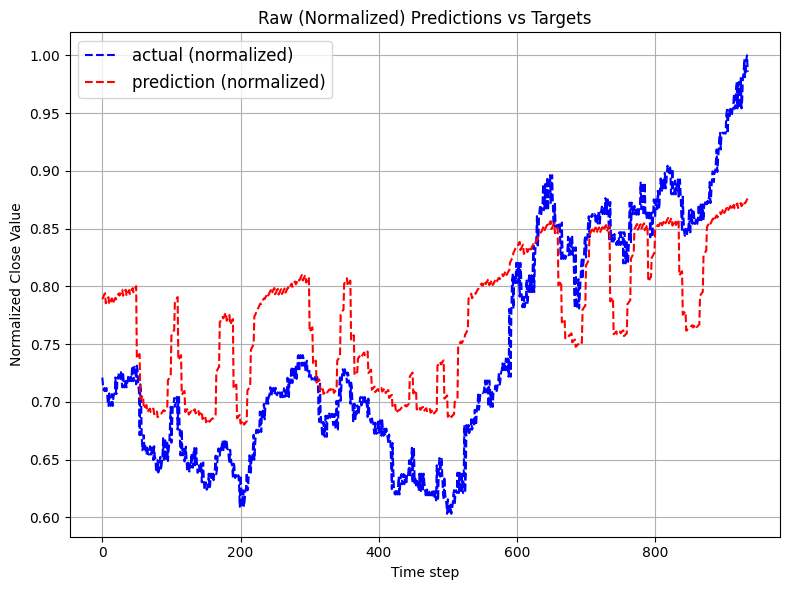

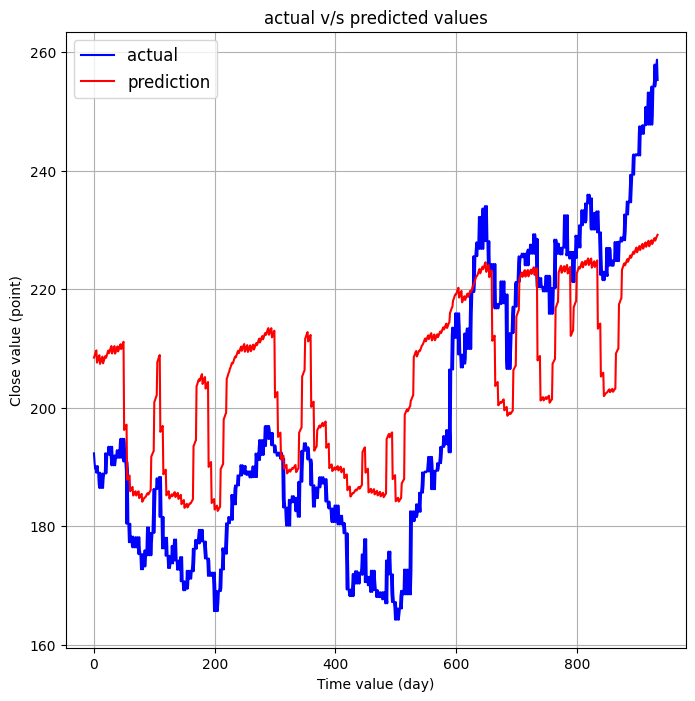

{'val_loss': 2.5917051743696082,
 'val_mae': 0.060251668095588684,
 'val_accuracy': 0.0}

In [26]:
print("here!")
trainer.evaluate(val_loader)